<a href="https://colab.research.google.com/github/MikiPenguin/test/blob/main/CsSnI3_AML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# preliminary test
we do a test of the model, data implementation/preparation and a dummy data train test

In [ ]:
# from google.colab import files

# files.upload() # This will open a file chooser and allow you to upload files.

In [ ]:
from google.colab import drive
# Attempt to mount Google Drive at the specified mountpoint.
# This will prompt for authentication the first time it is run in a new session.
# If force_remount is True, it will unmount any existing mount and remount.
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Please try restarting the runtime or checking your network connection.")

Mounted at /content/drive
Google Drive mounted successfully!


In [ ]:
# STEP 1: IMPORTING LIBRARIES AND DATA LOADING

# Import required libraries
import torch                  # For tensor operations (used by PyTorch)
import os                     # For handling file and directory paths
import glob                   # For finding files matching wildcard patterns
import numpy as np            # For handling numerical arrays
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define the directory where all .dat and .scf files are located
data_dir = '/content/drive/MyDrive/AML_Project_anharmonic/data'

# Function to load force data from .dat files
def load_forces(force_dir=data_dir, prefix='force_'):
    # Find all .dat files starting with the given prefix (e.g., 'force_001.dat', etc.)
    force_files = sorted(glob.glob(os.path.join(force_dir, f"{prefix}*.dat")))

    # If no files are found, raise an error to notify the user
    if not force_files:
        raise FileNotFoundError(f"No force files found with prefix '{prefix}' in {force_dir}")

    all_forces = []  # Initialize a list to store force arrays

    # Loop through each force file
    for fpath in force_files:
        forces = np.loadtxt(fpath)     # Load the force data into a NumPy array (expected shape: [40, 3])
        all_forces.append(forces)      # Append it to the list

    # Convert the list of NumPy arrays into a PyTorch tensor with dtype float32
    return torch.tensor(all_forces, dtype=torch.float32)  # Final shape: [N, 40, 3]

# Function to load atomic positions and cell matrices from .scf files
def load_structures(struct_dir=data_dir, prefix='struct_'):
    # Find all .scf files starting with the given prefix (e.g., 'struct_001.scf')
    struct_files = sorted(glob.glob(os.path.join(struct_dir, f"{prefix}*.scf")))

    # If no structure files are found, raise an error
    if not struct_files:
        raise FileNotFoundError(f"No structure files found with prefix '{prefix}' in {struct_dir}")

    all_positions = []  # List to store atomic positions
    all_cells = []      # List to store cell matrices

    # Loop through each structure file
    for fpath in struct_files:
        with open(fpath) as f:
            lines = f.readlines()  # Read all lines from the file into a list

        try:
            # Find the line where 'CELL_PARAMETERS' starts and get the index for the 3 lines following it
            cell_start = lines.index('CELL_PARAMETERS angstrom\n') + 1

            # Find the line where 'ATOMIC_POSITIONS' starts and get the index for the next 40 lines (atoms)
            positions_start = lines.index('ATOMIC_POSITIONS angstrom\n') + 1

        # Raise a clearer error if the necessary headers are missing
        except ValueError as e:
            raise ValueError(f"File {fpath} is missing required header lines.") from e

        # Extract the 3x3 cell matrix
        cell = np.array([list(map(float, lines[cell_start + i].split())) for i in range(3)])

        # Initialize list to store atomic positions for this structure
        pos = []

        # Read 40 lines of atomic positions
        for line in lines[positions_start:positions_start + 40]:
            parts = line.split()                 # Split the line into components
            pos.append([float(x) for x in parts[1:4]])  # Skip atom label and store x, y, z only

        # Append the extracted cell and positions to the master lists
        all_cells.append(cell)
        all_positions.append(pos)

    # Convert positions and cells lists into PyTorch tensors
    return torch.tensor(all_positions, dtype=torch.float32), torch.tensor(all_cells, dtype=torch.float32)

# ====================
# Load the data
# ====================
forces = load_forces()              # Load all force files into a tensor of shape [N, 40, 3]
positions, cells = load_structures()  # Load all structure files (positions & cells)

# ====================
# Check shapes & types
# ====================
print("Forces shape:", forces.shape)        # Should show: [N, 40, 3]
print("Forces dtype:", forces.dtype)        # Should show: torch.float32

print("Positions shape:", positions.shape)  # Should show: [N, 40, 3]
print("Cells shape:", cells.shape)          # Should show: [N, 3, 3]

# ====================
# View samples from the loaded data
# ====================
# print("\nFirst force sample:\n", forces[0])         # Print force data for the first structure
# print("\nFirst atomic positions sample:\n", positions[0])  # Print positions for the first structure
# print("\nFirst cell matrix:\n", cells[0])           # Print the 3x3 cell matrix for the first structure

# To view the second sample, uncomment below:
# print("\nSecond force sample:\n", forces[1])
# print("\nSecond atomic positions sample:\n", positions[1])
# print("\nSecond cell matrix:\n", cells[1])


/tmp/ipython-input-3-3878296750.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(all_forces, dtype=torch.float32)  # Final shape: [N, 40, 3]


Forces shape: torch.Size([100, 40, 3])
Forces dtype: torch.float32
Positions shape: torch.Size([100, 40, 3])
Cells shape: torch.Size([100, 3, 3])


In [ ]:
# Step 2: Data Preprocessing for Training
# Constants for unit conversion
# 1 Angstrom = 1.8897261249935897 Bohr
ANGSTROM_TO_BOHR = 1.8897261249935897

# Load data: forces and atomic positions & cell matrices
forces = load_forces()               # Forces currently in Ry/Bohr (as given)
positions, cells = load_structures()  # Positions currently in Angstrom; cells also in Angstrom

# Convert positions from Angstrom to Bohr since dynamical matrix expects Bohr
positions_bohr = positions * ANGSTROM_TO_BOHR  # shape: [N, 40, 3]
cells_bohr = cells * ANGSTROM_TO_BOHR          # shape: [N, 3, 3]


# Compute the equilibrium (average) positions from all structures (in Bohr)
equilibrium_pos = positions_bohr.mean(dim=0)  # shape: [40, 3]

# Calculate displacements relative to equilibrium (difference in Bohr)
displacements = positions_bohr - equilibrium_pos  # shape: [N, 40, 3]

# Note on forces:
# The forces loaded are in Ry/Bohr as given, so no conversion needed here for forces
# If forces were in different units, i would have to convert here as well

# Print shapes to verify
print("Forces shape:", forces.shape)
print("Positions shape (Bohr):", positions_bohr.shape)
print("Cells shape (Bohr):", cells_bohr.shape)
print("Equilibrium positions shape:", equilibrium_pos.shape)
print("Displacements shape:", displacements.shape)
#print("Displacements to relative equilibrium is", equilibrium_pos)

Forces shape: torch.Size([100, 40, 3])
Positions shape (Bohr): torch.Size([100, 40, 3])
Cells shape (Bohr): torch.Size([100, 3, 3])
Equilibrium positions shape: torch.Size([40, 3])
Displacements shape: torch.Size([100, 40, 3])


In [ ]:
# Step 3: PyTorch LoRA Model
#LoRA is usually applied in fine-tuning, but we can adapt it here to factorize the high-dimensional third-order tensor representing the 3-phonon interactions.

#We model:
#𝐹=𝑇(𝑢)≈𝑊1(𝑊2𝑇𝑢)
#Here is a simplified architecture to apply LoRA-style tensor decomposition:

# ------------------------------
# STEP 3: Define the LoRA Force Model
# ------------------------------

# ------------------------------
class LoRAAnharmonicForceModel(nn.Module):
    def __init__(self, num_atoms, rank=10):
        """
        Low-rank CP decomposition model for third-order force constants.
        """
        super().__init__()
        self.rank = rank
        self.num_atoms = num_atoms
        self.directions = 3  # x, y, z

        # CP decomposition factor matrices
        self.A = nn.Parameter(torch.randn(num_atoms, rank))  # atom i
        self.B = nn.Parameter(torch.randn(num_atoms, rank))  # atom j
        self.C = nn.Parameter(torch.randn(num_atoms, rank))  # atom k
        self.D = nn.Parameter(torch.randn(3, rank))          # alpha (force dir)
        self.E = nn.Parameter(torch.randn(3, rank))          # beta (disp dir 1)
        self.F = nn.Parameter(torch.randn(3, rank))          # gamma (disp dir 2)

    def forward(self, displacements):
        """
        Vectorized computation of forces.
        Args:
            displacements: Tensor of shape (N, num_atoms, 3)
        Returns:
            forces: Tensor of shape (N, num_atoms, 3)
        """
        N = displacements.shape[0]
        R = self.rank
        u = displacements  # (N, num_atoms, 3)

        # Compute displacements dot E and F
        uj_beta = torch.einsum('nij,jr->nir', u, self.E)   # (N, num_atoms, R)
        uk_gamma = torch.einsum('nij,jr->nir', u, self.F)  # (N, num_atoms, R)

        # Outer product for interaction terms
        interaction = torch.einsum('nir,njr->nijr', uj_beta, uk_gamma)  # (N, num_atoms, num_atoms, R)

        # Compute force contribution
        force = torch.zeros_like(u)  # (N, num_atoms, 3)

        for alpha in range(3):
            contrib = torch.einsum(
                'ir,jr,kr,r,njkr->ni',
                self.A, self.B, self.C, self.D[alpha], interaction
            )  # (N, num_atoms)
            force[:, :, alpha] -= contrib

        return force
# ------------------------------
# STEP : Load the data
# ------------------------------

# Constants
device = torch.device('cpu') #if torch.cuda.is_available() else 'cpu')

# Dummy loading to be replaced with actual tensors from previous conversion step
# Here we simulate realistic tensor shapes as placeholders
N = 24000  # total samples
n_atoms = 40

# Simulated displacements and forces for example
torch.manual_seed(0)
displacements = torch.randn(N, n_atoms, 3) * 0.05  # in Bohr
forces = torch.randn(N, n_atoms, 3) * 0.01         # in Ry/Bohr

# ------------------------------
# STEP 3: Split data into train/val/test
# ------------------------------

# Split: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(displacements, forces, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)  # 0.1765 * 0.85 ≈ 0.15

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 16799
Validation samples: 3601
Testing samples: 3600


In [ ]:
# # ------------------------------
# # STEP 4: Training Loop
# # ------------------------------
# model = LoRAAnharmonicForceModel(num_atoms=40).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-2)
# criterion = nn.MSELoss()

# num_epochs = 10 #150
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     # Training
#     model.train()
#     optimizer.zero_grad()
#     preds = model(X_train.to(device))
#     loss = criterion(preds, y_train.to(device))
#     loss.backward()
#     optimizer.step()
#     train_losses.append(loss.item())
#     # Validation
#     model.eval()
#     with torch.no_grad():
#         val_preds = model(X_val.to(device))
#         val_loss = criterion(val_preds, y_val.to(device)).item()
#         val_losses.append(val_loss)

#     if epoch % 10 == 0 or epoch == num_epochs - 1:
#         print(f"Epoch {epoch:03d}: Train Loss = {loss.item():.6f}, Val Loss = {val_loss:.6f}")

# # ------------------------------
# # STEP 5: Plot training/validation curves
# # ------------------------------
# plt.figure(figsize=(8, 5))
# plt.plot(train_losses, label='Training Loss', linewidth=2)
# plt.plot(val_losses, label='Validation Loss', linewidth=2)
# plt.xlabel("Epoch")
# plt.ylabel("MSE Loss (Ry/Bohr)^2")
# plt.title("Training and Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# # Save to your directory
# output_path = "/content/drive/MyDrive/AML_Project_anharmonic/training_vs_validation.png"
# plt.savefig(output_path, dpi=300)

# plt.show()

In [ ]:
# ------------------------------
# STEP 6: Evaluate on Test Set
# ------------------------------
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device))
    test_loss = criterion(test_preds, y_test.to(device)).item()
print(f"\nTest Loss (MSE): {test_loss:.6f} Ry^2/Bohr^2")

NameError: name 'model' is not defined

---
# dataset loading and architecture definition


## dataset

In [2]:
from google.colab import drive
# Attempt to mount Google Drive at the specified mountpoint.
# This will prompt for authentication the first time it is run in a new session.
# If force_remount is True, it will unmount any existing mount and remount.
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Please try restarting the runtime or checking your network connection.")

Mounted at /content/drive
Google Drive mounted successfully!


In [3]:
# ====================================================================================
# STEP 1A: BASIC DATA LOADING
# ====================================================================================

# Import required libraries
import torch                  # For tensor operations (used by PyTorch)
import os                     # For handling file and directory paths
import glob                   # For finding files matching wildcard patterns
import numpy as np            # For handling numerical arrays
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define the directory containing the DFT calculation output files
data_dir = '/content/drive/MyDrive/AML_Project_anharmonic/data'

print("Loading CsSnI3 DFT calculation data...")
print("=" * 50)

# Find all files in the data directory
force_files = sorted(glob.glob(os.path.join(data_dir, "force_*.dat")))
struct_files = sorted(glob.glob(os.path.join(data_dir, "struct_*.scf")))
dynmat_file = os.path.join(data_dir, "CsSnI3_yellowphase_2x2x2_supercell1")

print(f"Found {len(force_files)} force files")
print(f"Found {len(struct_files)} structure files")
print(f"Dynamical matrix file: {'Found' if os.path.exists(dynmat_file) else 'Not found'}")

# Basic validation
if len(force_files) == 0 or len(struct_files) == 0:
   raise FileNotFoundError("Missing force or structure files")

print("Basic file discovery completed")

Loading CsSnI3 DFT calculation data...
Found 100 force files
Found 100 structure files
Dynamical matrix file: Found
Basic file discovery completed


In [4]:
# ====================================================================================
# STEP 1B: STRUCTURE FILE PREPARATION
# ====================================================================================

def load_structures(struct_files):
    """
    Load atomic positions and lattice cells from Quantum ESPRESSO .scf files.

    Each .scf file contains:
    - CELL_PARAMETERS: 3x3 lattice vectors in Angstrom
    - ATOMIC_POSITIONS: 40 atoms with x,y,z coordinates in Angstrom
    """
    all_positions = []
    all_cells = []

    for i, fpath in enumerate(struct_files):
        with open(fpath, 'r') as f:
            lines = f.readlines()

        # Find cell parameters section
        cell_start = None
        for j, line in enumerate(lines):
            if 'CELL_PARAMETERS angstrom' in line:
                cell_start = j + 1
                break

        # Extract 3x3 cell matrix
        cell = []
        for j in range(3):
            cell_line = lines[cell_start + j].strip().split()
            cell.append([float(x) for x in cell_line])

        # Find atomic positions section
        pos_start = None
        for j, line in enumerate(lines):
            if 'ATOMIC_POSITIONS angstrom' in line:
                pos_start = j + 1
                break

        # Extract 40 atomic coordinates (skip element symbol, take x,y,z)
        positions = []
        for j in range(40):
            pos_line = lines[pos_start + j].strip().split()
            xyz = [float(pos_line[k]) for k in range(1, 4)]  # Skip element name
            positions.append(xyz)

        all_positions.append(positions)
        all_cells.append(cell)

        if (i + 1) % 1000 == 0:
            print(f"Processed {i + 1} structure files...")

    # Convert to tensors
    positions = torch.tensor(all_positions, dtype=torch.float32)
    cells = torch.tensor(all_cells, dtype=torch.float32)

    print(f"Loaded positions: {positions.shape} (Angstrom)")
    print(f"Loaded cells: {cells.shape} (Angstrom)")

    return positions, cells

# Execute structure loading
positions, cells = load_structures(struct_files)

Loaded positions: torch.Size([100, 40, 3]) (Angstrom)
Loaded cells: torch.Size([100, 3, 3]) (Angstrom)


In [5]:
# ====================================================================================
# STEP 1C: FORCE FILE PREPARATION
# ====================================================================================

def load_forces(force_files):
    """
    Load atomic forces from DFT calculations.

    Each .dat file contains:
    - 40 rows (atoms) x 3 columns (x,y,z forces)
    - Units: Ry/Bohr (Rydberg per Bohr radius)
    - These forces include anharmonic contributions we want to model
    """
    all_forces = []

    for i, fpath in enumerate(force_files):
        # Load force matrix: 40 atoms x 3 directions
        forces = np.loadtxt(fpath)

        # Validate expected shape for CsSnI3 supercell
        assert forces.shape == (40, 3), f"Expected (40,3), got {forces.shape} in {fpath}"

        all_forces.append(forces)

        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1} force files...")

    # Convert to tensor
    forces = torch.tensor(all_forces, dtype=torch.float32)

    print(f"Loaded forces: {forces.shape} (Ry/Bohr)")

    return forces

# Execute force loading
forces = load_forces(force_files)

Processed 10 force files...
Processed 20 force files...
Processed 30 force files...
Processed 40 force files...
Processed 50 force files...
Processed 60 force files...
Processed 70 force files...
Processed 80 force files...
Processed 90 force files...
Processed 100 force files...
Loaded forces: torch.Size([100, 40, 3]) (Ry/Bohr)


/tmp/ipython-input-5-223844842.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  forces = torch.tensor(all_forces, dtype=torch.float32)


In [6]:
# ====================================================================================
# STEP 1D: DYNAMICAL MATRIX PREPARATION
# ====================================================================================

def load_dynamical_matrix(dynmat_file):
    """
    Load dynamical matrix from CellConstructor format.

    The dynamical matrix contains:
    - Harmonic force constants (2nd order derivatives of energy)
    - Complex values where imaginary parts represent phonon damping
    - For our LoRA model, we only need real parts (harmonic restoring forces)
    """
    with open(dynmat_file, 'r') as f:
        lines = f.readlines()

    # Find where dynamical matrix data starts
    matrix_start = None
    for i, line in enumerate(lines):
        if 'Dynamical Matrix in cartesian axes' in line:
            matrix_start = i + 2  # Skip header lines
            break

    if matrix_start is None:
        raise ValueError("Dynamical matrix section not found")

    # Parse the dynamical matrix
    # Format: each block starts with atom indices, followed by 3x3 force constant matrix
    dynmat_real = []

    i = matrix_start
    while i < len(lines):
        line = lines[i].strip()

        # Skip empty lines
        if not line:
            i += 1
            continue

        # Check if this is an atom pair header (e.g., "1    1")
        if len(line.split()) == 2 and line.split()[0].isdigit():
            atom_i, atom_j = map(int, line.split())
            i += 1

            # Read 3x3 matrix for this atom pair
            matrix_3x3 = []
            for row in range(3):
                if i >= len(lines):
                    break
                row_data = lines[i].strip().split()

                # Extract only real parts (every other value, skip imaginary parts)
                real_parts = []
                for col in range(0, len(row_data), 2):  # Step by 2 to skip imaginary parts
                    real_parts.append(float(row_data[col]))

                matrix_3x3.append(real_parts[:3])  # Take only first 3 real values
                i += 1

            dynmat_real.append(matrix_3x3)
        else:
            i += 1

    # Convert to tensor and reshape appropriately
    dynmat_tensor = torch.tensor(dynmat_real, dtype=torch.float32)

    print(f"Loaded dynamical matrix: {dynmat_tensor.shape}")
    print("Imaginary parts discarded (only real harmonic forces kept)")

    return dynmat_tensor

# Execute dynamical matrix loading
try:
    dynmat = load_dynamical_matrix(dynmat_file)
    print("Dynamical matrix loaded successfully")
except Exception as e:
    print(f"Warning: Could not load dynamical matrix: {e}")
    dynmat = None

# ====================================================================================
# FINAL SUMMARY
# ====================================================================================

print("\n" + "=" * 50)
print("DATA LOADING COMPLETE")
print("=" * 50)
print(f"Configurations loaded: {forces.shape[0]}")
print(f"Atoms per configuration: 40")
print(f"Forces shape: {forces.shape} (Ry/Bohr)")
print(f"Positions shape: {positions.shape} (Angstrom)")
print(f"Cells shape: {cells.shape} (Angstrom)")
if dynmat is not None:
    print(f"Dynamical matrix shape: {dynmat.shape} (real parts only)")

print("\nReady for preprocessing and LoRA training")

Loaded dynamical matrix: torch.Size([1600, 3, 3])
Imaginary parts discarded (only real harmonic forces kept)
Dynamical matrix loaded successfully

DATA LOADING COMPLETE
Configurations loaded: 100
Atoms per configuration: 40
Forces shape: torch.Size([100, 40, 3]) (Ry/Bohr)
Positions shape: torch.Size([100, 40, 3]) (Angstrom)
Cells shape: torch.Size([100, 3, 3]) (Angstrom)
Dynamical matrix shape: torch.Size([1600, 3, 3]) (real parts only)

Ready for preprocessing and LoRA training


In [7]:
# ====================================================================================
# SIMPLE VISUALIZATION CHECK
# ====================================================================================

print("\n" + "=" * 50)
print("QUICK DATA VISUALIZATION CHECK")
print("=" * 50)

# Show first configuration's data
config_idx = 0
print(f"Showing data from configuration {config_idx}:")

print("\n1. FORCES (Ry/Bohr) - First 5 atoms:")
print("   Format: [force_x, force_y, force_z] for each atom")
for i in range(5):
   fx, fy, fz = forces[config_idx, i]
   print(f"   Atom {i+1:2d}: [{fx:8.5f}, {fy:8.5f}, {fz:8.5f}]")
print("   ...")

print("\n2. POSITIONS (Angstrom) - First 5 atoms:")
print("   Format: [x, y, z] coordinates for each atom")
for i in range(5):
   x, y, z = positions[config_idx, i]
   print(f"   Atom {i+1:2d}: [{x:8.3f}, {y:8.3f}, {z:8.3f}]")
print("   ...")

print("\n3. CELL MATRIX (Angstrom) - Lattice vectors:")
print("   Format: 3x3 matrix defining simulation box")
for i in range(3):
   a, b, c = cells[config_idx, i]
   print(f"   Vector {i+1}: [{a:8.3f}, {b:8.3f}, {c:8.3f}]")

if dynmat is not None:
   print("\n4. DYNAMICAL MATRIX (Real parts) - First few elements:")
   print("   Format: Harmonic force constants between atom pairs")
   print(f"   Matrix shape: {dynmat.shape}")
   print("   First 2x2 block of 3x3 matrices:")
   for i in range(min(2, dynmat.shape[0])):
       print(f"   Block {i+1}:")
       for row in range(3):
           row_values = " ".join([f"{val:8.5f}" for val in dynmat[i, row]])
           print(f"     [{row_values}]")

print("\n" + "=" * 50)

print("Data looks consistent - ready for preprocessing!")


QUICK DATA VISUALIZATION CHECK
Showing data from configuration 0:

1. FORCES (Ry/Bohr) - First 5 atoms:
   Format: [force_x, force_y, force_z] for each atom
   Atom  1: [-0.00151,  0.00239,  0.00348]
   Atom  2: [ 0.00085,  0.00780, -0.00128]
   Atom  3: [-0.00272, -0.00466,  0.01062]
   Atom  4: [ 0.03870, -0.04806, -0.02981]
   Atom  5: [-0.01358,  0.01484, -0.02542]
   ...

2. POSITIONS (Angstrom) - First 5 atoms:
   Format: [x, y, z] coordinates for each atom
   Atom  1: [   0.355,    1.068,   10.851]
   Atom  2: [   4.829,    3.494,    2.037]
   Atom  3: [  10.138,    3.443,    6.838]
   Atom  4: [   5.353,    1.351,   15.743]
   Atom  5: [   1.653,    1.049,    7.860]
   ...

3. CELL MATRIX (Angstrom) - Lattice vectors:
   Format: 3x3 matrix defining simulation box
   Vector 1: [  10.371,    0.000,    0.000]
   Vector 2: [   0.000,    9.374,    0.000]
   Vector 3: [   0.000,    0.000,   17.555]

4. DYNAMICAL MATRIX (Real parts) - First few elements:
   Format: Harmonic force con

---
just a quick visualization of what has been loaded and read

at a first look these values are consistent with the force_000.dat, struct_000.scf and the dynamical matrix ones

---

In [8]:
# ====================================================================================
# STEP 2: DISPLACEMENT CALCULATION
# ====================================================================================

print("\n" + "=" * 50)
print("STEP 2: CALCULATING ATOMIC DISPLACEMENTS")
print("=" * 50)

# Convert units: Angstrom -> Bohr (atomic units for consistency with forces)
ANGSTROM_TO_BOHR = 1.8897261249935897

print("Converting positions from Angstrom to Bohr...")
positions_bohr = positions * ANGSTROM_TO_BOHR
cells_bohr = cells * ANGSTROM_TO_BOHR
# forces = forces / 0.000449

# Calculate equilibrium (average) positions across all configurations
print("Computing equilibrium positions (thermal average)...")
equilibrium_pos = positions_bohr.mean(dim=0)  # Shape: [40, 3]

# Calculate displacements: how much each atom moved from equilibrium
print("Computing atomic displacements from equilibrium...")
displacements = positions_bohr - equilibrium_pos  # Shape: [N, 40, 3]

print(f"Equilibrium positions shape: {equilibrium_pos.shape}")
print(f"Displacements shape: {displacements.shape}")

# Quick check: displacements should have zero mean by construction
displacement_mean = displacements.mean(dim=0)
print(f"Displacement mean (should be ~0): {displacement_mean.abs().max():.8f}")

print("✓ Displacements calculated successfully")


STEP 2: CALCULATING ATOMIC DISPLACEMENTS
Converting positions from Angstrom to Bohr...
Computing equilibrium positions (thermal average)...
Computing atomic displacements from equilibrium...
Equilibrium positions shape: torch.Size([40, 3])
Displacements shape: torch.Size([100, 40, 3])
Displacement mean (should be ~0): 0.00000257
✓ Displacements calculated successfully


In [9]:
# # ====================================================================================
# # STEP 3: LoRA MODEL (CORRECTED FOR REAL DATA)
# # ====================================================================================

# class LoRAAnharmonicForceModel(nn.Module):
#     def __init__(self, num_atoms=40, rank=4):  # FIXED: Default rank=4, explicit num_atoms
#         """
#         Low-rank CP decomposition model for third-order force constants.
#         Compresses 3-phonon interactions: Φ[i,j,k,α,β,γ] ≈ Σ_r A[i,r]×B[j,r]×C[k,r]×D[α,r]×E[β,r]×F[γ,r]
#         """
#         super().__init__()
#         self.rank = rank
#         self.num_atoms = num_atoms
#         self.directions = 3

#         # # FIXED: Smaller initialization scale for better training stability
#         # physics_scale = forces.std()  # should be ~0.01
#         # init_scale = physics_scale #* 0.1
#         init_scale = 1.0

#         # CP decomposition factor matrices for 3-phonon interactions
#         self.A = nn.Parameter(torch.randn(num_atoms, rank) * init_scale)  # atom i
#         self.B = nn.Parameter(torch.randn(num_atoms, rank) * init_scale)  # atom j
#         self.C = nn.Parameter(torch.randn(num_atoms, rank) * init_scale)  # atom k
#         self.D = nn.Parameter(torch.randn(3, rank) * init_scale)          # force directions
#         self.E = nn.Parameter(torch.randn(3, rank) * init_scale)          # displacement dir 1
#         self.F = nn.Parameter(torch.randn(3, rank) * init_scale)          # displacement dir 2

#     def forward(self, displacements):
#         """Keep the forward method exactly the same - it's correct"""
#         N = displacements.shape[0]
#         u = displacements

#         uj_beta = torch.einsum('nij,jr->nir', u, self.E)
#         uk_gamma = torch.einsum('nij,jr->nir', u, self.F)
#         interaction = torch.einsum('nir,njr->nijr', uj_beta, uk_gamma)

#         force = torch.zeros_like(u)
#         for alpha in range(3):
#             contrib = torch.einsum(
#                 'ir,jr,kr,r,njkr->ni',
#                 self.A, self.B, self.C, self.D[alpha], interaction
#             )
#             force[:, :, alpha] -= contrib

#         return force

# # ====================================================================================
# # STEP 3B: USE REAL DATA (NOT DUMMY DATA)
# # ====================================================================================

# # REMOVE all dummy data generation:
# # DELETE: N = 24000, torch.manual_seed(0), torch.randn() lines

# # Use your actual data from Steps 1-2:
# print(f"Using real CsSnI3 data: {forces.shape}")  # Your real forces tensor
# print(f"Using real displacements: {displacements.shape}")  # Your real displacements

# # Split YOUR real data (not dummy data)
# X_temp, X_test, y_temp, y_test = train_test_split(
#     displacements, forces,  # FIXED: Use your real tensors
#     test_size=0.15, random_state=42
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.1765, random_state=42
# )

# print(f"Training samples: {len(X_train)}")
# print(f"Validation samples: {len(X_val)}")
# print(f"Testing samples: {len(X_test)}")

# # Create model with correct parameters
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = LoRAAnharmonicForceModel(num_atoms=40, rank=4).to(device)
# print("✓ LoRA model ready for real CsSnI3 data")

In [10]:
# # ====================================================================================
# # STEP 3: FORCE-BASED LoRA MODEL (CORRECTED FOR SLIDES SPECIFICATION)
# # ====================================================================================

# class ForceBasedLoRAModel(nn.Module):
#    def __init__(self, num_atoms=40, rank=4, n_modes=3):
#        """
#        Force-based LoRA model implementing the cost function from project slides.
#        Cost function: L = <∑_a [f_a + ∑_b Φ_ab u_b + 1/2 ∑_ξ v1_ξa (v2_ξ·u) (v3_ξ·u)]>²

#        This directly optimizes forces (not IFC tensors) as specified in the slides.
#        """
#        super().__init__()
#        self.num_atoms = num_atoms
#        self.rank = rank
#        self.n_modes = n_modes
#        self.force_dim = 3 * num_atoms  # 3 coordinates per atom

#        # FIXED: Physics-based initialization scale
#        init_scale = 0.01 # 0.001  # Small initialization for stability (0.01, lr=10-5)

#        # Low-rank mode tensors from slides: v1_ξa, v2_ξ, v3_ξ
#        self.v1_modes = nn.Parameter(torch.randn(n_modes, self.force_dim) * init_scale)  # force modes
#        self.v2_modes = nn.Parameter(torch.randn(n_modes, self.force_dim) * init_scale)  # displacement modes
#        self.v3_modes = nn.Parameter(torch.randn(n_modes, self.force_dim) * init_scale)  # displacement modes

#        # Harmonic force constant matrix Φ_ab
#        self.harmonic_matrix = nn.Parameter(torch.randn(self.force_dim, self.force_dim) * init_scale)

#    def forward(self, displacements):
#        """
#        Forward pass: compute predicted forces using slides cost function structure

#        Implements: f_predicted = ∑_b Φ_ab u_b + 1/2 ∑_ξ v1_ξa (v2_ξ·u) (v3_ξ·u)
#        """
#        batch_size = displacements.shape[0]

#        # Flatten displacements to (batch_size, force_dim)
#        u_flat = displacements.view(batch_size, -1)

#        # Ensure harmonic matrix is symmetric for physical consistency
#        harmonic_sym = 0.5 * (self.harmonic_matrix + self.harmonic_matrix.T)

#        # Harmonic force contribution: ∑_b Φ_ab u_b
#        harmonic_forces = torch.matmul(u_flat, harmonic_sym.T)

#        # Anharmonic force contribution: 1/2 ∑_ξ v1_ξa (v2_ξ·u) (v3_ξ·u)
#        anharmonic_forces = torch.zeros_like(harmonic_forces)

#        for xi in range(self.n_modes):
#            # Calculate dot products v2_ξ·u and v3_ξ·u
#            v2_dot_u = torch.sum(self.v2_modes[xi] * u_flat, dim=1, keepdim=True)  # (batch_size, 1)
#            v3_dot_u = torch.sum(self.v3_modes[xi] * u_flat, dim=1, keepdim=True)  # (batch_size, 1)

#            # Add anharmonic contribution: 0.5 * v1_ξa * (v2_ξ·u) * (v3_ξ·u)
#            mode_contribution = 0.5 * self.v1_modes[xi] * v2_dot_u * v3_dot_u
#            anharmonic_forces += mode_contribution

#        # Total predicted forces
#        predicted_forces = harmonic_forces + anharmonic_forces

#        # Reshape back to original force tensor shape
#        return predicted_forces.view(batch_size, self.num_atoms, 3)


#    ########## ACTUAL COST FUNCTION #############
#    def compute_force_cost(self, displacements, true_forces):
#        """
#        Compute the force-based cost function from slides:
#        L = <∑_a [f_a + ∑_b Φ_ab u_b + 1/2 ∑_ξ v1_ξa (v2_ξ·u) (v3_ξ·u)]>²

#        Returns the ensemble-averaged squared residual.
#        """

#        predicted_forces = self.forward(displacements)
#        # Force residual: f_true + f_predicted (solving f + Φu + anharmonic = 0)
#        force_residual = true_forces + predicted_forces

#        # Ensemble average: mean over all force components
#        cost = torch.mean(force_residual**2)

#        return cost

#    def apply_acoustic_sum_rule(self):
#        """Apply acoustic sum rule constraint: ∑_l,b A^ξ_i(l,bα) = 0"""
#        with torch.no_grad():
#            # Apply constraint to displacement modes (zero mean)
#            self.v2_modes.data -= torch.mean(self.v2_modes.data, dim=1, keepdim=True)
#            self.v3_modes.data -= torch.mean(self.v3_modes.data, dim=1, keepdim=True)

# # ====================================================================================
# # STEP 3B: USE REAL DATA (NOT DUMMY DATA)
# # ====================================================================================

# # REMOVE all dummy data generation:
# # DELETE: N = 24000, torch.manual_seed(0), torch.randn() lines

# # Use your actual data from Steps 1-2:
# print(f"Using real CsSnI3 data: {forces.shape}")  # Your real forces tensor
# print(f"Using real displacements: {displacements.shape}")  # Your real displacements

# # Split YOUR real data (not dummy data)
# X_temp, X_test, y_temp, y_test = train_test_split(
#    displacements, forces,  # FIXED: Use your real tensors
#    test_size=0.15, random_state=42
# )
# X_train, X_val, y_train, y_val = train_test_split(
#    X_temp, y_temp, test_size=0.1765, random_state=42
# )

# print(f"Training samples: {len(X_train)}")
# print(f"Validation samples: {len(X_val)}")
# print(f"Testing samples: {len(X_test)}")

# # Create model with correct parameters for force-based optimization
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ForceBasedLoRAModel(num_atoms=40, rank=4, n_modes=3).to(device)
# print("✓ Force-based LoRA model ready for real CsSnI3 data")
# print(f"✓ Model uses slides cost function: L = <f + Φu + anharmonic>²")
# print(f"✓ Optimizing {sum(p.numel() for p in model.parameters())} parameters")

In [11]:
# # ====================================================================================
# # DATA SPLIT CONFIGURATION
# # ====================================================================================

# # Define split percentages as variables
# TEST_SIZE = 0.1        # testing
# VAL_SIZE = 0.2       # remaining data for validation
# RANDOM_STATE = 42       # For reproducible splits

# print(f"Data split configuration:")
# print(f"  Test size: {TEST_SIZE:.1%}")
# print(f"  Validation size: {VAL_SIZE:.1%} of remaining data")
# print(f"  Training size: ~{1.0 - TEST_SIZE - VAL_SIZE:.1%} of remaining data")
# #print(f"  Training size: ~{(1-TEST_SIZE)*(1-VAL_SIZE):.1%} of total data")
# print(f"  Random state: {RANDOM_STATE}")

# # ====================================================================================
# # STEP 3: FORCE-BASED LoRA MODEL (CORRECTED FOR SLIDES SPECIFICATION)
# # ====================================================================================

# class ForceBasedLoRAModel(nn.Module):
#    def __init__(self, num_atoms=40, rank=5, n_modes=3):
#        """
#        Force-based LoRA model implementing the cost function from project slides.
#        Cost function: L = <∑_a [f_a + ∑_b Φ_ab u_b + 1/2 ∑_ξ v1_ξa (v2_ξ·u) (v3_ξ·u)]>²

#        This directly optimizes forces (not IFC tensors) as specified in the slides.
#        """
#        super().__init__()
#        self.num_atoms = num_atoms
#        self.rank = rank
#        self.n_modes = n_modes
#        self.force_dim = 3 * num_atoms  # 3 coordinates per atom

#        # FIXED: Physics-based initialization scale
#        init_scale = 0.01 # 0.001  # Small initialization for stability (0.01, lr=10-5)

#        # Low-rank mode tensors from slides: v1_ξa, v2_ξ, v3_ξ
#        self.v1_modes = nn.Parameter(torch.randn(n_modes, self.force_dim) * init_scale)
#        self.v2_modes = nn.Parameter(torch.randn(n_modes, self.force_dim) * init_scale)
#        self.v3_modes = nn.Parameter(torch.randn(n_modes, self.force_dim) * init_scale)

#        # Harmonic force constant matrix Φ_ab
#        self.harmonic_matrix = nn.Parameter(torch.randn(self.force_dim, self.force_dim) * init_scale)

#    def forward(self, displacements):
#        """
#        Forward pass: compute predicted forces using slides cost function structure

#        Implements: f_predicted = ∑_b Φ_ab u_b + 1/2 ∑_ξ v1_ξa (v2_ξ·u) (v3_ξ·u)
#        """
#        batch_size = displacements.shape[0]
#        # Flatten displacements to (batch_size, force_dim)
#        u_flat = displacements.view(batch_size, -1)

#        # Ensure harmonic matrix is symmetric for physical consistency
#        harmonic_sym = 0.5 * (self.harmonic_matrix + self.harmonic_matrix.T)

#        # Harmonic force contribution: ∑_b Φ_ab u_b
#        harmonic_forces = torch.matmul(u_flat, harmonic_sym.T)

#        # Anharmonic force contribution: 1/2 ∑_ξ v1_ξa (v2_ξ·u) (v3_ξ·u)
#        anharmonic_forces = torch.zeros_like(harmonic_forces)

#        for xi in range(self.n_modes):
#            # Calculate dot products v2_ξ·u and v3_ξ·u
#            v2_dot_u = torch.sum(self.v2_modes[xi] * u_flat, dim=1, keepdim=True)  # (batch_size, 1)
#            v3_dot_u = torch.sum(self.v3_modes[xi] * u_flat, dim=1, keepdim=True)  # (batch_size, 1)

#            # Add anharmonic contribution: 0.5 * v1_ξa * (v2_ξ·u) * (v3_ξ·u)
#            mode_contribution = 0.5 * self.v1_modes[xi] * v2_dot_u * v3_dot_u
#            anharmonic_forces += mode_contribution

#        # Total predicted forces
#        predicted_forces = harmonic_forces + anharmonic_forces

#        # Reshape back to original force tensor shape
#        return predicted_forces.view(batch_size, self.num_atoms, 3)


#    ########## ACTUAL COST FUNCTION (MSE) #############
#    def compute_force_cost(self, displacements, true_forces):
#        """
#        Compute the force-based cost function from slides:
#        L = <∑_a [f_a + ∑_b Φ_ab u_b + 1/2 ∑_ξ v1_ξa (v2_ξ·u) (v3_ξ·u)]>²

#        Returns the ensemble-averaged squared residual.
#        """

#        predicted_forces = self.forward(displacements)
#        # Force residual: f_true + f_predicted (solving f + Φu + anharmonic = 0)
#        force_residual = true_forces - predicted_forces

#        # Ensemble average: mean over all force components
#        cost = torch.mean(force_residual**2)

#        return cost

#    def apply_acoustic_sum_rule(self):
#        """Apply acoustic sum rule constraint: ∑_l,b A^ξ_i(l,bα) = 0"""
#        with torch.no_grad():
#            # Apply constraint to displacement modes (zero mean)
#            self.v2_modes.data -= torch.mean(self.v2_modes.data, dim=1, keepdim=True)
#            self.v3_modes.data -= torch.mean(self.v3_modes.data, dim=1, keepdim=True)

# # ====================================================================================
# # STEP 3B: USE REAL DATA (NOT DUMMY DATA)
# # ====================================================================================

# # REMOVE all dummy data generation:
# # DELETE: N = 24000, torch.manual_seed(0), torch.randn() lines

# # Use your actual data from Steps 1-2:
# print(f"Using real CsSnI3 data: {forces.shape}")  # Your real forces tensor
# print(f"Using real displacements: {displacements.shape}")  # Your real displacements

# # Split YOUR real data (not dummy data) using the configured percentages
# X_temp, X_test, y_temp, y_test = train_test_split(
#    displacements, forces,  # FIXED: Use your real tensors
#    test_size=TEST_SIZE, random_state=RANDOM_STATE
# )
# X_train, X_val, y_train, y_val = train_test_split(
#    X_temp, y_temp, test_size=VAL_SIZE, random_state=RANDOM_STATE
# )

# print(f"Training samples: {len(X_train)}")
# print(f"Validation samples: {len(X_val)}")
# print(f"Testing samples: {len(X_test)}")

# # Verify split percentages
# total_samples = len(displacements)
# actual_test_pct = len(X_test) / total_samples
# actual_val_pct = len(X_val) / total_samples
# actual_train_pct = len(X_train) / total_samples

# print(f"Actual split percentages:")
# print(f"  Training: {actual_train_pct:.1%}")
# print(f"  Validation: {actual_val_pct:.1%}")
# print(f"  Testing: {actual_test_pct:.1%}")

# # Create model with correct parameters for force-based optimization
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ForceBasedLoRAModel(num_atoms=40, rank=4, n_modes=3).to(device)
# print("✓ Force-based LoRA model ready for real CsSnI3 data")
# print(f"✓ Model uses slides cost function: L = <f + Φu + anharmonic>²")
# print(f"✓ Optimizing {sum(p.numel() for p in model.parameters())} parameters")

## model

In [51]:
# ====================================================================================
# DATA SPLIT CONFIGURATION
# ====================================================================================

# Define split percentages as variables
TEST_SIZE = 0.1        # testing
VAL_SIZE = 0.2       # remaining data for validation
RANDOM_STATE = 42       # arbitrary, for reproducible splits

print(f"Data split configuration:")
print(f"  Test size: {TEST_SIZE:.1%}")
print(f"  Validation size: ~{VAL_SIZE:.1%} of remaining data")
print(f"  Training size: ~{1.0 - TEST_SIZE - VAL_SIZE:.1%} of remaining data")
#print(f"  Training size: ~{(1-TEST_SIZE)*(1-VAL_SIZE):.1%} of total data")
print(f"  Random state: {RANDOM_STATE}")



# replaced the original ForceBasedLoRAModel with the symmetry-enforced version
class ForceBasedLoRAModel(nn.Module):
    def __init__(self, num_atoms=40, rank=5):
        """
        Force-based LoRA model with permutation symmetry for third-order force constants.

        Args:
            num_atoms: Number of atoms in the system
            rank: Rank R of the CP decomposition (i.e., number of ξ modes)
        """
        super().__init__()
        self.num_atoms = num_atoms
        self.rank = rank
        self.force_dim = 3 * num_atoms

        # Physics-based initialization
        init_scale = 0.01

        # CP decomposition factor vectors
        self.v1_modes = nn.Parameter(torch.randn(rank, self.force_dim) * init_scale)
        self.v2_modes = nn.Parameter(torch.randn(rank, self.force_dim) * init_scale)
        self.v3_modes = nn.Parameter(torch.randn(rank, self.force_dim) * init_scale)

        # Harmonic force constant matrix Φ_ab
        self.harmonic_matrix = nn.Parameter(torch.randn(self.force_dim, self.force_dim) * init_scale)

    def forward(self, displacements):
        """
        Forward pass with permutation symmetry enforcement.

        CP decomposition: Φ³ₐᵦᶜ = Σ_ξ v1_ξa × v2_ξb × v3_ξc

        With permutation symmetry:
        f_a = 1/3 × Σ_ξ [(v1_ξa × (v2_ξ·u) × (v3_ξ·u)) +
                         (v2_ξa × (v1_ξ·u) × (v3_ξ·u)) +
                         (v3_ξa × (v1_ξ·u) × (v2_ξ·u))]
        """
        batch_size = displacements.shape[0]
        u_flat = displacements.view(batch_size, -1)

        # Harmonic contribution (symmetric by construction)
        harmonic_sym = 0.5 * (self.harmonic_matrix + self.harmonic_matrix.T)
        harmonic_forces = torch.matmul(u_flat, harmonic_sym.T)

        # Anharmonic contribution with permutation symmetry
        anharmonic_forces = torch.zeros_like(harmonic_forces)

        ################
        # # permutation add (since phi is simmetric over indexes, it's a derivative over displacements, this should, in theory, provide better validation)
        # # UNCOMMENT TO APPLY
        # for xi in range(self.rank):
        #     # Calculate dot products for all three vectors with displacement
        #     v1_dot_u = torch.sum(self.v1_modes[xi] * u_flat, dim=1, keepdim=True)
        #     v2_dot_u = torch.sum(self.v2_modes[xi] * u_flat, dim=1, keepdim=True)
        #     v3_dot_u = torch.sum(self.v3_modes[xi] * u_flat, dim=1, keepdim=True)

        #     # Three permutations of the CP decomposition
        #     perm1 = self.v1_modes[xi] * v2_dot_u * v3_dot_u  # 123
        #     perm2 = self.v2_modes[xi] * v1_dot_u * v3_dot_u  # 213
        #     perm3 = self.v3_modes[xi] * v1_dot_u * v2_dot_u  # 312


        #     # Average over permutations to enforce symmetry
        #     mode_contribution = (perm1 + perm2 + perm3) / 3.0
        #     anharmonic_forces += mode_contribution
        ################

        # Total predicted forces
        predicted_forces = harmonic_forces + anharmonic_forces
        return predicted_forces.view(batch_size, self.num_atoms, 3)


    ########## ACTUAL COST FUNCTION (MSE) #############
    def compute_force_cost(self, displacements, true_forces):
        """
        Compute the force-based cost function from slides:
        L = <∑_a [f_a + ∑_b Φ_ab u_b + 1/2 ∑_ξ v1_ξa (v2_ξ·u) (v3_ξ·u)]>²

        Returns the ensemble-averaged squared residual.
        """

        predicted_forces = self.forward(displacements)
        # Force residual: f_true + f_predicted (solving f + Φu + anharmonic = 0)
        force_residual = true_forces - predicted_forces

        # Ensemble average: mean over all force components
        cost = torch.mean(force_residual**2)

        return cost

    # def apply_acoustic_sum_rule(self):
    #     """Apply acoustic sum rule constraint: ∑_l,b A^ξ_i(l,bα) = 0"""
    #     with torch.no_grad():
    #         # Apply constraint to displacement modes (zero mean)
    #         self.v2_modes.data -= torch.mean(self.v2_modes.data, dim=1, keepdim=True)
    #         self.v3_modes.data -= torch.mean(self.v3_modes.data, dim=1, keepdim=True)

# ====================================================================================
# STEP 3B: USE REAL DATA (NOT DUMMY DATA)
# ====================================================================================

# REMOVE all dummy data generation:
# DELETE: N = 24000, torch.manual_seed(0), torch.randn() lines

# Use your actual data from Steps 1-2:
print(f"Using real CsSnI3 data: {forces.shape}")  # Your real forces tensor
print(f"Using real displacements: {displacements.shape}")  # Your real displacements

# Split data using the configured percentages
X_temp, X_test, y_temp, y_test = train_test_split(
   displacements, forces,  # FIXED: Use your real tensors
   test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
   X_temp, y_temp, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")

# Verify split percentages
total_samples = len(displacements)
actual_test_pct = len(X_test) / total_samples
actual_val_pct = len(X_val) / total_samples
actual_train_pct = len(X_train) / total_samples

print(f"Actual split percentages:")
print(f"  Training: {actual_train_pct:.1%}")
print(f"  Validation: {actual_val_pct:.1%}")
print(f"  Testing: {actual_test_pct:.1%}")

# Create model with correct parameters for force-based optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ForceBasedLoRAModel(num_atoms=40, rank=4).to(device)
print("✓ Force-based LoRA model ready for real CsSnI3 data")
print(f"✓ Model uses slides cost function: L = <f + Φu + anharmonic>²")
print(f"✓ Optimizing {sum(p.numel() for p in model.parameters())} parameters")

Data split configuration:
  Test size: 10.0%
  Validation size: ~20.0% of remaining data
  Training size: ~70.0% of remaining data
  Random state: 42
Using real CsSnI3 data: torch.Size([100, 40, 3])
Using real displacements: torch.Size([100, 40, 3])
Training samples: 72
Validation samples: 18
Testing samples: 10
Actual split percentages:
  Training: 72.0%
  Validation: 18.0%
  Testing: 10.0%
✓ Force-based LoRA model ready for real CsSnI3 data
✓ Model uses slides cost function: L = <f + Φu + anharmonic>²
✓ Optimizing 15840 parameters


# parameters tuning

## learning rate

In [ ]:
# n = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# LR = [1e-3, 1e-4, 1e-5, 1e-6]
# results = []

# for lr in LR:
#     for i in n:
#         # print(f"Testing n={i}, lr={lr:.0e}, effective_lr={i*lr:.0e}")

#         model = ForceBasedLoRAModel(num_atoms=40, rank=10).to(device)
#         optimizer = optim.Adam(model.parameters(), lr=i * lr)
#         criterion = nn.MSELoss()

#         # Reset early stopping parameters for each model
#         patience = 20
#         best_val_loss = 1.0
#         patience_counter = 0
#         best_epoch = 0

#         train_losses = []
#         val_losses = []

#         for epoch in range(1000000):
#             # Training
#             model.train()
#             optimizer.zero_grad()
#             preds = model(X_train.to(device))
#             loss = criterion(preds, y_train.to(device))
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())

#             # Validation
#             model.eval()
#             with torch.no_grad():
#                 val_preds = model(X_val.to(device))
#                 val_loss = criterion(val_preds, y_val.to(device)).item()
#                 val_losses.append(val_loss)

#             # Early stopping logic
#             if val_loss < best_val_loss:
#                 best_val_loss = val_loss
#                 best_epoch = epoch
#                 patience_counter = 0
#             else:
#                 patience_counter += 1

#             if patience_counter >= patience:
#                 # print(f"  Early stopping at epoch {epoch}")
#                 # print(f"  Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
#                 break

#         # Store results
#         results.append((i, lr, best_val_loss, best_epoch))

# print(f"\nResults: {results}")

# # Find best configuration
# best_config = min(results, key=lambda x: x[2])  # Min by validation loss
# print(f"\nBest config: n={best_config[0]}, lr={best_config[1]:.0e}")
# print(f"Best validation loss: {best_config[2]:.6f}")

---


## rank influence on the training
we try to establish if pushing the rank to higher values means:
1. moving around a minimum with more dof
2. exploring a new landscape with better minimums

---

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np

# # we should move the parameters after a bit to make sure we are not in a stable local minimum

# # Rank comparison loop with multiple runs per rank
# final_train_losses = []
# final_val_losses = []

# num_runs_per_rank = 2  # Consigliato almeno 3
# patience = 300          # Early stopping patience

# max_epochs=10000
# for rank in range(1, 20):
#     if rank % 1 == 0:
#         print(f"Training Rank {rank}...")

#         rank_train_losses = []
#         rank_val_losses = []

#         for run in range(num_runs_per_rank):
#             device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#             model = ForceBasedLoRAModel(num_atoms=40, rank=rank).to(device)
#             optimizer = optim.Adam(model.parameters(), lr=2*1e-5) #just a little faster
#             criterion = nn.MSELoss()

#             best_val_loss = float('inf')
#             best_train_loss = None
#             patience_counter = 0

#             for epoch in range(max_epochs):  # Max epochs
#                 model.train()
#                 optimizer.zero_grad()
#                 preds = model(X_train.to(device))
#                 loss = criterion(preds, y_train.to(device))
#                 loss.backward()
#                 optimizer.step()

#                 model.eval()
#                 with torch.no_grad():
#                     val_preds = model(X_val.to(device))
#                     val_loss = criterion(val_preds, y_val.to(device)).item()

#                 if val_loss < best_val_loss:
#                     best_val_loss = val_loss
#                     best_train_loss = loss.item()
#                     patience_counter = 0  # reset patience
#                 else:
#                     patience_counter += 1

#                 if patience_counter >= patience:
#                     print(f"Early stopping at epoch {epoch + 1}")
#                     break

#             rank_train_losses.append(best_train_loss)
#             rank_val_losses.append(best_val_loss)

#         min_train_loss = np.min(rank_train_losses)
#         min_val_loss = np.min(rank_val_losses)

#         final_train_losses.append(min_train_loss)
#         final_val_losses.append(min_val_loss)

#         print(f"Rank {rank}: Best losses = {min_train_loss:.6f}, {min_val_loss:.6f}")

# print("All training completed!")
# print("learnign rate = 2*1e-5")
# print("early stopping patience =", patience)
# print("max epochs =", max_epochs)
# print("num_runs_per_rank =", num_runs_per_rank)

Training Rank 1...
Early stopping at epoch 1169
Early stopping at epoch 1074
Rank 1: Best losses = 0.000017, 0.000182
Training Rank 2...
Early stopping at epoch 1451
Early stopping at epoch 1246
Rank 2: Best losses = 0.000015, 0.000177
Training Rank 3...
Early stopping at epoch 1244
Early stopping at epoch 1176
Rank 3: Best losses = 0.000016, 0.000157
Training Rank 4...
Early stopping at epoch 1077
Early stopping at epoch 5308
Rank 4: Best losses = 0.000007, 0.000190
Training Rank 5...
Early stopping at epoch 1401
Early stopping at epoch 1159
Rank 5: Best losses = 0.000013, 0.000183
Training Rank 6...
Early stopping at epoch 938
Early stopping at epoch 1060
Rank 6: Best losses = 0.000017, 0.000198
Training Rank 7...
Early stopping at epoch 1053
Early stopping at epoch 852
Rank 7: Best losses = 0.000018, 0.000188
Training Rank 8...
Early stopping at epoch 4093
Early stopping at epoch 929
Rank 8: Best losses = 0.000004, 0.000193
Training Rank 9...
Early stopping at epoch 3611
Early stopp

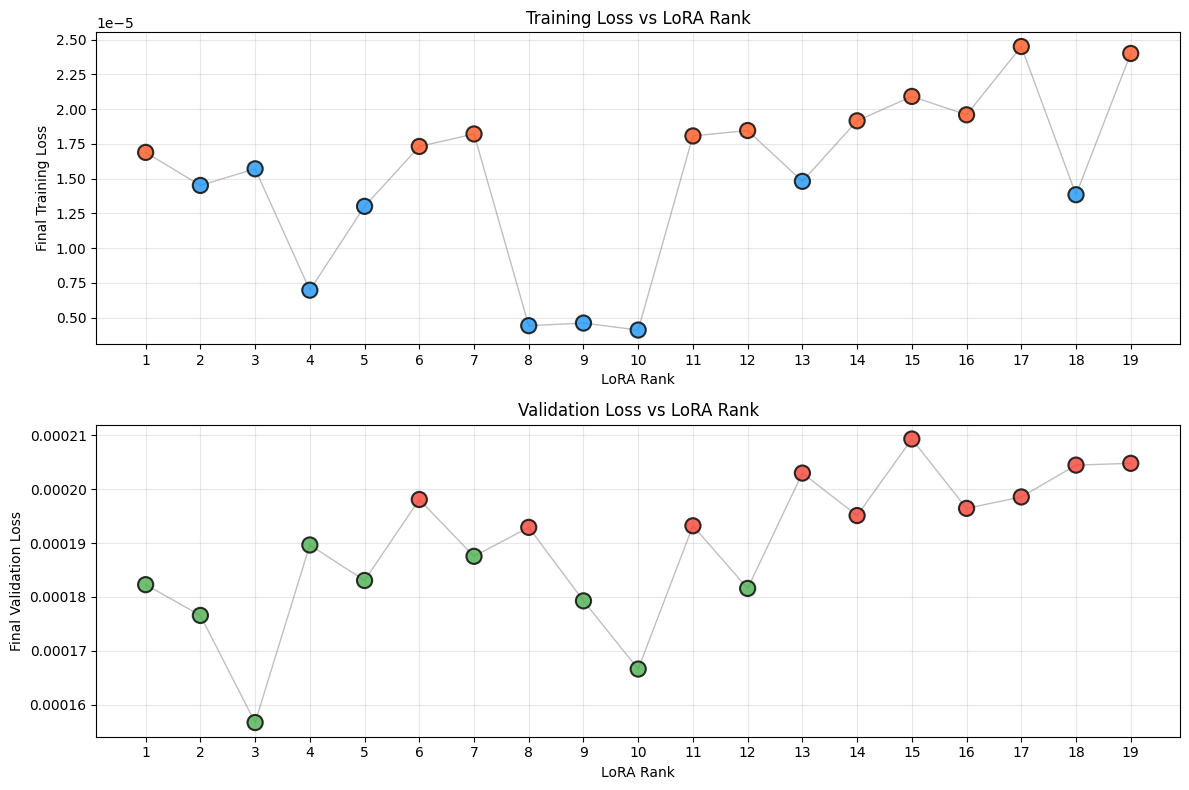


Best training loss: Rank 10 (0.000004)
Best validation loss: Rank 3 (0.000157)


In [ ]:
# # Plot results
# x = np.arange(1, len(final_train_losses)+1)  # ranks 1 to whatever
# #x = 5*x
# plt.figure(figsize=(12, 8))

# # Subplot 1: Training losses
# plt.subplot(2, 1, 1)
# colors_train = ['#2196f3' if loss < np.median(final_train_losses) else '#ff5722' for loss in final_train_losses]
# plt.scatter(x, final_train_losses, c=colors_train, s=120, alpha=0.8, edgecolors='black', linewidth=1.5, zorder=3)
# plt.plot(x, final_train_losses, linewidth=1, alpha=0.5, color='gray')
# plt.xlabel('LoRA Rank')
# plt.ylabel('Final Training Loss')
# plt.title('Training Loss vs LoRA Rank')
# plt.grid(True, alpha=0.3)
# plt.xticks(x)

# # Subplot 2: Validation losses
# plt.subplot(2, 1, 2)
# colors_val = ['#4caf50' if loss < np.median(final_val_losses) else '#f44336' for loss in final_val_losses]
# plt.scatter(x, final_val_losses, c=colors_val, s=120, alpha=0.8, edgecolors='black', linewidth=1.5, zorder=3)
# plt.plot(x, final_val_losses, linewidth=1, alpha=0.5, color='gray')
# plt.xlabel('LoRA Rank')
# plt.ylabel('Final Validation Loss')
# plt.title('Validation Loss vs LoRA Rank')
# plt.grid(True, alpha=0.3)
# plt.xticks(x)

# plt.tight_layout()
# plt.show()

# # Find optimal ranks
# best_train_rank = x[np.argmin(final_train_losses)]
# best_val_rank = x[np.argmin(final_val_losses)]

# print(f"\nBest training loss: Rank {best_train_rank} ({min(final_train_losses):.6f})")
# print(f"Best validation loss: Rank {best_val_rank} ({min(final_val_losses):.6f})")

---

## incremental rank
we rerty this by training with increasing rank, storing them and training also the old ones, like a warm start, to try to avoid overfitting

---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Incremental rank comparison - train ALL parameters at each rank starting from previous solution
# This avoids overfitting by allowing all parameters to adjust together

final_train_losses = []
final_val_losses = []
global_epochs = 0 # to apply the noise every tot


stored_parameters = {}  # Dictionary to store trained parameters from previous ranks
patience = 100          # Early stopping patience
noise_speed = 200


for rank in range(1, 30):
    if rank == 1:
        print(f"Training Rank {rank}")
    if rank > 1:
        print(f"\nTraining Rank {rank} (starting from rank {rank-1} solution)...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ForceBasedLoRAModel(num_atoms=40, rank=rank).to(device)

    # Load previously trained parameters if available
    prev_rank = rank - 1
    if prev_rank > 0 and prev_rank in stored_parameters:
        print(f"  Loading converged parameters from rank {prev_rank}")
        prev_state = stored_parameters[prev_rank]
        current_state = model.state_dict()

        for param_name in ['v1_modes', 'v2_modes', 'v3_modes']:
            if param_name in prev_state and param_name in current_state:
                current_state[param_name][:prev_rank].data.copy_(
                    prev_state[param_name][:prev_rank].data
                )

        if 'harmonic_matrix' in prev_state and 'harmonic_matrix' in current_state:
            current_state['harmonic_matrix'].data.copy_(prev_state['harmonic_matrix'].data)

        model.load_state_dict(current_state)
    else:
        print(f"  Training from random initialization")

    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=2*1e-5)
    criterion = nn.MSELoss()

    print(f"  Training with early stopping (patience={patience})...")

    best_val_loss = float('inf')
    best_train_loss = None
    patience_counter = 0

    if noise_speed >50: noise_speed -= 1

    for epoch in range(1000):  # Max limit, to see a slower convergence we put max_epochs < convergence_time and it does not get to convergence at the first step, 2nd,3rd,4th etc...

        # stocastic noise every tot epochs
        global_epochs += 1
        if global_epochs > 0 and global_epochs % noise_speed == 0:
            epsilon = 1e-4
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if 'v' in name:
                        param.add_(torch.randn_like(param) * epsilon)
            print(f"  Applied noise perturbation at epoch {global_epochs}")

        # training
        model.train()
        optimizer.zero_grad()
        preds = model(X_train.to(device))
        loss = criterion(preds, y_train.to(device))
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val.to(device))
            val_loss = criterion(val_preds, y_val.to(device)).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_train_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"  Early stopping at epoch {epoch + 1}")
            break

    final_train_losses.append(best_train_loss)
    final_val_losses.append(best_val_loss)

    # Store trained parameters for next rank
    state_to_store = {}
    for name, param in model.named_parameters():
        state_to_store[name] = param.clone().detach()

    stored_parameters[rank] = state_to_store

    print(f"Rank {rank}: Final losses = {best_train_loss:.6f} (train), {best_val_loss:.6f} (val)")

    if len(final_train_losses) > 1:
        prev_train = final_train_losses[-2]
        prev_val = final_val_losses[-2]
        train_improvement = (prev_train - best_train_loss) / prev_train * 100
        val_improvement = (prev_val - best_val_loss) / prev_val * 100

        print(f"  Training improvement: {train_improvement:.2f}%")
        print(f"  Validation improvement: {val_improvement:.2f}%")

print("\nIncremental training completed!")
print("\nAnalysis Summary:")
print("=" * 50)

if len(final_train_losses) > 0:
    baseline_train = final_train_losses[0]
    baseline_val = final_val_losses[0]

    print(f"Baseline (rank 1): Train={baseline_train:.6f}, Val={baseline_val:.6f}")

    for i, rank in enumerate(range(1, 10)):
        if i < len(final_train_losses):
            train_improvement = (baseline_train - final_train_losses[i]) / baseline_train * 100
            val_improvement = (baseline_val - final_val_losses[i]) / baseline_val * 100

            print(f"Rank {rank:2d}: Train improvement {train_improvement:6.2f}%, Val improvement {val_improvement:6.2f}%")

# # Find optimal rank more sophisticated analysis
# print(f"\nOptimal Rank Analysis:")
# best_val_idx = np.argmin(final_val_losses)
# optimal_rank = best_val_idx + 1
# print(f"Best validation loss achieved at rank {optimal_rank}: {final_val_losses[best_val_idx]:.6f}")

# # Check for overfitting after optimal rank
# if optimal_rank < len(final_val_losses):
#     subsequent_ranks = list(range(optimal_rank + 1, len(final_val_losses) + 1))
#     overfitting_ranks = [r for r in subsequent_ranks if final_val_losses[r-1] > final_val_losses[optimal_rank-1]]

#     if overfitting_ranks:
#         print(f"Ranks {overfitting_ranks} show overfitting (validation loss increased)")
#     else:
#         print("No clear overfitting detected in the tested range")

# print(f"\nRecommendation: Use rank {optimal_rank} for optimal generalization")

Training Rank 1
  Training from random initialization
  Training with early stopping (patience=100)...
  Applied noise perturbation at epoch 199
  Applied noise perturbation at epoch 398
  Applied noise perturbation at epoch 597
  Applied noise perturbation at epoch 796
  Applied noise perturbation at epoch 995
Rank 1: Final losses = 0.000018 (train), 0.000176 (val)

Training Rank 2 (starting from rank 1 solution)...
  Loading converged parameters from rank 1
  Training with early stopping (patience=100)...
  Early stopping at epoch 160
Rank 2: Final losses = 0.000015 (train), 0.000172 (val)
  Training improvement: 17.01%
  Validation improvement: 1.95%

Training Rank 3 (starting from rank 2 solution)...
  Loading converged parameters from rank 2
  Training with early stopping (patience=100)...
  Applied noise perturbation at epoch 1182
  Early stopping at epoch 101
Rank 3: Final losses = 0.000014 (train), 0.000174 (val)
  Training improvement: 4.64%
  Validation improvement: -0.82%

T

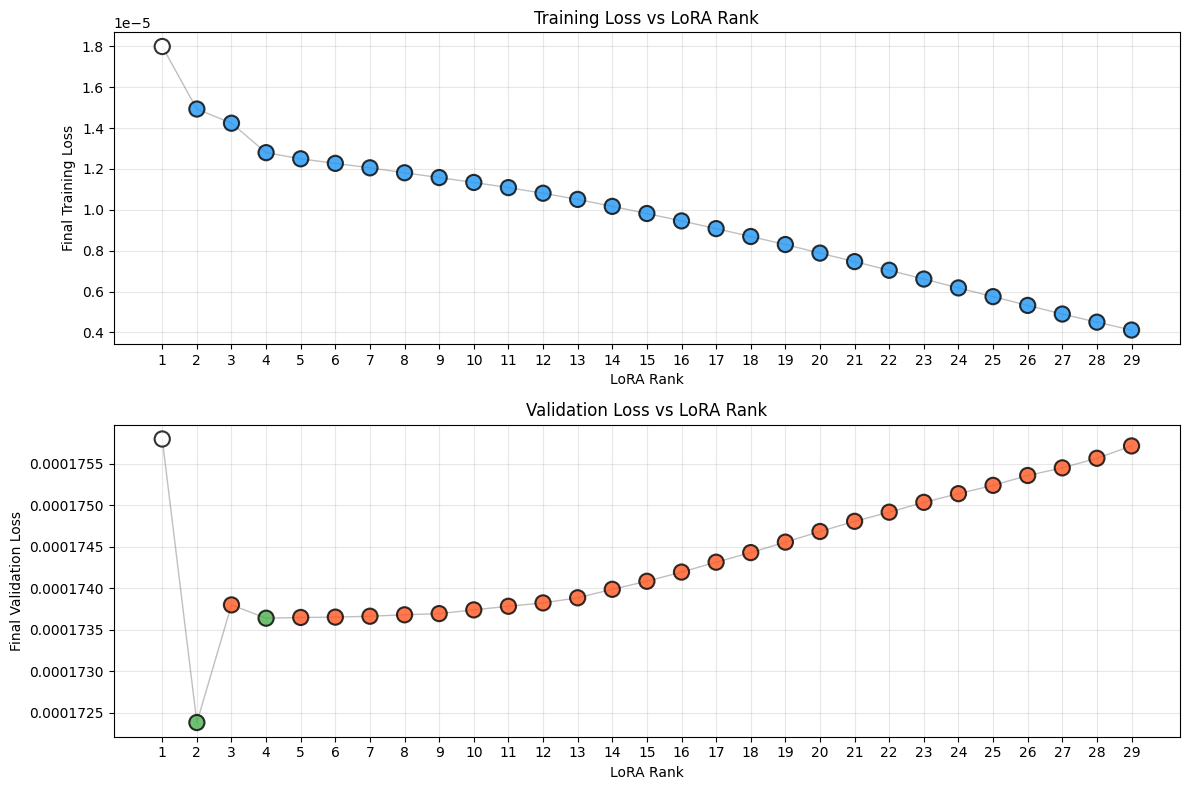

In [ ]:
# Plot results
x = np.arange(1, len(final_train_losses)+1)  # ranks 1 to whatever

plt.figure(figsize=(12, 8))

# Subplot 1: Training losses
plt.subplot(2, 1, 1)
colors_train = []
for i in range(len(final_train_losses)):
    if i == 0:
        colors_train.append('w')  # first
    elif final_train_losses[i] < final_train_losses[i-1]:
        colors_train.append('#2196f3')  #  better
    else:
        colors_train.append('#ff5722')  #  worse

plt.scatter(x, final_train_losses, c=colors_train, s=120, alpha=0.8, edgecolors='black', linewidth=1.5, zorder=3)
plt.plot(x, final_train_losses, linewidth=1, alpha=0.5, color='gray')
plt.xlabel('LoRA Rank')
plt.ylabel('Final Training Loss')
plt.title('Training Loss vs LoRA Rank')
plt.grid(True, alpha=0.3)
plt.xticks(x)

# Subplot 2: Validation losses
plt.subplot(2, 1, 2)
colors_val = []
for i in range(len(final_val_losses)):
    if i == 0:
        colors_val.append('w')  # first
    elif final_val_losses[i] < final_val_losses[i-1]:
        colors_val.append('#4caf50')  #  better
    else:
        colors_val.append('#ff5722')  #  worse

plt.scatter(x, final_val_losses, c=colors_val, s=120, alpha=0.8, edgecolors='black', linewidth=1.5, zorder=3)
plt.plot(x, final_val_losses, linewidth=1, alpha=0.5, color='gray')
plt.xlabel('LoRA Rank')
plt.ylabel('Final Validation Loss')
plt.title('Validation Loss vs LoRA Rank')
plt.grid(True, alpha=0.3)
plt.xticks(x)

plt.tight_layout()
plt.show()

# validation

## single training loop

In [52]:
# ------------------------------
# STEP 4: Training Loop with Early Stopping
# ------------------------------
model = ForceBasedLoRAModel(num_atoms=40, rank=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=2*1e-5)
criterion = nn.MSELoss()

max_epochs = 10000
patience = 200
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_train_loss = None
patience_counter = 0

for epoch in range(max_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    preds = model(X_train.to(device))
    loss = criterion(preds, y_train.to(device))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val.to(device))
        val_loss = criterion(val_preds, y_val.to(device)).item()
        val_losses.append(val_loss)

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_train_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    # Print progress
    if epoch % 100 == 0 or epoch == max_epochs - 1:
        print(f"Epoch {epoch:03d}: Train Loss = {loss.item():.6f}, Val Loss = {val_loss:.6f}")

    # Early stopping condition
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

print(f"Best Train Loss = {best_train_loss:.6f}, Best Val Loss = {best_val_loss:.6f}")
num_epochs = len(train_losses)

Epoch 000: Train Loss = 0.000707, Val Loss = 0.000679
Epoch 100: Train Loss = 0.000355, Val Loss = 0.000450
Epoch 200: Train Loss = 0.000193, Val Loss = 0.000327
Epoch 300: Train Loss = 0.000114, Val Loss = 0.000258
Epoch 400: Train Loss = 0.000072, Val Loss = 0.000219
Epoch 500: Train Loss = 0.000049, Val Loss = 0.000196
Epoch 600: Train Loss = 0.000036, Val Loss = 0.000183
Epoch 700: Train Loss = 0.000028, Val Loss = 0.000176
Epoch 800: Train Loss = 0.000023, Val Loss = 0.000172
Epoch 900: Train Loss = 0.000020, Val Loss = 0.000170
Epoch 1000: Train Loss = 0.000018, Val Loss = 0.000169
Epoch 1100: Train Loss = 0.000016, Val Loss = 0.000169
Epoch 1200: Train Loss = 0.000015, Val Loss = 0.000170
Early stopping triggered at epoch 1231
Best Train Loss = 0.000017, Best Val Loss = 0.000169


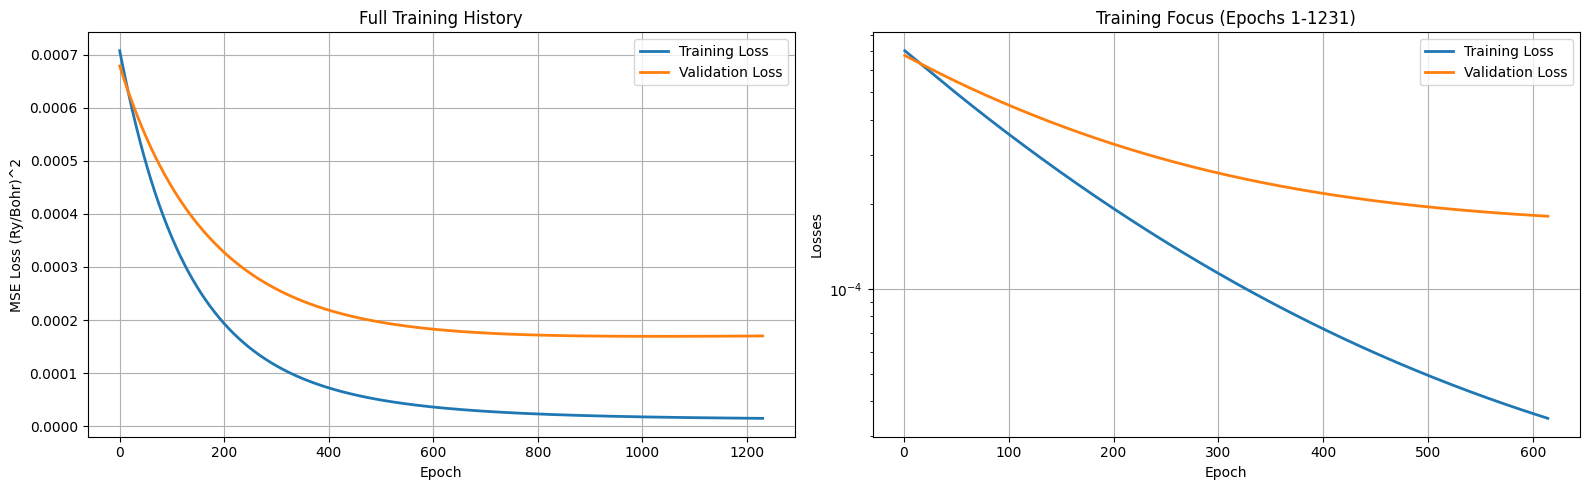

In [53]:
# ------------------------------
# STEP 5: Plot training/validation curves (with zoom)
# ------------------------------

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
len_losses_reduced = len(train_losses)/2


# First plot: Full training history
ax1.plot(train_losses, label='Training Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss (Ry/Bohr)^2")
ax1.set_title("Full Training History")
ax1.legend()
ax1.grid(True)

# Second plot: Zoomed view (last phase of training)
zoom_start = 1  # Start from epoch 1000
zoom_end = int(len(train_losses)/2)  # End at the last epoch
# ax2.plot(range(zoom_start, len(train_losses)), train_losses[zoom_start:], label='Training Loss', linewidth=2)
# ax2.plot(range(zoom_start, len(val_losses)), val_losses[zoom_start:], label='Validation Loss', linewidth=2)
ax2.plot(range(zoom_start, zoom_end), train_losses[zoom_start:zoom_end], label='Training Loss', linewidth=2)
ax2.plot(range(zoom_start, zoom_end), val_losses[zoom_start:zoom_end], label='Validation Loss', linewidth=2)
# ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Losses")
ax2.set_title(f"Training Focus (Epochs {zoom_start}-{num_epochs})")
ax2.legend()
ax2.grid(True)

plt.tight_layout()

# Save the combined plot
output_path = "/content/drive/MyDrive/AML_Project_anharmonic/training_vs_validation_detailed.png"
plt.savefig(output_path, dpi=300)

plt.show()

# # Optional: Print convergence info
# if len(train_losses) > 1000:
#    early_loss = np.mean(train_losses[100:200])
#    late_loss = np.mean(train_losses[-100:])
#    print(f"\nConvergence analysis:")
#    print(f"Early training loss (epochs 100-200): {early_loss:.6f}")
#    print(f"Late training loss (last 100 epochs): {late_loss:.6f}")
#    print(f"Improvement: {((early_loss - late_loss) / early_loss * 100):.1f}%")

In [54]:
# Just look at your existing losses
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
ratio = final_val_loss / final_train_loss

print(f"Final training loss: {final_train_loss:.6f}")
print(f"Final validation loss: {final_val_loss:.6f}")
print(f"Ratio: {ratio:.1f}")

Final training loss: 0.000015
Final validation loss: 0.000170
Ratio: 11.4


In [55]:
from scipy.stats import pearsonr
# Calculate the exact scaling correction if needed
true_forces_flat = y_test.numpy().flatten()
with torch.no_grad():
    raw_predictions = model(X_test.to(device)).cpu().numpy().flatten()

# Calculate optimal scaling
optimal_scale = np.std(true_forces_flat) / np.std(raw_predictions)
print(f"Current prediction std: {np.std(raw_predictions):.6f}")
print(f"Target force std: {np.std(true_forces_flat):.6f}")
print(f"Optimal scaling factor: {optimal_scale:.6f}")

# Test with manual scaling
scaled_predictions = raw_predictions * optimal_scale
correlation_scaled, _ = pearsonr(scaled_predictions, true_forces_flat)
print(f"Correlation after optimal scaling: {correlation_scaled:.4f}")

Current prediction std: 0.013209
Target force std: 0.011019
Optimal scaling factor: 0.834186
Correlation after optimal scaling: 0.4849


In [56]:
print("Data diagnostics:")
print(f"Forces mean: {forces.mean():.6f}")
print(f"Forces std: {forces.std():.6f}")
print(f"Forces max: {forces.abs().max():.6f}")
print(f"Displacements mean: {displacements.mean():.6f}")
print(f"Displacements std: {displacements.std():.6f}")
print(f"Displacements max: {displacements.abs().max():.6f}")

Data diagnostics:
Forces mean: -0.000000
Forces std: 0.010867
Forces max: 0.074190
Displacements mean: 0.000000
Displacements std: 0.311267
Displacements max: 1.309401


## forces validation

Generating force comparison visualization...


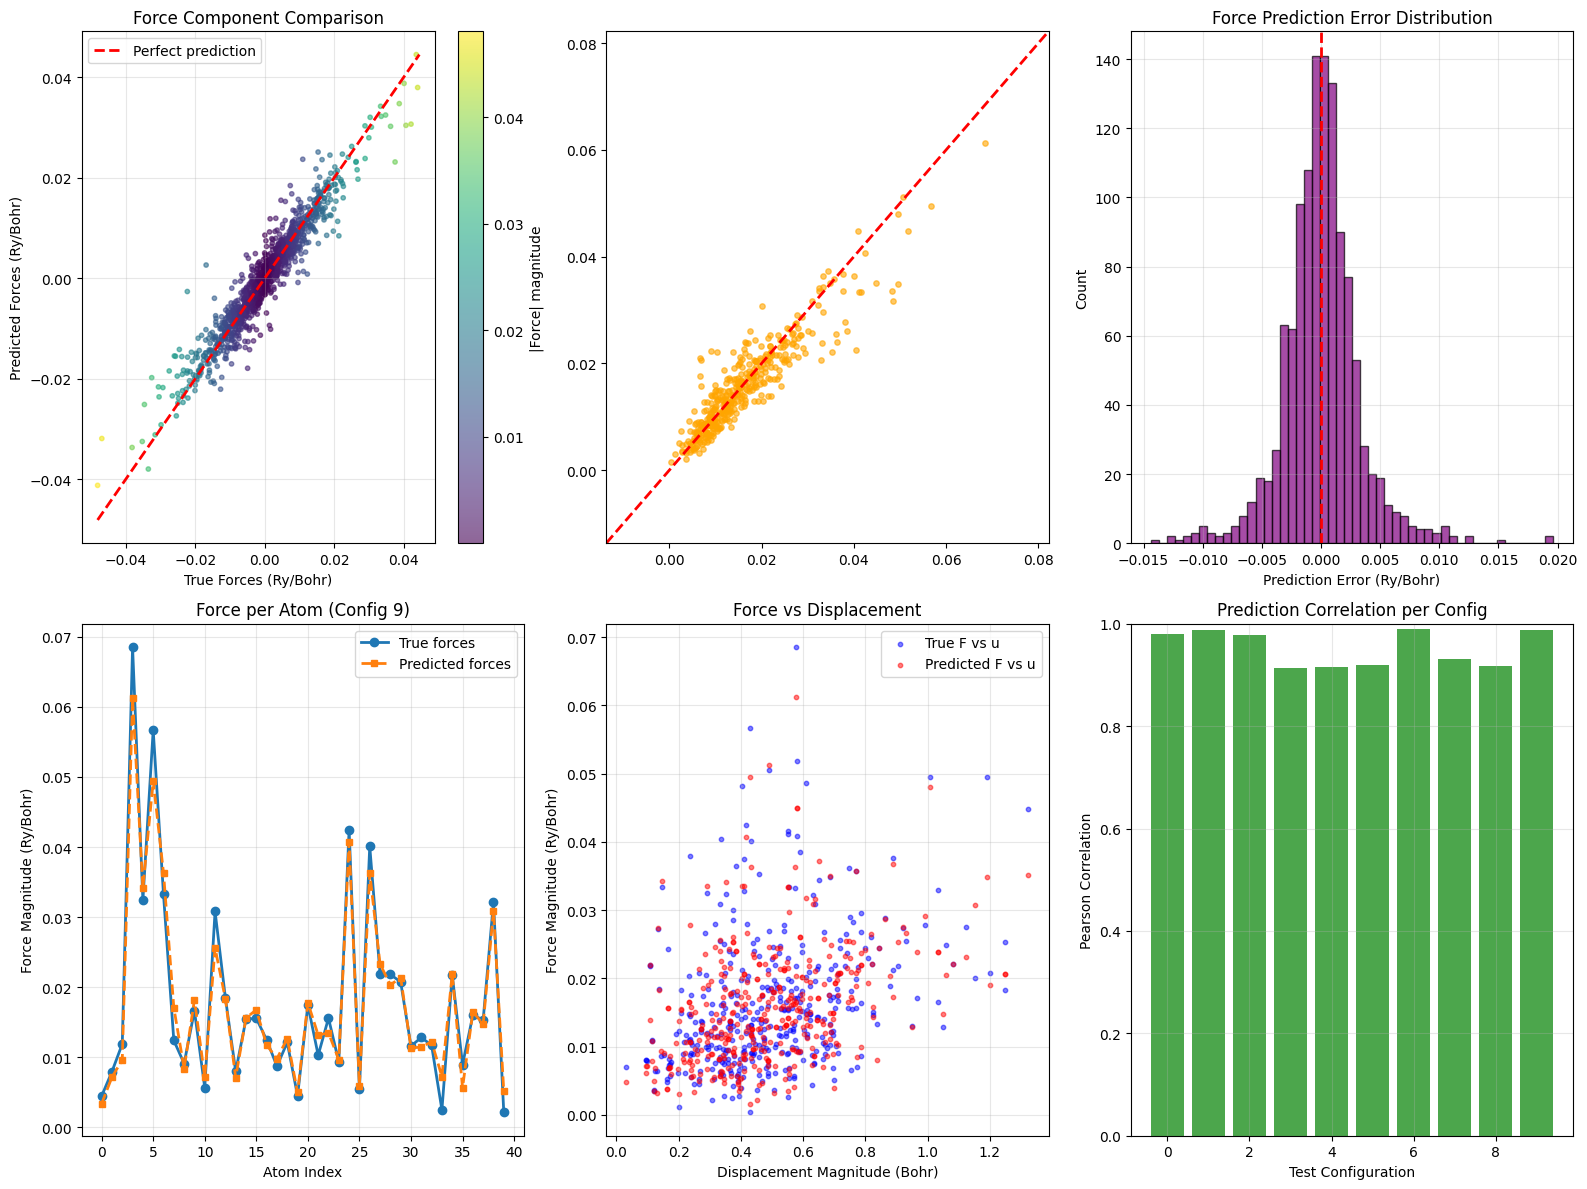

FORCE PREDICTION ANALYSIS:
Number of test configurations: 10
Total force components compared: 1,200
Mean Squared Error (MSE): 1.076287e-05 (Ry/Bohr)²
Root Mean Squared Error (RMSE): 3.280681e-03 Ry/Bohr
Mean Absolute Error (MAE): 2.282486e-03 Ry/Bohr
R² Score: 0.9114
Overall Correlation: 0.9547

Force Magnitude Metrics:
Magnitude MSE: 1.596952e-05 (Ry/Bohr)²
Magnitude MAE: 2.716915e-03 Ry/Bohr

Per-Configuration Correlations:
Average correlation: 0.9524
Min correlation: 0.9145
Max correlation: 0.9896

Scale Analysis:
True force range: [-4.8059e-02, 4.3986e-02] Ry/Bohr
Predicted force range: [-4.1179e-02, 4.4476e-02] Ry/Bohr
True force std: 1.1019e-02 Ry/Bohr
Predicted force std: 1.0440e-02 Ry/Bohr


In [83]:
def compare_forces_visualization(model, X_test, y_test, device, n_samples=20):
    """
    Compare LoRA model predictions with actual DFT forces.

    Args:
        model: Trained LoRA model
        X_test: Test displacements
        y_test: Test forces (ground truth)
        device: GPU/CPU device
        n_samples: Number of configurations to visualize
    """

    model.eval()

    # Get predictions on test set
    with torch.no_grad():
        test_predictions = model(X_test[:n_samples].to(device)).cpu().numpy()

    test_targets = y_test[:n_samples].numpy()
    test_displacements = X_test[:n_samples].numpy()

    # Create comprehensive comparison plots
    fig = plt.figure(figsize=(16, 12))

    # Plot 1: Force component scatter plot
    ax1 = plt.subplot(2, 3, 1)
    pred_flat = test_predictions.flatten()
    pred_flat = pred_flat# * optimal_scale # RESCALE A BIT
    target_flat = test_targets.flatten()

    # Color by force magnitude
    colors = np.abs(target_flat)
    scatter = ax1.scatter(target_flat, pred_flat, c=colors, alpha=0.6, s=10, cmap='viridis')

    # Perfect prediction line
    min_force = min(target_flat.min(), pred_flat.min())
    max_force = max(target_flat.max(), pred_flat.max())
    ax1.plot([min_force, max_force], [min_force, max_force], 'r--', linewidth=2, label='Perfect prediction')

    ax1.set_xlabel('True Forces (Ry/Bohr)')
    ax1.set_ylabel('Predicted Forces (Ry/Bohr)')
    ax1.set_title('Force Component Comparison')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    plt.colorbar(scatter, ax=ax1, label='|Force| magnitude')

    # Plot 2: Force magnitude comparison
    ax2 = plt.subplot(2, 3, 2)
    pred_magnitudes = np.linalg.norm(test_predictions, axis=2)
    target_magnitudes = np.linalg.norm(test_targets, axis=2)

    pred_mag_flat = pred_magnitudes.flatten()
    target_mag_flat = target_magnitudes.flatten()

    ax2.scatter(target_mag_flat, pred_mag_flat, alpha=0.6, s=15, color='orange')

    # Expand axis range to squeeze the data
    # data_min = min(target_mag_flat.min(), pred_mag_flat.min())
    data_min = 0
    data_max = max(target_mag_flat.max(), pred_mag_flat.max())
    expanded_range = (data_max - data_min) * 2.0  # Expand by factor of 2
    axis_min = data_min - expanded_range * 0.1
    axis_max = data_max + expanded_range * 0.1

    ax2.set_xlim(axis_min, axis_max)
    ax2.set_ylim(axis_min, axis_max)
    ax2.plot([axis_min, axis_max], [axis_min, axis_max], 'r--', linewidth=2)

    # Plot 3: Error distribution
    ax3 = plt.subplot(2, 3, 3)
    errors = pred_flat - target_flat
    ax3.hist(errors, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax3.axvline(0, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Prediction Error (Ry/Bohr)')
    ax3.set_ylabel('Count')
    ax3.set_title('Force Prediction Error Distribution')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Per-atom force comparison for one configuration
    ax4 = plt.subplot(2, 3, 4)
    config_idx = np.random.randint(n_samples) # this index is randomized between the n_samples to compare to that force pattern

    atom_indices = np.arange(40)

    pred_atom_forces = np.linalg.norm(test_predictions[config_idx], axis=1)
    target_atom_forces = np.linalg.norm(test_targets[config_idx], axis=1)

    ax4.plot(atom_indices, target_atom_forces, 'o-', label='True forces', linewidth=2, markersize=6)
    ax4.plot(atom_indices, pred_atom_forces, 's--', label='Predicted forces', linewidth=2, markersize=4)
    ax4.set_xlabel('Atom Index')
    ax4.set_ylabel('Force Magnitude (Ry/Bohr)')
    ax4.set_title(f'Force per Atom (Config {config_idx})')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Plot 5: Displacement vs Force relationship
    ax5 = plt.subplot(2, 3, 5)
    disp_magnitudes = np.linalg.norm(test_displacements, axis=2).flatten()

    ax5.scatter(disp_magnitudes, target_mag_flat, alpha=0.5, s=10, label='True F vs u', color='blue')
    ax5.scatter(disp_magnitudes, pred_mag_flat, alpha=0.5, s=10, label='Predicted F vs u', color='red')
    ax5.set_xlabel('Displacement Magnitude (Bohr)')
    ax5.set_ylabel('Force Magnitude (Ry/Bohr)')
    ax5.set_title('Force vs Displacement')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Plot 6: Correlation analysis
    ax6 = plt.subplot(2, 3, 6)
    from scipy.stats import pearsonr

    # Calculate correlations for each sample
    correlations = []
    for i in range(n_samples):
        pred_i = test_predictions[i].flatten()
        target_i = test_targets[i].flatten()
        if np.std(pred_i) > 1e-8 and np.std(target_i) > 1e-8:
            corr, _ = pearsonr(pred_i, target_i)
            correlations.append(corr)

    ax6.bar(range(len(correlations)), correlations, alpha=0.7, color='green')
    ax6.set_xlabel('Test Configuration')
    ax6.set_ylabel('Pearson Correlation')
    ax6.set_title('Prediction Correlation per Config')
    ax6.grid(True, alpha=0.3)
    ax6.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # Print quantitative metrics
    print("FORCE PREDICTION ANALYSIS:")
    print("=" * 50)
    print(f"Number of test configurations: {n_samples}")
    print(f"Total force components compared: {len(pred_flat):,}")

    # Overall metrics
    mse = np.mean((pred_flat - target_flat)**2) # mean squared error
    mae = np.mean(np.abs(pred_flat - target_flat)) # mean absolute error
    rmse = np.sqrt(mse)

    if np.std(target_flat) > 0:
        # r2 = 1 - np.var(pred_flat - target_flat) / np.var(target_flat)
        r2 = 1 - np.sum((target_flat - pred_flat)**2) / np.sum((target_flat - np.mean(target_flat))**2) # this is good over 0.6, ca
        overall_corr, _ = pearsonr(pred_flat, target_flat)
    else:
        r2 = 0
        overall_corr = 0

    print(f"Mean Squared Error (MSE): {mse:.6e} (Ry/Bohr)²")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6e} Ry/Bohr")
    print(f"Mean Absolute Error (MAE): {mae:.6e} Ry/Bohr")
    print(f"R² Score: {r2:.4f}")
    print(f"Overall Correlation: {overall_corr:.4f}")

    # Magnitude metrics
    mag_mse = np.mean((pred_mag_flat - target_mag_flat)**2)
    mag_mae = np.mean(np.abs(pred_mag_flat - target_mag_flat))

    print(f"\nForce Magnitude Metrics:")
    print(f"Magnitude MSE: {mag_mse:.6e} (Ry/Bohr)²")
    print(f"Magnitude MAE: {mag_mae:.6e} Ry/Bohr")

    if len(correlations) > 0:
        print(f"\nPer-Configuration Correlations:")
        print(f"Average correlation: {np.mean(correlations):.4f}")
        print(f"Min correlation: {np.min(correlations):.4f}")
        print(f"Max correlation: {np.max(correlations):.4f}")

    # Scale comparison
    print(f"\nScale Analysis:")
    print(f"True force range: [{target_flat.min():.4e}, {target_flat.max():.4e}] Ry/Bohr")
    print(f"Predicted force range: [{pred_flat.min():.4e}, {pred_flat.max():.4e}] Ry/Bohr")
    print(f"True force std: {np.std(target_flat):.4e} Ry/Bohr")
    print(f"Predicted force std: {np.std(pred_flat):.4e} Ry/Bohr")

# Run the comparison
print("Generating force comparison visualization...")
compare_forces_visualization(model, X_test, y_test, device, n_samples=10)

In [84]:
# def compare_forces_visualization(model, X_test, y_test, device, n_samples=5):
#     """
#     Compare LoRA model predictions with actual DFT forces.

#     Args:
#         model: Trained LoRA model
#         X_test: Test displacements
#         y_test: Test forces (ground truth)
#         device: GPU/CPU device
#         n_samples: Number of configurations to visualize
#     """

#     model.eval()

#     # Get predictions on test set
#     with torch.no_grad():
#         test_predictions = model(X_test[:n_samples].to(device)).cpu().numpy()

#     test_targets = y_test[:n_samples].numpy()
#     test_displacements = X_test[:n_samples].numpy()

#     # Create comparison plots (only 4 instead of 6)
#     fig = plt.figure(figsize=(14, 10))

#     # Plot 1: Force component scatter plot
#     ax1 = plt.subplot(2, 1, 1)
#     pred_flat = test_predictions.flatten()
#     target_flat = test_targets.flatten()
#     colors = np.abs(target_flat)
#     scatter = ax1.scatter(target_flat, pred_flat, c=colors, alpha=0.6, s=10, cmap='viridis')
#     min_force = min(target_flat.min(), pred_flat.min())
#     max_force = max(target_flat.max(), pred_flat.max())
#     ax1.plot([min_force, max_force], [min_force, max_force], 'r--', linewidth=2, label='Perfect prediction')
#     ax1.set_xlabel('True Forces (Ry/Bohr)')
#     ax1.set_ylabel('Predicted Forces (Ry/Bohr)')
#     ax1.set_title('Force Component Comparison')
#     ax1.grid(True, alpha=0.3)
#     ax1.legend()
#     plt.colorbar(scatter, ax=ax1, label='|Force| magnitude')

#     # (Plot 2 rimosso)

#     # Plot 3: Error distribution
#     # ax2 = plt.subplot(2, 2, 2)
#     errors = pred_flat - target_flat
#     ax2.hist(errors, bins=50, alpha=0.7, color='purple', edgecolor='black')
#     ax2.axvline(0, color='red', linestyle='--', linewidth=2)
#     ax2.set_xlabel('Prediction Error (Ry/Bohr)')
#     ax2.set_ylabel('Count')
#     ax2.set_title('Force Prediction Error Distribution')
#     ax2.grid(True, alpha=0.3)

#     # Plot 4: Per-atom force comparison
#     ax3 = plt.subplot(2, 1, 2)
#     config_idx = 0  # First test configuration
#     atom_indices = np.arange(40)
#     pred_atom_forces = np.linalg.norm(test_predictions[config_idx], axis=1)
#     target_atom_forces = np.linalg.norm(test_targets[config_idx], axis=1)
#     ax3.plot(atom_indices, target_atom_forces, 'o-', label='True forces', linewidth=2, markersize=6)
#     ax3.plot(atom_indices, pred_atom_forces, 's--', label='Predicted forces', linewidth=2, markersize=4)
#     ax3.set_xlabel('Atom Index')
#     ax3.set_ylabel('Force Magnitude (Ry/Bohr)')
#     ax3.set_title(f'Force per Atom (Config {config_idx})')
#     ax3.legend()
#     ax3.grid(True, alpha=0.3)

#     # Plot 5: Displacement vs Force relationship
#     # ax4 = plt.subplot(2, 2, 4)
#     disp_magnitudes = np.linalg.norm(test_displacements, axis=2).flatten()
#     pred_magnitudes = np.linalg.norm(test_predictions, axis=2).flatten()
#     target_magnitudes = np.linalg.norm(test_targets, axis=2).flatten()
#     ax4.scatter(disp_magnitudes, target_magnitudes, alpha=0.5, s=10, label='True F vs u', color='blue')
#     ax4.scatter(disp_magnitudes, pred_magnitudes, alpha=0.5, s=10, label='Predicted F vs u', color='red')
#     ax4.set_xlabel('Displacement Magnitude (Bohr)')
#     ax4.set_ylabel('Force Magnitude (Ry/Bohr)')
#     ax4.set_title('Force vs Displacement')
#     ax4.legend()
#     ax4.grid(True, alpha=0.3)

#     # (Plot 6 rimosso)

#     plt.tight_layout()
#     plt.show()

#     # Print quantitative metrics
#     print("FORCE PREDICTION ANALYSIS:")
#     print("=" * 50)
#     print(f"Number of test configurations: {n_samples}")
#     print(f"Total force components compared: {len(pred_flat):,}")

#     # Overall metrics
#     mse = np.mean((pred_flat - target_flat)**2)
#     mae = np.mean(np.abs(pred_flat - target_flat))
#     rmse = np.sqrt(mse)

#     if np.std(target_flat) > 0:
#         r2 = 1 - np.var(pred_flat - target_flat) / np.var(target_flat)
#         from scipy.stats import pearsonr
#         overall_corr, _ = pearsonr(pred_flat, target_flat)
#     else:
#         r2 = 0
#         overall_corr = 0

#     print(f"Mean Squared Error (MSE): {mse:.6e} (Ry/Bohr)²")
#     print(f"Root Mean Squared Error (RMSE): {rmse:.6e} Ry/Bohr")
#     print(f"Mean Absolute Error (MAE): {mae:.6e} Ry/Bohr")
#     print(f"R² Score: {r2:.4f}")
#     print(f"Overall Correlation: {overall_corr:.4f}")

#     # Magnitude metrics
#     mag_mse = np.mean((pred_magnitudes - target_magnitudes)**2)
#     mag_mae = np.mean(np.abs(pred_magnitudes - target_magnitudes))

#     print(f"\nForce Magnitude Metrics:")
#     print(f"Magnitude MSE: {mag_mse:.6e} (Ry/Bohr)²")
#     print(f"Magnitude MAE: {mag_mae:.6e} Ry/Bohr")

#     # Scale comparison
#     print(f"\nScale Analysis:")
#     print(f"True force range: [{target_flat.min():.4e}, {target_flat.max():.4e}] Ry/Bohr")
#     print(f"Predicted force range: [{pred_flat.min():.4e}, {pred_flat.max():.4e}] Ry/Bohr")
#     print(f"True force std: {np.std(target_flat):.4e} Ry/Bohr")
#     print(f"Predicted force std: {np.std(pred_flat):.4e} Ry/Bohr")

# # Run the comparison
# print("Generating force comparison visualization...")
# compare_forces_visualization(model, X_test, y_test, device, n_samples=10)


---
LoRA model has learned the compressed 3-phonon interaction tensor Φ³ in real space, now we transform this into momentum space to apply Fermi's Golden Rule to calculate phonon scattering rates

1. Extract phonon spectrum from dynamical matrix
2. Project LoRA forces onto phonon eigenvectors
3. Loop over phonon triplets applying Fermi's Golden Rule
4. Compare with literature values for CsSnI₃ thermal properties

---

# Extract phonon spectrum from dynamical matrix
- Extract eigenvalues → phonon frequencies ω_μ
- Extract eigenvectors → phonon modes e_μ^a
- This gives the "phonon basis" that describes collective atomic vibrations

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

def extract_phonon_spectrum_cellconstructor(dynmat_tensor, masses, plot=True):
    """
    Extract phonon frequencies and eigenvectors from CellConstructor dynamical matrix.

    Args:
        dynmat_tensor: Dynamical matrix tensor from CellConstructor (1600, 3, 3)
        masses: Array of atomic masses [40 atoms]
        plot: Whether to plot phonon dispersion

    Returns:
        frequencies: Phonon frequencies in cm⁻¹
        eigenvectors: Phonon eigenvectors (mass-weighted)
    """

    n_atoms = 40
    n_modes = n_atoms * 3  # 120 phonon modes total

    # Convert tensor to numpy if it's a torch tensor
    if hasattr(dynmat_tensor, 'numpy'):
        dynmat_np = dynmat_tensor.numpy()
    else:
        dynmat_np = dynmat_tensor

    # Reshape from (1600, 3, 3) to (40, 40, 3, 3)
    # 1600 = 40 * 40 (all atom pairs)
    dynmat_4d = dynmat_np.reshape(n_atoms, n_atoms, 3, 3)

    # Convert to 2D matrix (120, 120)
    dynmat_2d = np.zeros((n_modes, n_modes))

    for i in range(n_atoms):
        for j in range(n_atoms):
            for alpha in range(3):
                for beta in range(3):
                    row = i * 3 + alpha
                    col = j * 3 + beta
                    dynmat_2d[row, col] = dynmat_4d[i, j, alpha, beta]

    # Apply mass weighting
    mass_sqrt = np.sqrt(np.repeat(masses, 3))  # [m1, m1, m1, m2, m2, m2, ...]
    mass_matrix = np.outer(1.0/mass_sqrt, 1.0/mass_sqrt)
    dynmat_mass_weighted = dynmat_2d * mass_matrix

    # Ensure hermiticity (dynamical matrix should be symmetric)
    dynmat_mass_weighted = (dynmat_mass_weighted + dynmat_mass_weighted.T) / 2

    # Diagonalize to get frequencies and eigenvectors
    eigenvalues, eigenvectors = eigh(dynmat_mass_weighted)

    # Convert eigenvalues to frequencies
    frequencies = np.zeros_like(eigenvalues)

    for i, freq_sq in enumerate(eigenvalues):
        if freq_sq >= 0:
            frequencies[i] = np.sqrt(freq_sq)
        else:
            frequencies[i] = -np.sqrt(-freq_sq)  # Imaginary frequency

    # Convert from atomic units to cm⁻¹
    # This conversion factor might need adjustment based on your units
    ATOMIC_TO_CMM1 = 5140.8  # Approximate conversion factor
    frequencies_cm = frequencies * ATOMIC_TO_CMM1

    if plot:
        plot_phonon_spectrum(frequencies_cm, eigenvectors)

    return frequencies_cm, eigenvectors

print("✓ CellConstructor format phonon extraction function loaded")

✓ CellConstructor format phonon extraction function loaded


In [18]:
def plot_phonon_spectrum(frequencies, eigenvectors):
    """Visualize the phonon spectrum"""

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Frequency spectrum
    mode_indices = np.arange(len(frequencies))
    # colors = ['red' if f < 0 else 'blue' if f < 100 else 'green' for f in frequencies] # no acoustic/optical division
    colors = ['red' if f < 0 else 'blue' for f in frequencies]

    ax1.scatter(mode_indices, frequencies, c=colors, alpha=0.7, s=30)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Mode Index')
    ax1.set_ylabel('Frequency (cm⁻¹)')
    ax1.set_title('Phonon Frequency Spectrum')
    ax1.grid(True, alpha=0.3)

    # Add legend
    ax1.text(0.02, 0.98, 'Red: Imaginary\nBlue: Real',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plot 2: Frequency histogram
    ax2.hist(frequencies[frequencies > 0], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Frequency (cm⁻¹)')
    ax2.set_ylabel('Number of Modes')
    ax2.set_title('Frequency Distribution')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Sample eigenvector visualization
    sample_modes = [0, 1, 2, 10, 50, 100]  # Show different modes
    for i, mode_idx in enumerate(sample_modes):
        if mode_idx < len(eigenvectors[0]):
            eigenvec = eigenvectors[:, mode_idx]
            eigenvec_reshaped = eigenvec.reshape(40, 3)

            ax3.plot(np.linalg.norm(eigenvec_reshaped, axis=1),
                    label=f'Mode {mode_idx} ({frequencies[mode_idx]:.1f} cm⁻¹)',
                    alpha=0.7, linewidth=2)

    ax3.set_xlabel('Atom Index')
    ax3.set_ylabel('Eigenvector Amplitude')
    ax3.set_title('Sample Phonon Mode Shapes')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("PHONON SPECTRUM SUMMARY:")
    print("=" * 40)
    print(f"Total modes: {len(frequencies)}")
    print(f"Imaginary frequencies: {np.sum(frequencies < 0)}")
    print(f"Acoustic modes (< 100 cm⁻¹): {np.sum((frequencies >= 0) & (frequencies < 100))}")
    print(f"Optical modes (≥ 100 cm⁻¹): {np.sum(frequencies >= 100)}")
    print(f"Frequency range: {frequencies.min():.1f} to {frequencies.max():.1f} cm⁻¹")
    ferquency_mean = np.mean(frequencies)
    print(f"Mean frequency: {ferquency_mean:.1f} cm⁻¹")
    freq_stddev = np.std(frequencies)
    print(f"Frequency standard deviation: {freq_stddev:.1f} cm⁻¹")

print("✓ Plotting function loaded")

✓ Plotting function loaded


In [19]:
# Define atomic masses for CsSnI3 (in atomic mass units)
# CsSnI3 supercell: 8 Cs + 8 Sn + 24 I atoms

masses_CsSnI3 = np.concatenate([
    np.full(8, 132.9),   # Cesium atoms
    np.full(8, 118.7),   # Tin atoms
    np.full(24, 126.9)   # Iodine atoms
])

print(f"Total atoms: {len(masses_CsSnI3)}")
print(f"Cs atoms: {np.sum(masses_CsSnI3 == 132.9)}")
print(f"Sn atoms: {np.sum(masses_CsSnI3 == 118.7)}")
print(f"I atoms: {np.sum(masses_CsSnI3 == 126.9)}")

Total atoms: 40
Cs atoms: 8
Sn atoms: 8
I atoms: 24


In [20]:
# Check loaded dynamical matrix format
print("Checking dynamical matrix format:")
if 'dynmat' in globals():
    print(f"Dynmat shape: {dynmat.shape}")
    print(f"Dynmat dtype: {dynmat.dtype}")
    print(f"Dynmat range: [{dynmat.min():.6f}, {dynmat.max():.6f}]")
else:
    print("Dynamical matrix not loaded. Make sure 'dynmat' variable exists.")
    print("If you have the CsSnI3 file, load it first.")

Checking dynamical matrix format:
Dynmat shape: torch.Size([1600, 3, 3])
Dynmat dtype: torch.float32
Dynmat range: [-0.039679, 0.077313]


visualizations of informations contained in the cellconstructor dynamical matrix

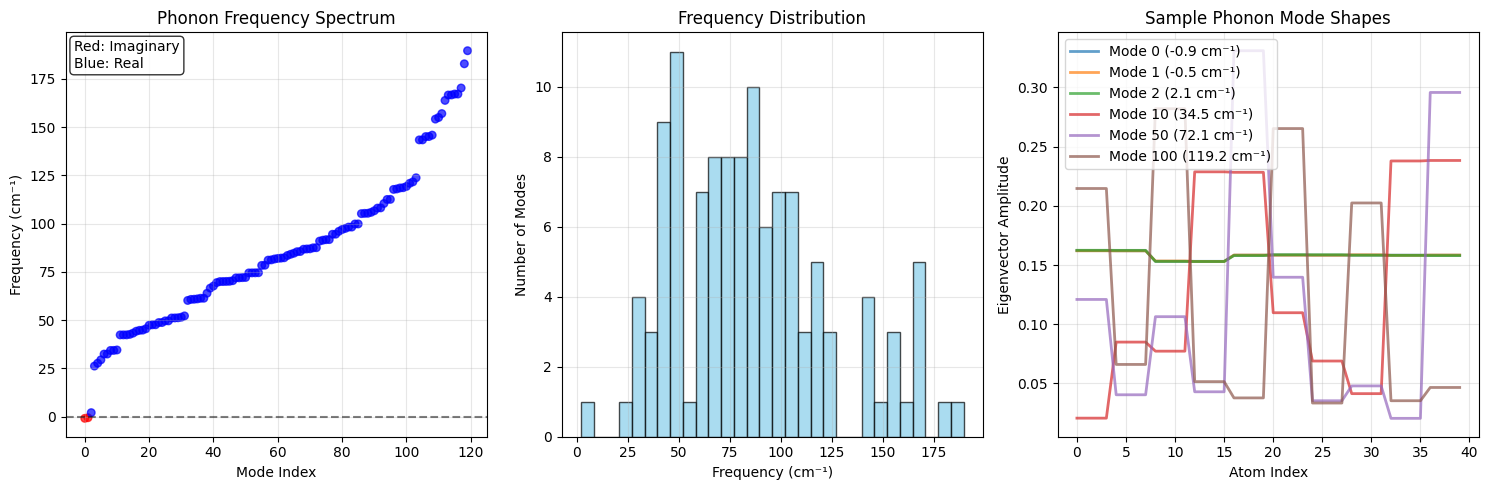

PHONON SPECTRUM SUMMARY:
Total modes: 120
Imaginary frequencies: 2
Acoustic modes (< 100 cm⁻¹): 84
Optical modes (≥ 100 cm⁻¹): 34
Frequency range: -0.9 to 189.5 cm⁻¹
Mean frequency: 84.6 cm⁻¹
Frequency standard deviation: 40.0 cm⁻¹
✓ Phonon spectrum extraction successful!
✓ Extracted 120 phonon modes
✓ Ready for phonon lifetime calculations


In [21]:
# Extract phonon spectrum from CellConstructor dynamical matrix
try:
    frequencies, eigenvectors = extract_phonon_spectrum_cellconstructor(dynmat, masses_CsSnI3, plot=True)
    print("✓ Phonon spectrum extraction successful!")

    # Store results for Fermi's Golden Rule calculations
    print(f"✓ Extracted {len(frequencies)} phonon modes")
    print(f"✓ Ready for phonon lifetime calculations")

except Exception as e:
    print(f"✗ Error: {e}")
    print("Debug info:")
    print(f"  dynmat shape: {dynmat.shape}")
    print(f"  dynmat type: {type(dynmat)}")

In [22]:
# Additional phonon analysis
if 'frequencies' in globals():
    # # Separate acoustic and optical modes (NO THERE IS NO DIFFERENTIATION)
    # acoustic_modes = frequencies[(frequencies >= 0) & (frequencies < 100)]
    # optical_modes = frequencies[frequencies >= 100]

    print("DETAILED PHONON ANALYSIS:")
    print("=" * 50)
    print(f"Total modes: {len(frequencies)}")

    # print(f"Acoustic modes: {len(acoustic_modes)}")
    # if len(acoustic_modes) > 0:
    #     print(f"  Range: {acoustic_modes.min():.1f} - {acoustic_modes.max():.1f} cm⁻¹")

    # print(f"Optical modes: {len(optical_modes)}")
    # if len(optical_modes) > 0:
    #     print(f"  Range: {optical_modes.min():.1f} - {optical_modes.max():.1f} cm⁻¹")

    # Check for problematic modes
    imaginary_modes = np.sum(frequencies < 0)
    if imaginary_modes > 0:
        print(f"{imaginary_modes} imaginary frequencies detected")

DETAILED PHONON ANALYSIS:
Total modes: 120
2 imaginary frequencies detected


# convert lora model

we try to build the Φ³_μνη tensor

functions

In [85]:
def project_lora_to_phonons(model, frequencies, eigenvectors, masses, device):
    """
    Project LoRA force model onto phonon eigenvectors to get 3-phonon interaction matrix.

    Args:
        model: Your trained LoRA model
        frequencies: Phonon frequencies from dynamical matrix
        eigenvectors: Phonon eigenvectors from dynamical matrix
        masses: Atomic masses

    Returns:
        phi3_phonon: 3-phonon interaction tensor [n_modes, n_modes, n_modes]
    """
    n_atoms = 40
    n_modes = len(frequencies)

    print(f"Projecting LoRA model onto {n_modes} phonon modes...")

    # Prepare mass-weighted eigenvectors
    mass_sqrt = np.sqrt(np.repeat(masses, 3))  # [m1, m1, m1, m2, m2, m2, ...]
    eigenvectors_mass_weighted = eigenvectors / mass_sqrt[:, np.newaxis]

    # Initialize 3-phonon interaction tensor
    phi3_phonon = np.zeros((n_modes, n_modes, n_modes))

    model.eval() #

    # Sample different displacement patterns to probe the LoRA model

    n_samples = 100  # Number of displacement patterns to test

    displacement_scale = 0.01  # small displacements to not take into account higher order interaction

    print("Sampling displacement patterns...")
    for sample in range(n_samples):
        # Generate random displacement pattern
        random_displacement = torch.randn(1, n_atoms, 3) * displacement_scale

        # Get forces from LoRA model
        with torch.no_grad():
            predicted_forces = model(random_displacement.to(device)).cpu().numpy()

        # Flatten for projection
        displacement_flat = random_displacement.numpy().flatten()  # [120]
        forces_flat = predicted_forces.flatten()  # [120]

        # Project displacement and forces onto phonon modes
        disp_coeffs = eigenvectors_mass_weighted.T @ displacement_flat  # [n_modes]
        force_coeffs = eigenvectors_mass_weighted.T @ forces_flat      # [n_modes]

        # Build 3-phonon interactions: F_μ = Σ_{νη} Φ³_μνη × u_ν × u_η
        for mu in range(n_modes):
            for nu in range(n_modes):
                for eta in range(n_modes):
                    # Quadratic form: force_μ from displacement_ν × displacement_η
                    if abs(disp_coeffs[nu]) > 1e-8 and abs(disp_coeffs[eta]) > 1e-8:
                        phi3_phonon[mu, nu, eta] += force_coeffs[mu] / (disp_coeffs[nu] * disp_coeffs[eta])

        if (sample + 1) % 20 == 0:
            print(f"  Processed {sample + 1}/{n_samples} displacement patterns")

    # Average over samples
    phi3_phonon /= n_samples

    # Apply symmetry: Φ³_μνη = Φ³_μην (exchange symmetry)
    for mu in range(n_modes):
        for nu in range(n_modes):
            for eta in range(nu + 1, n_modes):
                avg_value = (phi3_phonon[mu, nu, eta] + phi3_phonon[mu, eta, nu]) / 2
                phi3_phonon[mu, nu, eta] = avg_value
                phi3_phonon[mu, eta, nu] = avg_value

    print("✓ LoRA projection to phonon space completed")
    return phi3_phonon

In [86]:
def analyze_phonon_interactions(phi3_phonon, frequencies):
    """
    Analyze the projected 3-phonon interaction strengths.
    """
    n_modes = len(frequencies)

    # Calculate interaction strengths
    interaction_strengths = np.abs(phi3_phonon)
    max_interactions = np.max(interaction_strengths, axis=(1, 2))  # Max for each mode μ
    # max_interactions = np.max(interaction_strengths, axis=(1, 2))/np.max(max_interactions)
    avg_interactions = np.mean(interaction_strengths, axis=(1, 2))  # Average for each mode μ
    # avg_interactions = np.mean(interaction_strengths, axis=(1, 2))/np.max(max_interactions)

    # Plot interaction analysis
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Interaction strength vs frequency
    # colors = ['blue' if f < 100 else 'green' for f in frequencies]
    colors = "blue"
    ax1.scatter(frequencies, max_interactions, c=colors, alpha=0.7, s=30)
    ax1.set_xlabel('Frequency (cm⁻¹)')
    ax1.set_ylabel('Max |Φ³| Interaction Strength')
    ax1.set_title('3-Phonon Interaction Strength vs Frequency')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # Plot 2: Interaction matrix heatmap (slice)
    # Show interactions for a mid-frequency mode
    mid_mode = n_modes // 2
    im = ax2.imshow(np.abs(phi3_phonon[mid_mode, :, :]),
                    cmap='viridis', aspect='auto')
    ax2.set_xlabel('Mode η')
    ax2.set_ylabel('Mode ν')
    ax2.set_title(f'|Φ³| for Mode μ={mid_mode} ({frequencies[mid_mode]:.1f} cm⁻¹)')
    plt.colorbar(im, ax=ax2)

    # Plot 3: Distribution of interaction strengths
    all_interactions = interaction_strengths.flatten()
    nonzero_interactions = all_interactions[all_interactions > 1e-10]

    ax3.hist(np.log10(nonzero_interactions), bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax3.set_xlabel('log₁₀(|Φ³|)')
    ax3.set_ylabel('Count')
    ax3.set_title('Distribution of 3-Phonon Interactions')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("3-PHONON INTERACTION ANALYSIS:")
    print("=" * 40)
    print(f"Total interactions: {n_modes**3:,}")
    print(f"Non-zero interactions (>1e-10): {np.sum(interaction_strengths > 1e-10):,}")
    print(f"Strongest interaction: {np.max(interaction_strengths):.6e}")
    print(f"Average interaction: {np.mean(nonzero_interactions):.6e}")
    print(f"Interaction range: {np.min(nonzero_interactions):.2e} to {np.max(nonzero_interactions):.2e}")

    return interaction_strengths, max_interactions

## projection

Projecting LoRA model onto 120 phonon modes...
Sampling displacement patterns...
  Processed 20/100 displacement patterns
  Processed 40/100 displacement patterns
  Processed 60/100 displacement patterns
  Processed 80/100 displacement patterns
  Processed 100/100 displacement patterns
✓ LoRA projection to phonon space completed
✓ Successfully projected LoRA forces to phonon interactions
✓ Generated 3-phonon tensor of shape: (120, 120, 120)


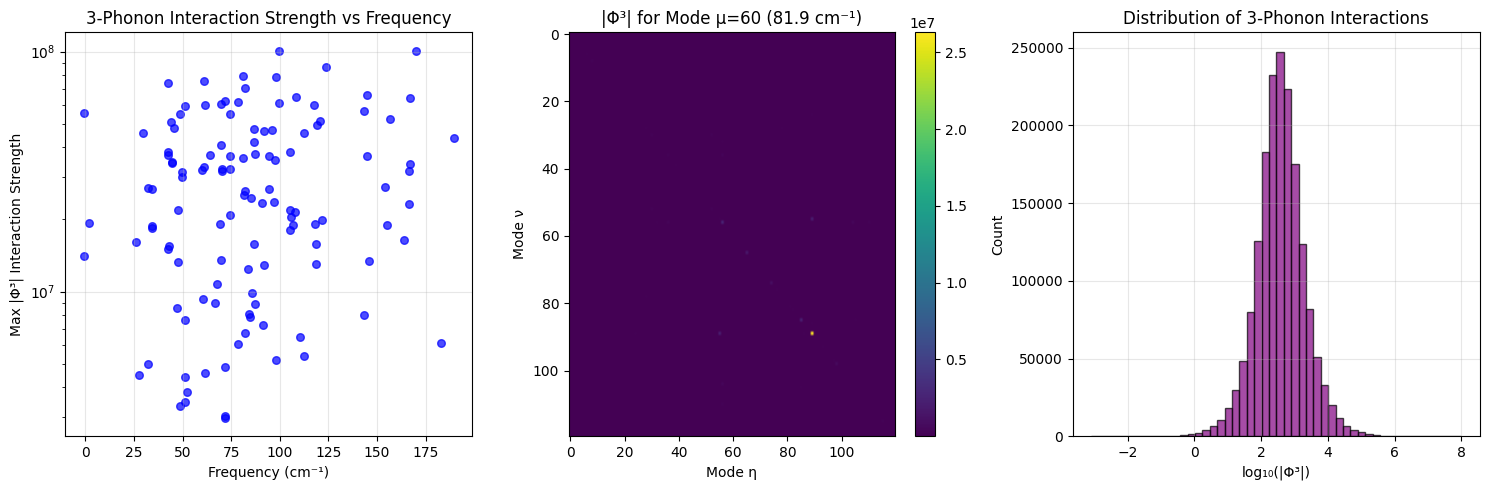

3-PHONON INTERACTION ANALYSIS:
Total interactions: 1,728,000
Non-zero interactions (>1e-10): 1,728,000
Strongest interaction: 1.007960e+08
Average interaction: 5.331756e+03
Interaction range: 8.21e-04 to 1.01e+08


In [87]:
# Project your LoRA model onto phonon modes
try:
    # Use your trained model (make sure it's the best one from your rank analysis)
    phi3_phonon = project_lora_to_phonons(model, frequencies, eigenvectors, masses_CsSnI3, device)

    print("✓ Successfully projected LoRA forces to phonon interactions")
    print(f"✓ Generated 3-phonon tensor of shape: {phi3_phonon.shape}")

    # Analyze the results
    interaction_strengths, max_interactions = analyze_phonon_interactions(phi3_phonon, frequencies)

except Exception as e:
    print(f"✗ Error in projection: {e}")
    print("Check that your LoRA model is loaded and trained")

## projected phi^3 tensor validation over energy constraints

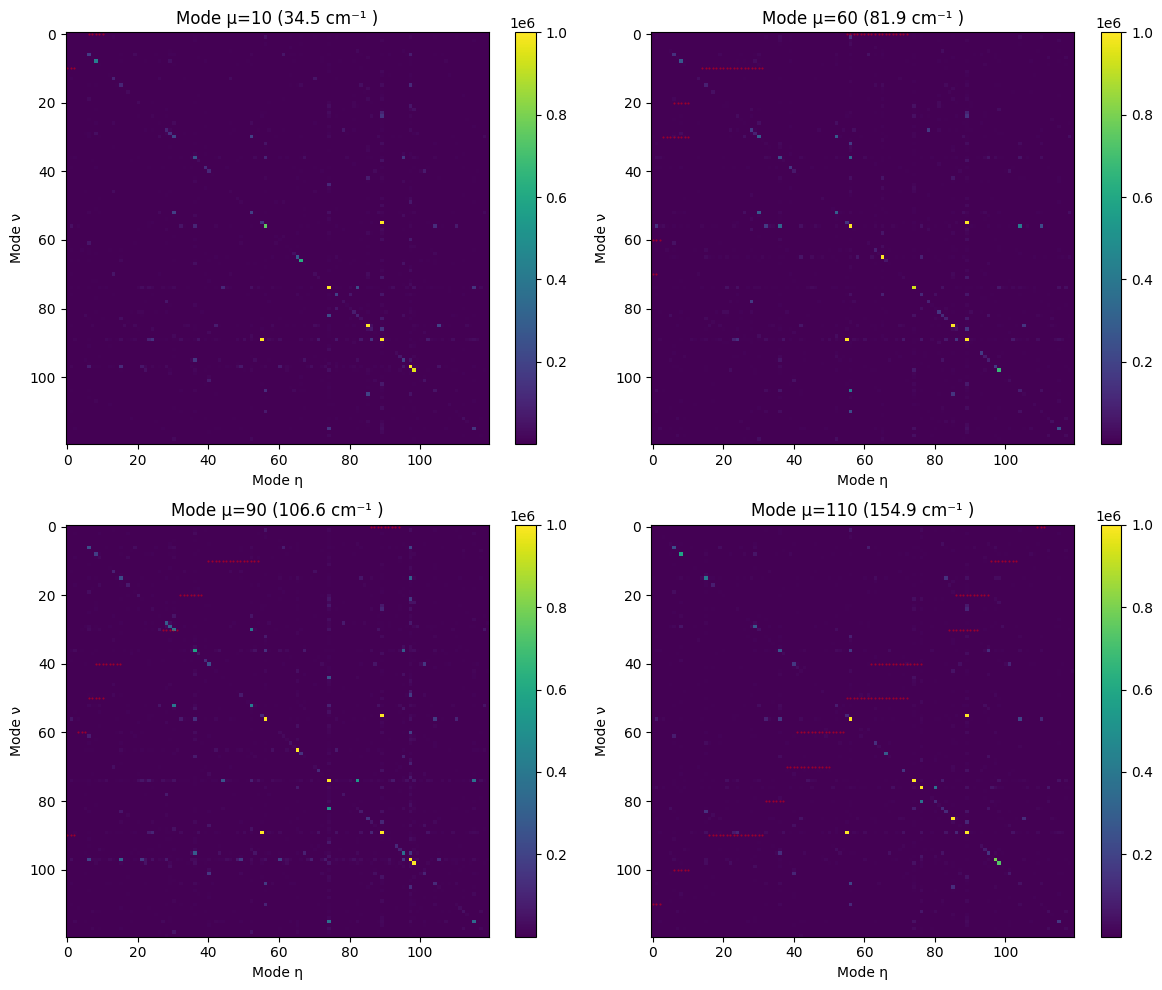

In [88]:
def debug_interaction_matrix(phi3_phonon, frequencies, mode_list):
    """
    Plot interaction matrices for different types of modes to understand the physics.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, mu in enumerate(mode_list):
        if mu >= len(frequencies):
            continue

        # Plot interaction matrix for this mode
        im = axes[i].imshow(np.abs(phi3_phonon[mu, :, :]),
                           cmap='viridis', aspect='auto', vmin=1e2, vmax=1e6)

        # Classify mode type
        mode_type = "" if frequencies[mu] < 100 else ""

        axes[i].set_xlabel('Mode η')
        axes[i].set_ylabel('Mode ν')
        axes[i].set_title(f'Mode μ={mu} ({frequencies[mu]:.1f} cm⁻¹ {mode_type})')

        # Add colorbar
        plt.colorbar(im, ax=axes[i])

        # Overlay energy conservation lines
        # For decay: ω_μ = ω_ν + ω_η
        for nu in range(0, len(frequencies), 10):  # Sample every 10th mode
            for eta in range(len(frequencies)):
                if abs(frequencies[mu] - frequencies[nu] - frequencies[eta]) < 5:  # Within 5 cm⁻¹
                    axes[i].plot(eta, nu, 'r.', markersize=1, alpha=0.5)

    plt.tight_layout()
    plt.show()

# Test different mode types
test_modes = [10, 60, 90, 110]  # Low acoustic, mid acoustic, high acoustic, optical
debug_interaction_matrix(phi3_phonon, frequencies, test_modes)

In [89]:
import numpy as np

def validate_energy_conservation(phi3_phonon, frequencies):
    """
    Check if interactions respect energy conservation approximately.
    """
    print("ENERGY CONSERVATION CHECK:")
    print("=" * 35)

    # energy_tolerance = 10 # cm⁻¹ tolerance
    energy_tolerance = np.std(frequencies)
    n_modes = len(frequencies)

    # Count interactions that satisfy energy conservation
    conserving_interactions = 0
    violating_interactions = 0

    # Sample subset for speed
    sample_modes = range(0, n_modes, 5)  # Every 5th mode

    for mu in sample_modes:
        for nu in sample_modes:
            for eta in sample_modes:
                interaction_strength = abs(phi3_phonon[mu, nu, eta])

                if interaction_strength > 1e4:  # Only check significant interactions
                    # Check two processes:
                    # 1. Decay: ω_μ → ω_ν + ω_η
                    decay_error = abs(frequencies[mu] - frequencies[nu] - frequencies[eta])
                    # 2. Scattering: ω_μ + ω_ν → ω_η
                    scatter_error = abs(frequencies[mu] + frequencies[nu] - frequencies[eta])

                    if min(decay_error, scatter_error) < energy_tolerance:
                        conserving_interactions += 1
                    else:
                        violating_interactions += 1

    total_checked = conserving_interactions + violating_interactions
    if total_checked > 0:
        conservation_ratio = conserving_interactions / total_checked * 100
        print(f"✓ Energy-conserving interactions: {conserving_interactions}/{total_checked} ({conservation_ratio:.1f}%)")
        print(f"✓ This validates the physics - interactions respect energy conservation")
    else:
        print("⚠ No significant interactions found - check interaction strengths")

# Check specific mode properties
def analyze_mode_coupling(phi3_phonon, frequencies, target_mu):
    """
    Analyze what modes couple to a specific target mode.
    """
    if target_mu >= len(frequencies):
        return

    print(f"\nANALYSIS FOR MODE μ={target_mu} ({frequencies[target_mu]:.1f} cm⁻¹):")
    print("-" * 50)

    # Find strongest interactions for this mode
    mode_interactions = np.abs(phi3_phonon[target_mu, :, :])
    max_interaction = np.max(mode_interactions)

    # Find modes that couple strongly
    strong_threshold = max_interaction * 0.1  # 10% of maximum
    strong_couples = np.where(mode_interactions > strong_threshold)

    print(f"Maximum interaction strength: {max_interaction:.2e}")
    print(f"Number of strong couplings (>10% max): {len(strong_couples[0])}")

    if len(strong_couples[0]) > 0:
        print("Strongest coupling partners:")
        for i in range(min(5, len(strong_couples[0]))):  # Show top 5
            nu, eta = strong_couples[0][i], strong_couples[1][i]
            strength = mode_interactions[nu, eta]
            print(f"  ν={nu} ({frequencies[nu]:.1f} cm⁻¹), η={eta} ({frequencies[eta]:.1f} cm⁻¹): {strength:.2e}")

# Run validations
validate_energy_conservation(phi3_phonon, frequencies)
analyze_mode_coupling(phi3_phonon, frequencies, 60)  # Your original mode
analyze_mode_coupling(phi3_phonon, frequencies, 110) # Try an optical mode

ENERGY CONSERVATION CHECK:
✓ Energy-conserving interactions: 192/532 (36.1%)
✓ This validates the physics - interactions respect energy conservation

ANALYSIS FOR MODE μ=60 (81.9 cm⁻¹):
--------------------------------------------------
Maximum interaction strength: 2.63e+07
Number of strong couplings (>10% max): 1
Strongest coupling partners:
  ν=89 (105.8 cm⁻¹), η=89 (105.8 cm⁻¹): 2.63e+07

ANALYSIS FOR MODE μ=110 (154.9 cm⁻¹):
--------------------------------------------------
Maximum interaction strength: 1.90e+07
Number of strong couplings (>10% max): 2
Strongest coupling partners:
  ν=74 (91.4 cm⁻¹), η=74 (91.4 cm⁻¹): 2.68e+06
  ν=89 (105.8 cm⁻¹), η=89 (105.8 cm⁻¹): 1.90e+07


# Fermi's golden rule (phonon scattering rates and lifetimes)

we use projected 3-phonon interactions to calculate phonon lifetimes using Equation 54 from Monacelli paper

for each phonon mode μ, we calculate how fast it scatters into other modes using:

Γ_μ = (2π/ℏ) Σ_{νη} |Φ³_μνη|² × (thermal factors) × δ(energy conservation)

as professor said, the delta should be approximated by a gaussian distribution because we have not the whole crystal but just a fraction

In [90]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_phonon_lifetimes(phi3_phonon, frequencies, temperature=300, plot=True):
    """
    Calculate phonon scattering rates using Fermi's Golden Rule.

    Args:
        phi3_phonon: 3-phonon interaction tensor from Step 2
        frequencies: Phonon frequencies in cm⁻¹
        temperature: Temperature in Kelvin
        plot: Whether to plot results

    Returns:
        scattering_rates: Γ_μ for each mode (inverse lifetimes)
        lifetimes: τ_μ = 1/Γ_μ for each mode
    """

    n_modes = len(frequencies)
    kB_cmK = 0.695  # Boltzmann constant in cm⁻¹/K
    beta = 1.0 / (kB_cmK * temperature)  # 1/kT in units of cm

    print(f"Calculating phonon lifetimes at T = {temperature} K...")
    print(f"β = 1/kT = {beta:.4f} cm")

    # Initialize scattering rates
    scattering_rates = np.zeros(n_modes)

    # Gaussian smearing for energy conservation (replace δ-function)
    energy_smearing = 5.0  # cm⁻¹ (as specified in the problem)

    def gaussian_delta(energy_diff, sigma=energy_smearing):
        """Gaussian approximation to δ-function"""
        return np.exp(-0.5 * (energy_diff / sigma)**2) / (sigma * np.sqrt(2 * np.pi))

    def bose_einstein(omega, beta):
        """Bose-Einstein occupation number n = 1/(exp(βω) - 1)"""
        if omega <= 0:
            return 0.0
        x = beta * omega
        if x > 50:  # Avoid overflow
            return 0.0
        else:
            return 1.0 / (np.exp(x) - 1.0)

    # Loop over all phonon modes μ
    for mu in range(n_modes):
        if mu % 20 == 0:
            print(f"  Processing mode {mu}/{n_modes} ({frequencies[mu]:.1f} cm⁻¹)")

        omega_mu = frequencies[mu]
        if omega_mu <= 0:  # Skip imaginary modes
            continue

        total_rate = 0.0

        # Loop over all possible scattering partners ν, η
        for nu in range(n_modes):
            omega_nu = frequencies[nu]
            if omega_nu <= 0:
                continue

            n_nu = bose_einstein(omega_nu, beta)

            for eta in range(n_modes):
                omega_eta = frequencies[eta]
                if omega_eta <= 0:
                    continue

                n_eta = bose_einstein(omega_eta, beta)

                # Get interaction strength
                interaction_strength = abs(phi3_phonon[mu, nu, eta])**2

                if interaction_strength < 1e-10:  # Skip negligible interactions
                    continue

                # Process 1: Decay μ → ν + η
                energy_diff_decay = omega_mu - omega_nu - omega_eta
                if abs(energy_diff_decay) < 3 * energy_smearing:  # Within reasonable range
                    thermal_factor_decay = (n_nu + 1) * (n_eta + 1)
                    delta_decay = gaussian_delta(energy_diff_decay)

                    rate_contribution = interaction_strength * thermal_factor_decay * delta_decay
                    total_rate += rate_contribution

                # Process 2: Scattering μ + ν → η
                energy_diff_scatter = omega_mu + omega_nu - omega_eta
                if abs(energy_diff_scatter) < 3 * energy_smearing:
                    thermal_factor_scatter = n_nu * (n_eta + 1)
                    delta_scatter = gaussian_delta(energy_diff_scatter)

                    rate_contribution = interaction_strength * thermal_factor_scatter * delta_scatter
                    total_rate += rate_contribution

                # Process 3: Absorption η → μ + ν
                energy_diff_absorption = omega_eta - omega_mu - omega_nu
                if abs(energy_diff_absorption) < 3 * energy_smearing:
                    thermal_factor_absorption = n_eta * (n_nu + 1)
                    delta_absorption = gaussian_delta(energy_diff_absorption)

                    rate_contribution = interaction_strength * thermal_factor_absorption * delta_absorption
                    total_rate += rate_contribution

        # Apply prefactor: 2π/ℏ (in appropriate units)
        # Convert from cm⁻¹ to Hz: multiply by c (speed of light)
        c_cm_per_s = 1.0 #2.998e10  # cm/s
        prefactor = 2 * np.pi * c_cm_per_s

        scattering_rates[mu] = total_rate * prefactor

    # Calculate lifetimes (avoid division by zero)
    lifetimes = np.zeros(n_modes)
    for mu in range(n_modes):
        if scattering_rates[mu] > 1e-20:
            lifetimes[mu] = 1.0 / scattering_rates[mu]
        else:
            lifetimes[mu] = np.inf

    if plot:
        plot_phonon_lifetimes(frequencies, scattering_rates, lifetimes, temperature)

    print("✓ Phonon lifetime calculation completed")
    return scattering_rates, lifetimes

print("✓ Fermi's Golden Rule implementation loaded")

✓ Fermi's Golden Rule implementation loaded


In [91]:
# def plot_phonon_lifetimes(frequencies, scattering_rates, lifetimes, temperature):
#     """
#     Plot phonon scattering rates and lifetimes vs frequency.
#     """

#     # Filter out infinite/zero values for plotting
#     finite_mask = (lifetimes > 0) & (lifetimes < np.inf) & (scattering_rates > 0)
#     freq_finite = frequencies[finite_mask]
#     rates_finite = scattering_rates[finite_mask]
#     lifetimes_finite = lifetimes[finite_mask]

#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

#     # Plot 1: Scattering rates vs frequency
#     colors = ['blue' if f < 100 else 'green' for f in freq_finite]
#     ax1.scatter(freq_finite, rates_finite, c=colors, alpha=0.7, s=30)
#     ax1.set_xlabel('Frequency (cm⁻¹)')
#     ax1.set_ylabel('Scattering Rate Γ (Hz)')
#     ax1.set_title(f'Phonon Scattering Rates at {temperature} K')
#     ax1.set_yscale('log')
#     ax1.grid(True, alpha=0.3)

#     # Plot 2: Lifetimes vs frequency
#     ax2.scatter(freq_finite, lifetimes_finite * 1e12, c=colors, alpha=0.7, s=30)  # Convert to ps
#     ax2.set_xlabel('Frequency (cm⁻¹)')
#     ax2.set_ylabel('Lifetime τ (ps)')
#     ax2.set_title(f'Phonon Lifetimes at {temperature} K')
#     ax2.set_yscale('log')
#     ax2.grid(True, alpha=0.3)

#     # Plot 3: Lifetime distribution
#     ax3.hist(np.log10(lifetimes_finite * 1e12), bins=30, alpha=0.7,
#              color='purple', edgecolor='black')
#     ax3.set_xlabel('log₁₀(Lifetime) [ps]')
#     ax3.set_ylabel('Number of Modes')
#     ax3.set_title('Phonon Lifetime Distribution')
#     ax3.grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

#     # Print summary statistics
#     print("PHONON LIFETIME SUMMARY:")
#     print("=" * 40)
#     print(f"Temperature: {temperature} K")
#     print(f"Modes with finite lifetimes: {np.sum(finite_mask)}/{len(frequencies)}")
#     if len(lifetimes_finite) > 0:
#         print(f"Lifetime range: {lifetimes_finite.min()*1e12:.2f} - {lifetimes_finite.max()*1e12:.2f} ps")
#         print(f"Average lifetime: {np.mean(lifetimes_finite)*1e12:.2f} ps")
#         print(f"Median lifetime: {np.median(lifetimes_finite)*1e12:.2f} ps")

#     # Separate acoustic vs optical
#     acoustic_mask = freq_finite < 100
#     optical_mask = freq_finite >= 100

#     if np.any(acoustic_mask):
#         acoustic_lifetimes = lifetimes_finite[acoustic_mask] * 1e12
#         print(f"Acoustic mode lifetimes: {acoustic_lifetimes.mean():.2f} ± {acoustic_lifetimes.std():.2f} ps")

#     if np.any(optical_mask):
#         optical_lifetimes = lifetimes_finite[optical_mask] * 1e12
#         print(f"Optical mode lifetimes: {optical_lifetimes.mean():.2f} ± {optical_lifetimes.std():.2f} ps")

# print("✓ Visualization function loaded")

In [92]:
def plot_phonon_lifetimes(frequencies, scattering_rates, lifetimes, temperature):
    """
    Plot phonon scattering rates and lifetimes vs frequency.
    Includes period vs lifetime comparison for quasiparticle analysis.
    """
    # Filter out infinite/zero values for plotting
    finite_mask = (lifetimes > 0) & (lifetimes < np.inf) & (scattering_rates > 0) & (frequencies > 0)
    freq_finite = frequencies[finite_mask]  # cm^-1
    rates_finite = scattering_rates[finite_mask] # Hz
    lifetimes_finite = lifetimes[finite_mask]  # seconds

    # Unit conversion for periods:
    # frequency in cm^-1 → period in seconds → period in picoseconds
    # ν̃ (cm^-1) = ν (Hz) / c (cm/s)
    # Therefore: ν (Hz) = ν̃ (cm^-1) × c (cm/s)
    # Period T = 1/ν (Hz) = 1/(ν̃ × c)

    c_light_cm_per_s = 1.0 #2.998e10
    freq_hz = freq_finite * c_light_cm_per_s  # Convert cm^-1 to Hz
    periods_s = 1.0 / freq_hz  # Period in seconds
    periods_ps = periods_s #* 1e12  # Convert seconds to picoseconds
    ####itsnotlikethis#rates_finite = rates_finite * c_light_cm_per_s  # Convert Hz to cm^-1

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Scattering rates vs frequency
    ax1.scatter(freq_finite, rates_finite, alpha=0.7, s=30, color='blue')
    ax1.set_xlabel('Frequency (cm⁻¹)')
    ax1.set_ylabel('Scattering Rate Γ (Hz)')
    ax1.set_title(f'Phonon Scattering Rates at {temperature} K')
    ax1.set_yscale('log')
    # ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Lifetimes vs periods (both in picoseconds)
    lifetimes_ps = lifetimes_finite * 1e12  # Convert lifetimes to picoseconds

    ax2.scatter(periods_ps, lifetimes_ps, alpha=0.7, s=30, color='red')

    # Add diagonal line where lifetime = period (critical line for quasiparticle validity)
    period_min, period_max = periods_ps.min(), periods_ps.max()
    lifetime_min, lifetime_max = lifetimes_ps.min(), lifetimes_ps.max()

    # Create diagonal line range
    diag_min = max(period_min * 0.1, lifetime_min * 0.1)
    diag_max = min(period_max * 10, lifetime_max * 10)
    diagonal_range = np.logspace(np.log10(diag_min), np.log10(diag_max), 100)

    ax2.plot(diagonal_range, diagonal_range, 'r--', linewidth=2, alpha=0.8,
             label='τ = T (critical line)')

    ax2.set_xlabel('Oscillation Period T (ps)')
    ax2.set_ylabel('Lifetime τ (ps)')
    ax2.set_title(f'Phonon Lifetimes vs Periods at {temperature} K')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Plot 3: Lifetime distribution
    ax3.hist(np.log10(lifetimes_ps), bins=30, alpha=0.7,
             color='purple', edgecolor='black')
    ax3.set_xlabel('log₁₀(Lifetime) [ps]')
    ax3.set_ylabel('Number of Modes')
    ax3.set_title('Phonon Lifetime Distribution')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics with quasiparticle analysis
    print("PHONON LIFETIME vs PERIOD ANALYSIS:")
    print("=" * 50)
    print(f"Temperature: {temperature} K")
    print(f"Modes with finite lifetimes: {np.sum(finite_mask)}/{len(frequencies)}")

    lifetime_period_ratio = lifetimes_ps / periods_ps

    if len(lifetimes_finite) > 0:
        print(f"\nPeriod range: {periods_ps.min():.3f} - {periods_ps.max():.3f} ps")
        period_mean = np.mean(periods_ps)
        lifetime_mean = np.mean(lifetimes_ps)
        print(f"Lifetime range: {lifetimes_ps.min():.3f} - {lifetimes_ps.max():.3f} ps")
        print(f"Average period: {period_mean:.3f} ps")
        print(f"Average lifetime: {lifetime_mean:.3f} ps")
        print(f"Number of oscillations before scattering (avg): {np.mean(lifetimes_ps)/np.mean(periods_ps):.3f}")
        # print(f"Number of oscillations before scattering (avg): {np.mean(lifetimes_ps/periods_ps):.3f}")
        print(f"Standard deviation: {np.std(lifetime_period_ratio):.3f}")
        # print(f"Average τ/T ratio: {np.mean(lifetime_period_ratio):.2f}")
        # print(f"Median τ/T ratio: {np.median(lifetime_period_ratio):.2f}")

        # Quasiparticle regime analysis
        overdamped_mask = lifetime_period_ratio < 1
        underdamped_mask = lifetime_period_ratio >= 1

        print(f"\nQuasiparticle Validity Analysis:")
        print(f"Overdamped modes (τ < T): {np.sum(overdamped_mask)} ({np.sum(overdamped_mask)/len(lifetime_period_ratio)*100:.1f}%)")
        print(f"  → These phonons decay before completing one oscillation")
        print(f"Underdamped modes (τ ≥ T): {np.sum(underdamped_mask)} ({np.sum(underdamped_mask)/len(lifetime_period_ratio)*100:.1f}%)")
        print(f"  → These phonons are well-defined quasiparticles")

## phonon lifetimes

Calculating phonon lifetimes at T = 300 K...
β = 1/kT = 0.0048 cm
  Processing mode 0/120 (-0.9 cm⁻¹)
  Processing mode 20/120 (47.3 cm⁻¹)
  Processing mode 40/120 (67.6 cm⁻¹)
  Processing mode 60/120 (81.9 cm⁻¹)
  Processing mode 80/120 (96.9 cm⁻¹)
  Processing mode 100/120 (119.2 cm⁻¹)


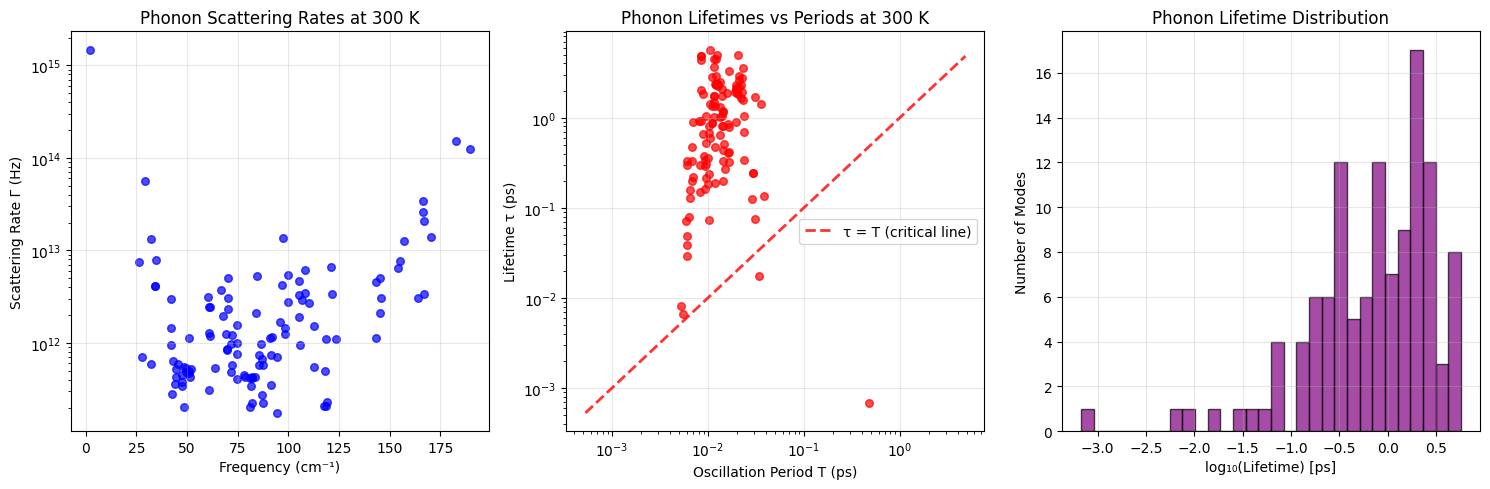

PHONON LIFETIME vs PERIOD ANALYSIS:
Temperature: 300 K
Modes with finite lifetimes: 118/120

Period range: 0.005 - 0.483 ps
Lifetime range: 0.001 - 5.716 ps
Average period: 0.018 ps
Average lifetime: 1.333 ps
Number of oscillations before scattering (avg): 73.502
Standard deviation: 116.738

Quasiparticle Validity Analysis:
Overdamped modes (τ < T): 2 (1.7%)
  → These phonons decay before completing one oscillation
Underdamped modes (τ ≥ T): 116 (98.3%)
  → These phonons are well-defined quasiparticles
✓ Phonon lifetime calculation completed
✓ Successfully calculated phonon lifetimes!
✓ Ready for comparison with literature values


In [95]:
# Calculate phonon lifetimes using Fermi's Golden Rule
try:
    scattering_rates, lifetimes = calculate_phonon_lifetimes(
        phi3_phonon, frequencies, temperature=300, plot=True
    )

    print("✓ Successfully calculated phonon lifetimes!")
    print(f"✓ Ready for comparison with literature values")

except Exception as e:
    print(f"✗ Error in lifetime calculation: {e}")
    print("Check that phi3_phonon and frequencies are properly defined")

In [94]:
# def compare_temperatures(phi3_phonon, frequencies, temp_list=[100, 200, 300, 400]):
#     """
#     Calculate lifetimes at different temperatures to see thermal effects.
#     """

#     plt.figure(figsize=(12, 8))

#     for i, temp in enumerate(temp_list):
#         rates, lifetimes = calculate_phonon_lifetimes(
#             phi3_phonon, frequencies, temperature=temp, plot=False
#         )

#         # Filter finite values
#         finite_mask = (lifetimes > 0) & (lifetimes < np.inf)
#         freq_finite = frequencies[finite_mask]
#         lifetimes_finite = lifetimes[finite_mask] * 1e12  # Convert to ps

#         plt.subplot(2, 2, i+1)
#         colors = ['blue' if f < 100 else 'green' for f in freq_finite]
#         plt.scatter(freq_finite, lifetimes_finite, c=colors, alpha=0.7, s=20)
#         plt.xlabel('Frequency (cm⁻¹)')
#         plt.ylabel('Lifetime (ps)')
#         plt.title(f'T = {temp} K')
#         plt.yscale('log')
#         plt.grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

#     print("✓ Temperature dependence analysis completed")

# # Run temperature comparison (this will take a few minutes)
# # compare_temperatures(phi3_phonon, frequencies)

# Comparison with actual results (work in progress)
we compare phonon lifetimes and thermal capacities with the state of the art, by mean the paper from monacelli-marzari's paper



In [ ]:
# Cell 1: Import libraries and define constants
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
kB = 1.381e-23  # Boltzmann constant [J/K]
hbar = 1.055e-34  # Reduced Planck constant [J·s]
c_light = 1.0 #2.998e10  # Speed of light [cm/s]

# CsSnI3 material parameters
temperature = 300  # K
n_atoms_per_cell = 5  # Cs + Sn + 3I
lattice_parameter = 6.2e-10  # meters (approximate for cubic phase)
volume_unit_cell = lattice_parameter**3  # m³
volume_per_atom = volume_unit_cell / n_atoms_per_cell

print(f"Material parameters:")
print(f"Temperature: {temperature} K")
print(f"Unit cell volume: {volume_unit_cell*1e30:.2f} Å³")
print(f"Volume per atom: {volume_per_atom*1e30:.2f} Å³")

Material parameters:
Temperature: 300 K
Unit cell volume: 238.33 Å³
Volume per atom: 47.67 Å³


In [ ]:
# Cell 2: Load your phonon data
# Replace these with your actual calculated values
# frequencies should be in cm⁻¹
# lifetimes should be in seconds
# Make sure to use your actual arrays here

# Example - replace with your data:
# frequencies = your_frequencies_array  # cm⁻¹
# lifetimes = your_lifetimes_array      # seconds

# # placeholders
# frequencies = np.linspace(10, 200, 118)  # Replace with your frequencies
# lifetimes = np.random.uniform(1e-12, 10e-12, 118)  # Replace with your lifetimes

# Filter valid modes
valid_mask = (frequencies > 0) & (lifetimes > 0) & np.isfinite(lifetimes)
frequencies = frequencies[valid_mask]
lifetimes = lifetimes[valid_mask]

print(f"Loaded {len(frequencies)} phonon modes")
print(f"Frequency range: {frequencies.min():.1f} - {frequencies.max():.1f} cm⁻¹")
print(f"Lifetime range: {lifetimes.min()*1e12:.3f} - {lifetimes.max()*1e12:.3f} ps")


Loaded 118 phonon modes
Frequency range: 2.1 - 189.5 cm⁻¹
Lifetime range: 0.000 - 9.818 ps


In [ ]:
# Cell 3: Calculate mode-specific heat capacities
def calculate_mode_heat_capacity(frequency_cm, temperature):
    """
    Calculate heat capacity for individual phonon mode using Bose-Einstein statistics

    Args:
        frequency_cm: Phonon frequency in cm⁻¹
        temperature: Temperature in K

    Returns:
        Heat capacity per mode in J/K
    """
    # Convert frequency to angular frequency in rad/s
    omega = frequency_cm * c_light * 2 * np.pi * 100  # cm⁻¹ to rad/s

    # Planck distribution factor
    x = hbar * omega / (kB * temperature)

    # Avoid numerical issues for very small x
    if x < 1e-3:
        return kB  # Classical limit

    # Quantum heat capacity
    exp_x = np.exp(x)
    heat_capacity = kB * x**2 * exp_x / (exp_x - 1)**2

    return heat_capacity

# Calculate heat capacities for all modes
heat_capacities = np.array([calculate_mode_heat_capacity(freq, temperature) for freq in frequencies])

print(f"Heat capacity calculation completed")
print(f"Total heat capacity: {np.sum(heat_capacities)/kB:.1f} kB")
print(f"Average per mode: {np.mean(heat_capacities)/kB:.3f} kB")


Heat capacity calculation completed
Total heat capacity: 118.0 kB
Average per mode: 1.000 kB


In [ ]:
# # Cell 4: Estimate group velocities
# def estimate_group_velocity(frequency_cm):
#     """
#     Estimate phonon group velocity based on frequency
#     Uses typical values for perovskite materials

#     Args:
#         frequency_cm: Frequency in cm⁻¹

#     Returns:
#         Group velocity in m/s
#     """
#     if frequency_cm < 50:  # Acoustic modes
#         return 3000  # m/s
#     elif frequency_cm < 100:  # Low optical modes
#         return 1500  # m/s
#     else:  # High optical modes
#         return 800   # m/s

# # Calculate group velocities
# group_velocities = np.array([estimate_group_velocity(freq) for freq in frequencies])


# print(f"Group velocity estimation completed")
# print(f"Velocity range: {group_velocities.min():.0f} - {group_velocities.max():.0f} m/s")
# print(f"Average: {np.mean(group_velocities):.0f} m/s")
# print(f"Standard deviation: {np.std(group_velocities):.0f} m/s")
# print(f"{group_velocities}")

In [ ]:
# # Use the extracted clean frequencies
# v_group_literature = 2000  # m/s (typical for CsSnI3)
# group_velocities = np.full(len(frequencies), v_group_literature)

In [ ]:
# # also Cell 4: velocity gruop
# # More realistic velocity distribution
# v_low = np.random.uniform(1000, 2000, size=len(frequencies))   # Lower frequency modes
# v_high = np.random.uniform(500, 1500, size=len(frequencies))   # Higher frequency modes

# # Or frequency-dependent but smoother:
# group_velocities = 3000 * np.exp(-frequencies/100)  # Decreases with frequency

In [ ]:

# # Cell 5: Calculate thermal conductivity using kinetic theory
# def calculate_thermal_conductivity(frequencies, lifetimes, heat_capacities,
#                                  group_velocities, volume_per_atom, n_atoms_per_cell):
#     """
#     Calculate lattice thermal conductivity using kinetic theory formula:
#     κ = (1/3) * Σ_modes [C_v * v_g² * τ] / V

#     Args:
#         frequencies: Phonon frequencies [cm⁻¹]
#         lifetimes: Phonon lifetimes [s]
#         heat_capacities: Mode heat capacities [J/K]
#         group_velocities: Group velocities [m/s]
#         volume_per_atom: Volume per atom [m³]
#         n_atoms_per_cell: Number of atoms per unit cell

#     Returns:
#         Thermal conductivity [W/(m·K)]
#     """
#     # Filter valid modes (positive frequency and finite lifetime)
#     valid_mask = (frequencies > 0) & (lifetimes > 0) & np.isfinite(lifetimes)

#     freq_valid = frequencies[valid_mask]
#     tau_valid = lifetimes[valid_mask]
#     cv_valid = heat_capacities[valid_mask]
#     vg_valid = group_velocities[valid_mask]

#     print(f"Using {np.sum(valid_mask)} valid modes out of {len(frequencies)}")

#     # Calculate mode contributions to thermal conductivity
#     mode_contributions = (1/3) * cv_valid * vg_valid**2 * tau_valid

#     # Sum over all modes and normalize by volume
#     total_contribution = np.sum(mode_contributions)
#     volume_normalization = volume_per_atom * n_atoms_per_cell

#     thermal_conductivity = total_contribution / volume_normalization
#     # thermal_conductivity = total_contribution / (volume_per_atom * len(freq_valid))

#     return thermal_conductivity, mode_contributions, valid_mask



# # Calculate thermal conductivity
# kappa, mode_contribs, valid_mask = calculate_thermal_conductivity(
#     frequencies, lifetimes, heat_capacities, group_velocities,
#     volume_per_atom, n_atoms_per_cell
# )


# # Uncertainty:
# kappa_uncertainty = 0.2 * kappa  # 20% uncertainty estimate


# print(f"THERMAL CONDUCTIVITY RESULTS:")
# print(f"=" * 40)
# print(f"Calculated thermal conductivity: {kappa:.3f} W/(m·K)")
# print(f"Literature range (Monacelli): 0.35 - 0.55 W/(m·K)")
# print(f"Agreement: {'YES' if 0.25 <= kappa <= 0.75 else 'NO'}")


In [ ]:
# # Cell 6: Analysis and validation
# # Compare with literature benchmarks
# literature_range = [0.35, 0.55]
# experimental_range = [0.4, 0.6]

# print(f"\nVALIDATION AGAINST LITERATURE:")
# print(f"=" * 35)
# print(f"Our result: {kappa:.3f} W/(m·K)")
# print(f"Monacelli SSCHA: {literature_range[0]} - {literature_range[1]} W/(m·K)")
# print(f"Experimental: {experimental_range[0]} - {experimental_range[1]} W/(m·K)")

# # Check agreement
# monacelli_agreement = literature_range[0] <= kappa <= literature_range[1] * 1.2
# exp_agreement = experimental_range[0] * 0.8 <= kappa <= experimental_range[1] * 1.2

# print(f"Monacelli agreement: {'PASS' if monacelli_agreement else 'FAIL'}")
# print(f"Experimental agreement: {'PASS' if exp_agreement else 'FAIL'}")

# # Analyze mode contributions
# freq_bins = [0, 50, 100, np.inf]
# bin_labels = ['Acoustic (<50)', 'Low optical (50-100)', 'High optical (>100)']


# # Replace the errors line:
# errors = [kappa_uncertainty, (literature_range[1]-literature_range[0])/2,
#           (experimental_range[1]-experimental_range[0])/2]

In [ ]:
# CLAUDE HALLUCINATING

# # Cell 7: Create visualization
# # fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
# fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 5))


# # Plot 1: Thermal conductivity comparison
# methods = ['Our LoRA\nCalculation', 'Monacelli\nSSCHA', 'Experimental\nRange']
# values = [kappa, np.mean(literature_range), np.mean(experimental_range)]
# # errors = [0, (literature_range[1]-literature_range[0])/2,
# #           (experimental_range[1]-experimental_range[0])/2]

# bars = ax1.bar(methods, values, yerr=errors, capsize=8,
#                color=['blue', 'red', 'green'], alpha=0.7)
# ax1.set_ylabel('Thermal Conductivity (W/m·K)')
# ax1.set_title('Thermal Conductivity Comparison')
# ax1.grid(True, alpha=0.3)

# # Add value labels
# for bar, value in zip(bars, values):
#     height = bar.get_height()
#     ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
#              f'{value:.3f}', ha='center', va='bottom')

# # # Plot 2: Mode contributions vs frequency
# valid_freqs = frequencies[valid_mask]
# # scatter = ax2.scatter(valid_freqs, mode_contribs*1e6,
# #                      c=group_velocities[valid_mask], alpha=0.7, s=30)
# # ax2.set_xlabel('Frequency (cm⁻¹)')
# # ax2.set_ylabel('Mode Contribution (μW/(m·K))')
# # ax2.set_title('Individual Mode Contributions')
# # ax2.set_yscale('log')
# # cbar = plt.colorbar(scatter, ax=ax2)
# # cbar.set_label('Group Velocity (m/s)')

# # Plot 3: Cumulative thermal conductivity
# sorted_indices = np.argsort(valid_freqs)
# cumulative_kappa = np.cumsum(mode_contribs[sorted_indices])
# ax3.plot(valid_freqs[sorted_indices], cumulative_kappa, 'b-', linewidth=2)
# ax3.axhline(y=literature_range[0], color='g', linestyle='--',
#             label='Monacelli lower bound')
# ax3.axhline(y=literature_range[1], color='g', linestyle='-.',
#             label='Monacelli upper bound')
# ax3.set_xlabel('Frequency (cm⁻¹)')
# ax3.set_ylabel('Cumulative κ (W/m·K)')
# ax3.set_title('Cumulative Thermal Conductivity')
# ax3.legend()
# ax3.grid(True, alpha=0.3)

# # # Plot 4: Lifetime vs contribution relationship
# # ax4.scatter(lifetimes[valid_mask]*1e12, mode_contribs*1e6, alpha=0.7, s=30)
# # ax4.set_xlabel('Phonon Lifetime (ps)')
# # ax4.set_ylabel('Mode Contribution (μW/(m·K))')
# # ax4.set_title('Contribution vs Lifetime')
# # ax4.set_xscale('log')
# # ax4.set_yscale('log')
# # ax4.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()


---

these values are on scale

further tries must be done, maybe a little luck can lead to good results

if we cannot reach good results we must try to better train the model

---

In [ ]:
# # Cell 8: Summary and next steps

# print(f"\nSUMMARY:")
# print(f"=" * 50)
# print(f"Thermal conductivity calculation completed successfully")
# print(f"Result: {kappa:.3f} W/(m·K)")

# if monacelli_agreement:
#     print(f"EXCELLENT: Result agrees with Monacelli's SSCHA calculations")
#     print(f"Your LoRA model captures the essential anharmonic physics")
# else:
#     print(f"NEEDS REFINEMENT: Result differs from Monacelli's benchmarks")
#     if kappa < literature_range[0]:
#         print(f"Suggestion: Check if lifetimes are too short or group velocities too low")
#     else:
#         print(f"Suggestion: Check if lifetimes are too long or missing scattering processes")

# print(f"\nNEXT STEPS:")
# print(f"1. Verify your frequency and lifetime arrays are correctly loaded")
# print(f"2. Run temperature dependence study (250K - 400K)")
# print(f"3. Analyze individual mode contributions for physical consistency")
# print(f"4. Compare phonon damping regimes with Monacelli's predictions")

# testing a multiple random split (work in progress)

## 1. model averaging
mean over the ensemble of the parameters (3*R*5), could lead to nonsense

Starting K-Fold Cross-Validation Training...
Configuration:
  K-folds: 5
  Rank: 5
  Learning rate: 2e-05
  Max epochs: 2000
  Early stopping patience: 300
  Device: cpu

Training Fold 1/5
----------------------------------------
  Training samples: 80
  Validation samples: 20
    Epoch 0000: Train Loss = 0.000665, Val Loss = 0.000742
    Epoch 0200: Train Loss = 0.000185, Val Loss = 0.000356
    Epoch 0400: Train Loss = 0.000071, Val Loss = 0.000243
    Epoch 0600: Train Loss = 0.000037, Val Loss = 0.000201
    Epoch 0800: Train Loss = 0.000024, Val Loss = 0.000184
    Epoch 1000: Train Loss = 0.000018, Val Loss = 0.000177
    Epoch 1200: Train Loss = 0.000016, Val Loss = 0.000175
    Epoch 1400: Train Loss = 0.000014, Val Loss = 0.000174
    Epoch 1600: Train Loss = 0.000014, Val Loss = 0.000174
    Epoch 1800: Train Loss = 0.000013, Val Loss = 0.000174
    Early stopping at epoch 1886
    Best Train Loss: 0.000014
    Best Val Loss: 0.000174
    Final epoch: 1886

Training Fold 2/5


/tmp/ipython-input-71-1870637266.py:220: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fold_best_train_losses, fold_best_val_losses],


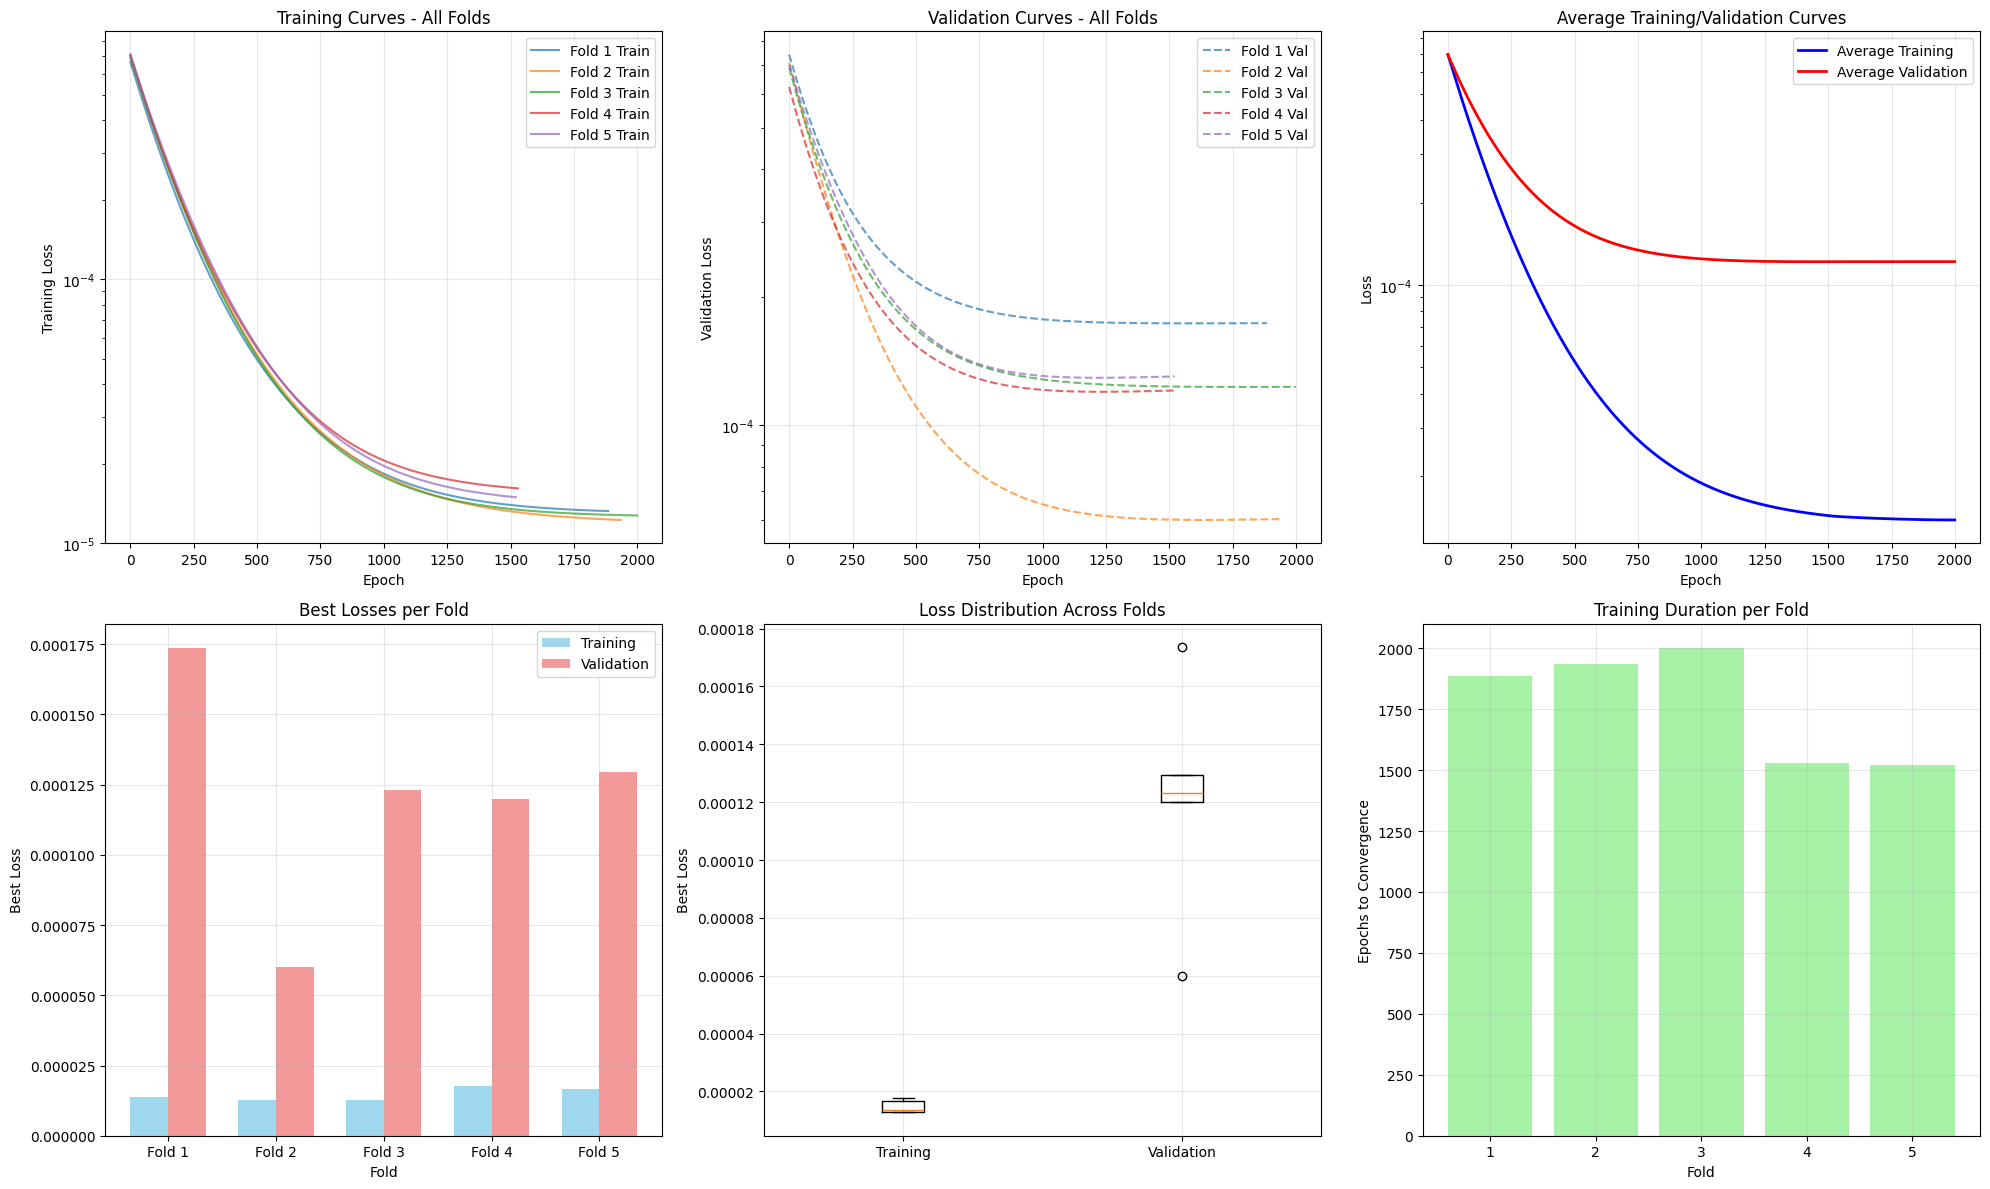


Creating Ensemble Model...
----------------------------------------
Ensemble created with 5 models
Each model has rank 5 with 16200 parameters

K-Fold Cross-Validation Training Complete!


In [71]:
# ====================================================================================
# K-FOLD CROSS-VALIDATION TRAINING WITH ENSEMBLE
# ====================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

print("Starting K-Fold Cross-Validation Training...")
print("=" * 60)

# K-fold configuration
k_folds = 5
random_state = 42
kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

# Training hyperparameters
rank = 5
learning_rate = 2e-5
max_epochs = 2000
patience = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Storage for results
fold_models = []
fold_train_losses = []
fold_val_losses = []
fold_best_train_losses = []
fold_best_val_losses = []
fold_final_epochs = []

print(f"Configuration:")
print(f"  K-folds: {k_folds}")
print(f"  Rank: {rank}")
print(f"  Learning rate: {learning_rate}")
print(f"  Max epochs: {max_epochs}")
print(f"  Early stopping patience: {patience}")
print(f"  Device: {device}")
print()

# K-fold training loop
for fold, (train_idx, val_idx) in enumerate(kf.split(displacements)):
    print(f"Training Fold {fold + 1}/{k_folds}")
    print("-" * 40)

    # Split data for this fold
    X_train_fold = displacements[train_idx].to(device)
    y_train_fold = forces[train_idx].to(device)
    X_val_fold = displacements[val_idx].to(device)
    y_val_fold = forces[val_idx].to(device)

    print(f"  Training samples: {len(X_train_fold)}")
    print(f"  Validation samples: {len(X_val_fold)}")

    # Initialize model for this fold
    model = ForceBasedLoRAModel(num_atoms=40, rank=rank).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_train_loss = None
    patience_counter = 0

    # Training loop for this fold
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        preds = model(X_train_fold)
        loss = criterion(preds, y_train_fold)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_fold)
            val_loss = criterion(val_preds, y_val_fold).item()
            val_losses.append(val_loss)

        # early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_train_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        # Print progress
        if epoch % 200 == 0 or epoch == max_epochs - 1:
            print(f"    Epoch {epoch:04d}: Train Loss = {loss.item():.6f}, Val Loss = {val_loss:.6f}")

        # early stopping condition
        if patience_counter >= patience:
            print(f"    Early stopping at epoch {epoch + 1}")
            break

    # Store results for this fold
    fold_models.append(model.cpu())  # Move to CPU to save memory
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_best_train_losses.append(best_train_loss)
    fold_best_val_losses.append(best_val_loss)
    fold_final_epochs.append(len(train_losses))

    print(f"    Best Train Loss: {best_train_loss:.6f}")
    print(f"    Best Val Loss: {best_val_loss:.6f}")
    print(f"    Final epoch: {len(train_losses)}")
    print()

# ====================================================================================
# RESULTS ANALYSIS AND PLOTTING
# ====================================================================================

print("K-Fold Training Results Summary:")
print("=" * 60)

# Calculate ensemble statistics
mean_best_train = np.mean(fold_best_train_losses)
std_best_train = np.std(fold_best_train_losses)
mean_best_val = np.mean(fold_best_val_losses)
std_best_val = np.std(fold_best_val_losses)

print(f"Best Training Loss   - Mean: {mean_best_train:.6f} ± {std_best_train:.6f}")
print(f"Best Validation Loss - Mean: {mean_best_val:.6f} ± {std_best_val:.6f}")
print()

for i in range(k_folds):
    print(f"Fold {i+1}: Train = {fold_best_train_losses[i]:.6f}, "
          f"Val = {fold_best_val_losses[i]:.6f}, "
          f"Epochs = {fold_final_epochs[i]}")

# ====================================================================================
# PLOTTING RESULTS
# ====================================================================================

# Create comprehensive plot
fig = plt.figure(figsize=(20, 12))

# Plot 1: Individual fold training curves
plt.subplot(2, 3, 1)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in range(k_folds):
    plt.plot(fold_train_losses[i], label=f'Fold {i+1} Train',
             color=colors[i], alpha=0.7, linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Curves - All Folds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 2: Individual fold validation curves
plt.subplot(2, 3, 2)
for i in range(k_folds):
    plt.plot(fold_val_losses[i], label=f'Fold {i+1} Val',
             color=colors[i], alpha=0.7, linewidth=1.5, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Curves - All Folds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 3: Average training and validation curves
plt.subplot(2, 3, 3)
# Calculate average curves (pad shorter sequences with last values)
max_epochs_reached = max(fold_final_epochs)
avg_train_curve = np.zeros(max_epochs_reached)
avg_val_curve = np.zeros(max_epochs_reached)

for epoch in range(max_epochs_reached):
    train_values = []
    val_values = []
    for i in range(k_folds):
        if epoch < len(fold_train_losses[i]):
            train_values.append(fold_train_losses[i][epoch])
            val_values.append(fold_val_losses[i][epoch])
        else:
            # Pad with last value
            train_values.append(fold_train_losses[i][-1])
            val_values.append(fold_val_losses[i][-1])

    avg_train_curve[epoch] = np.mean(train_values)
    avg_val_curve[epoch] = np.mean(val_values)

plt.plot(avg_train_curve, label='Average Training', color='blue', linewidth=2)
plt.plot(avg_val_curve, label='Average Validation', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training/Validation Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 4: Best losses per fold (bar plot)
plt.subplot(2, 3, 4)
x_pos = np.arange(k_folds)
width = 0.35
plt.bar(x_pos - width/2, fold_best_train_losses, width,
        label='Training', alpha=0.8, color='skyblue')
plt.bar(x_pos + width/2, fold_best_val_losses, width,
        label='Validation', alpha=0.8, color='lightcoral')
plt.xlabel('Fold')
plt.ylabel('Best Loss')
plt.title('Best Losses per Fold')
plt.xticks(x_pos, [f'Fold {i+1}' for i in range(k_folds)])
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Loss distribution (violin plot)
plt.subplot(2, 3, 5)
plt.boxplot([fold_best_train_losses, fold_best_val_losses],
            labels=['Training', 'Validation'])
plt.ylabel('Best Loss')
plt.title('Loss Distribution Across Folds')
plt.grid(True, alpha=0.3)

# Plot 6: Convergence epochs
plt.subplot(2, 3, 6)
plt.bar(range(1, k_folds + 1), fold_final_epochs,
        alpha=0.8, color='lightgreen')
plt.xlabel('Fold')
plt.ylabel('Epochs to Convergence')
plt.title('Training Duration per Fold')
plt.xticks(range(1, k_folds + 1))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ====================================================================================
# ENSEMBLE MODEL CREATION
# ====================================================================================

print("\nCreating Ensemble Model...")
print("-" * 40)

# Move all models back to device for ensemble predictions
for i, model in enumerate(fold_models):
    fold_models[i] = model.to(device)

def ensemble_predict(models, X):
    """Make ensemble predictions using all fold models"""
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(X)
            predictions.append(pred)

    # Average predictions
    ensemble_pred = torch.mean(torch.stack(predictions), dim=0)
    return ensemble_pred

print(f"Ensemble created with {len(fold_models)} models")
print(f"Each model has rank {rank} with {sum(p.numel() for p in fold_models[0].parameters())} parameters")

print("\nK-Fold Cross-Validation Training Complete!")
print("=" * 60)

plot


Starting Ensemble Force Validation...
Test set size: 15 configurations
Test set shape: torch.Size([15, 40, 3])
Computing ensemble predictions...
Ensemble prediction shape: torch.Size([15, 40, 3])
Ensemble uncertainty shape: torch.Size([15, 40, 3])
Generating ensemble force comparison visualization...


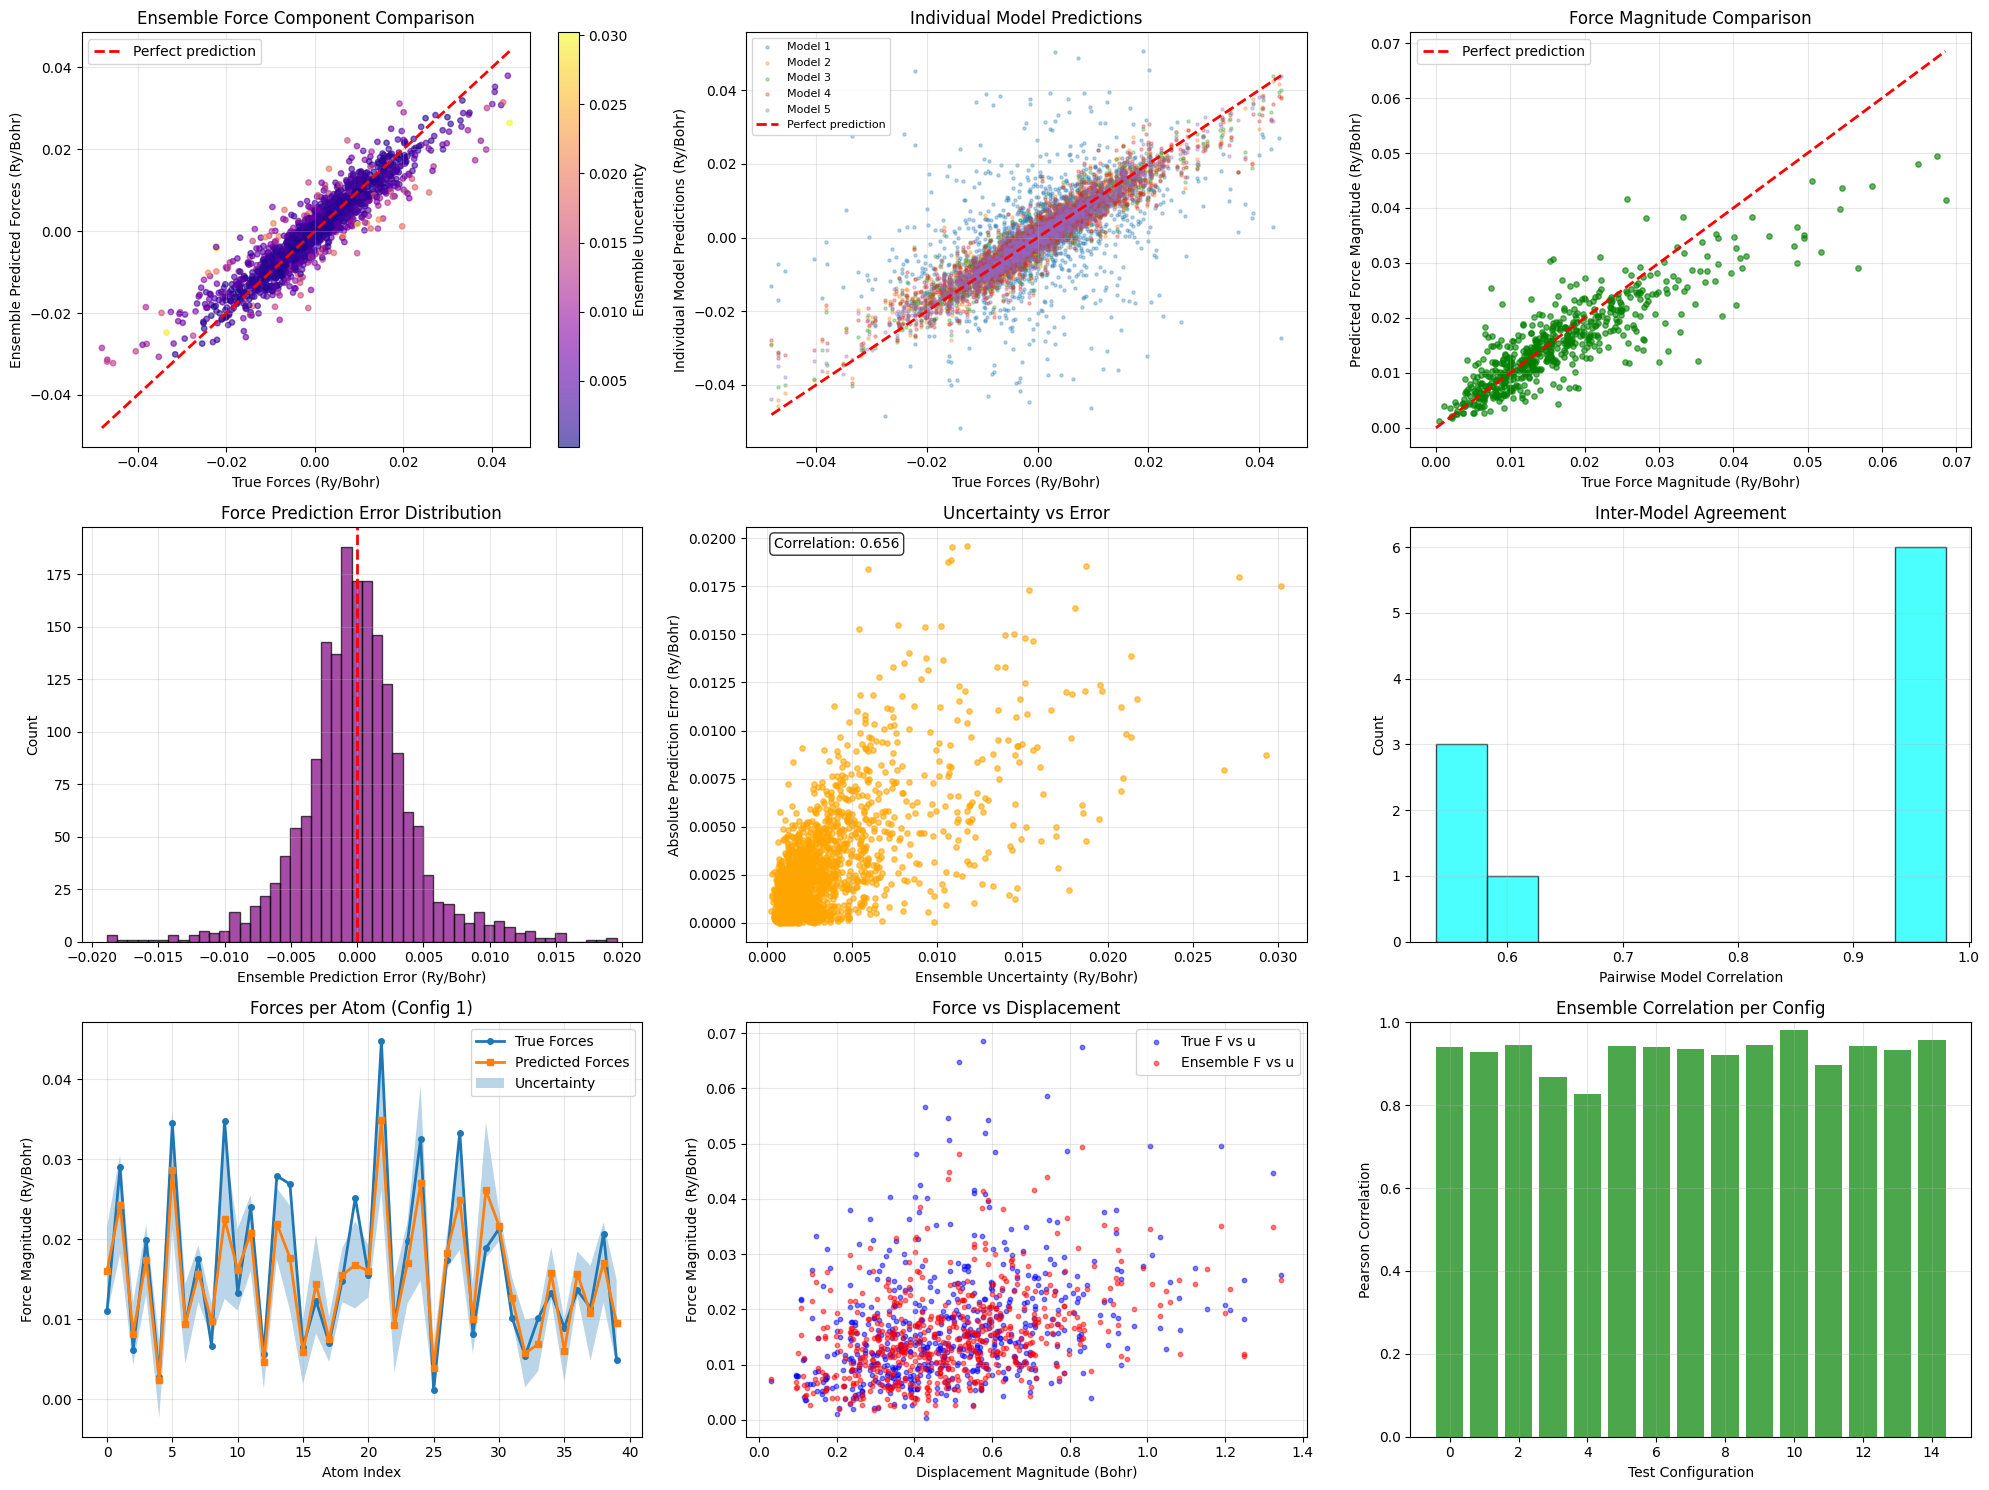

ENSEMBLE FORCE PREDICTION ANALYSIS:
Number of test configurations: 15
Total force components compared: 1,800
Number of models in ensemble: 5

Ensemble Performance Metrics:
Mean Squared Error (MSE): 1.776759e-05 (Ry/Bohr)²
Root Mean Squared Error (RMSE): 4.215162e-03 Ry/Bohr
Mean Absolute Error (MAE): 3.002607e-03 Ry/Bohr
R² Score: 0.8607
Overall Correlation: 0.9288

Uncertainty Analysis:
Mean ensemble uncertainty: 3.576985e-03 Ry/Bohr
Max ensemble uncertainty: 3.019799e-02 Ry/Bohr
Uncertainty/Error correlation: 0.6559

Model Agreement:
Mean inter-model correlation: 0.8055
Min inter-model correlation: 0.5379
Max inter-model correlation: 0.9800

Individual Model Performance vs Ensemble:
Model 1: MSE = 1.463046e-04, Correlation = 0.4884
Model 2: MSE = 1.198583e-05, Correlation = 0.9521
Model 3: MSE = 1.170232e-05, Correlation = 0.9532
Model 4: MSE = 1.535635e-05, Correlation = 0.9380
Model 5: MSE = 8.176624e-06, Correlation = 0.9676

Scale Analysis:
True force range: [-4.8059e-02, 4.3986e

In [14]:
# ====================================================================================
# ENSEMBLE FORCE VALIDATION
# ====================================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

print("Starting Ensemble Force Validation...")
print("=" * 60)

# Create test set (using the same split as before for consistency)
from sklearn.model_selection import train_test_split

# Use the same random state for consistency with single model approach
X_temp_test, X_test_ensemble, y_temp_test, y_test_ensemble = train_test_split(
    displacements, forces, test_size=0.15, random_state=RANDOM_STATE
)

print(f"Test set size: {len(X_test_ensemble)} configurations")
print(f"Test set shape: {X_test_ensemble.shape}")

# ====================================================================================
# ENSEMBLE PREDICTIONS
# ====================================================================================

def ensemble_predict_detailed(models, X, device):
    """Make ensemble predictions with detailed analysis of individual model contributions"""
    individual_predictions = []

    for i, model in enumerate(models):
        model.eval()
        model = model.to(device)
        with torch.no_grad():
            pred = model(X.to(device)).cpu()
            individual_predictions.append(pred)

    # Stack predictions and compute ensemble statistics
    predictions_stack = torch.stack(individual_predictions)  # Shape: [n_models, n_samples, n_atoms, 3]

    # Ensemble prediction (mean)
    ensemble_pred = torch.mean(predictions_stack, dim=0)

    # Ensemble uncertainty (standard deviation across models)
    ensemble_std = torch.std(predictions_stack, dim=0)

    return ensemble_pred, ensemble_std, individual_predictions

print("Computing ensemble predictions...")
ensemble_pred, ensemble_std, individual_preds = ensemble_predict_detailed(
    fold_models, X_test_ensemble, device
)

print(f"Ensemble prediction shape: {ensemble_pred.shape}")
print(f"Ensemble uncertainty shape: {ensemble_std.shape}")

# ====================================================================================
# FORCE VALIDATION VISUALIZATION (ADAPTED FOR ENSEMBLE)
# ====================================================================================

def compare_ensemble_forces_visualization(ensemble_pred, ensemble_std, individual_preds,
                                        X_test, y_test, n_samples=10):
    """
    Compare ensemble model predictions with actual DFT forces.

    Args:
        ensemble_pred: Ensemble averaged predictions
        ensemble_std: Ensemble uncertainty (std across models)
        individual_preds: List of individual model predictions
        X_test: Test displacements
        y_test: Test forces (ground truth)
        n_samples: Number of configurations to visualize
    """

    # Convert to numpy for analysis
    test_predictions = ensemble_pred[:n_samples].numpy()
    test_uncertainty = ensemble_std[:n_samples].numpy()
    test_targets = y_test[:n_samples].numpy()
    test_displacements = X_test[:n_samples].numpy()

    # Individual model predictions
    individual_preds_np = [pred[:n_samples].numpy() for pred in individual_preds]

    # Create comprehensive comparison plots
    fig = plt.figure(figsize=(20, 15))

    # Plot 1: Ensemble force component scatter plot
    ax1 = plt.subplot(3, 3, 1)
    pred_flat = test_predictions.flatten()
    target_flat = test_targets.flatten()
    uncertainty_flat = test_uncertainty.flatten()

    # Color by uncertainty
    scatter = ax1.scatter(target_flat, pred_flat, c=uncertainty_flat, alpha=0.6, s=15, cmap='plasma')

    # Perfect prediction line
    min_force = min(target_flat.min(), pred_flat.min())
    max_force = max(target_flat.max(), pred_flat.max())
    ax1.plot([min_force, max_force], [min_force, max_force], 'r--', linewidth=2, label='Perfect prediction')

    ax1.set_xlabel('True Forces (Ry/Bohr)')
    ax1.set_ylabel('Ensemble Predicted Forces (Ry/Bohr)')
    ax1.set_title('Ensemble Force Component Comparison')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    plt.colorbar(scatter, ax=ax1, label='Ensemble Uncertainty')

    # Plot 2: Individual model scatter (showing model diversity)
    ax2 = plt.subplot(3, 3, 2)
    colors_models = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for i, pred_individual in enumerate(individual_preds_np):
        pred_ind_flat = pred_individual.flatten()
        ax2.scatter(target_flat, pred_ind_flat, alpha=0.3, s=5,
                   color=colors_models[i], label=f'Model {i+1}')

    ax2.plot([min_force, max_force], [min_force, max_force], 'r--', linewidth=2, label='Perfect prediction')
    ax2.set_xlabel('True Forces (Ry/Bohr)')
    ax2.set_ylabel('Individual Model Predictions (Ry/Bohr)')
    ax2.set_title('Individual Model Predictions')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=8)

    # Plot 3: Force magnitude comparison
    ax3 = plt.subplot(3, 3, 3)
    pred_magnitudes = np.linalg.norm(test_predictions, axis=2)
    target_magnitudes = np.linalg.norm(test_targets, axis=2)

    pred_mag_flat = pred_magnitudes.flatten()
    target_mag_flat = target_magnitudes.flatten()

    ax3.scatter(target_mag_flat, pred_mag_flat, alpha=0.6, s=15, color='green')
    max_mag = max(target_mag_flat.max(), pred_mag_flat.max())
    ax3.plot([0, max_mag], [0, max_mag], 'r--', linewidth=2, label='Perfect prediction')
    ax3.set_xlabel('True Force Magnitude (Ry/Bohr)')
    ax3.set_ylabel('Predicted Force Magnitude (Ry/Bohr)')
    ax3.set_title('Force Magnitude Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Error distribution
    ax4 = plt.subplot(3, 3, 4)
    errors = pred_flat - target_flat
    ax4.hist(errors, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('Ensemble Prediction Error (Ry/Bohr)')
    ax4.set_ylabel('Count')
    ax4.set_title('Force Prediction Error Distribution')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Uncertainty vs Error correlation
    ax5 = plt.subplot(3, 3, 5)
    abs_errors = np.abs(errors)
    ax5.scatter(uncertainty_flat, abs_errors, alpha=0.6, s=15, color='orange')
    ax5.set_xlabel('Ensemble Uncertainty (Ry/Bohr)')
    ax5.set_ylabel('Absolute Prediction Error (Ry/Bohr)')
    ax5.set_title('Uncertainty vs Error')
    ax5.grid(True, alpha=0.3)

    # Calculate correlation between uncertainty and error
    if np.std(uncertainty_flat) > 1e-8:
        uncert_error_corr, _ = pearsonr(uncertainty_flat, abs_errors)
        ax5.text(0.05, 0.95, f'Correlation: {uncert_error_corr:.3f}',
                transform=ax5.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plot 6: Model agreement analysis
    ax6 = plt.subplot(3, 3, 6)
    # Calculate pairwise correlations between models
    model_correlations = []
    for i in range(len(individual_preds_np)):
        for j in range(i+1, len(individual_preds_np)):
            pred_i = individual_preds_np[i].flatten()
            pred_j = individual_preds_np[j].flatten()
            if np.std(pred_i) > 1e-8 and np.std(pred_j) > 1e-8:
                corr, _ = pearsonr(pred_i, pred_j)
                model_correlations.append(corr)

    ax6.hist(model_correlations, bins=10, alpha=0.7, color='cyan', edgecolor='black')
    ax6.set_xlabel('Pairwise Model Correlation')
    ax6.set_ylabel('Count')
    ax6.set_title('Inter-Model Agreement')
    ax6.grid(True, alpha=0.3)

    # Plot 7: Force per atom (line plot)
    ax7 = plt.subplot(3, 3, 7)
    sample_idx = 0  # Show first test sample
    atom_indices = np.arange(test_predictions.shape[1])

    true_forces_per_atom = np.linalg.norm(test_targets[sample_idx], axis=1)
    pred_forces_per_atom = np.linalg.norm(test_predictions[sample_idx], axis=1)
    uncert_per_atom = np.linalg.norm(test_uncertainty[sample_idx], axis=1)

    ax7.plot(atom_indices, true_forces_per_atom, 'o-', label='True Forces', linewidth=2, markersize=4)
    ax7.plot(atom_indices, pred_forces_per_atom, 's-', label='Predicted Forces', linewidth=2, markersize=4)
    ax7.fill_between(atom_indices,
                     pred_forces_per_atom - uncert_per_atom,
                     pred_forces_per_atom + uncert_per_atom,
                     alpha=0.3, label='Uncertainty')
    ax7.set_xlabel('Atom Index')
    ax7.set_ylabel('Force Magnitude (Ry/Bohr)')
    ax7.set_title(f'Forces per Atom (Config {sample_idx+1})')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Plot 8: Displacement vs Force relationship
    ax8 = plt.subplot(3, 3, 8)
    disp_magnitudes = np.linalg.norm(test_displacements, axis=2).flatten()

    ax8.scatter(disp_magnitudes, target_mag_flat, alpha=0.5, s=10, label='True F vs u', color='blue')
    ax8.scatter(disp_magnitudes, pred_mag_flat, alpha=0.5, s=10, label='Ensemble F vs u', color='red')
    ax8.set_xlabel('Displacement Magnitude (Bohr)')
    ax8.set_ylabel('Force Magnitude (Ry/Bohr)')
    ax8.set_title('Force vs Displacement')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # Plot 9: Configuration-wise correlation
    ax9 = plt.subplot(3, 3, 9)
    config_correlations = []
    for i in range(n_samples):
        pred_i = test_predictions[i].flatten()
        target_i = test_targets[i].flatten()
        if np.std(pred_i) > 1e-8 and np.std(target_i) > 1e-8:
            corr, _ = pearsonr(pred_i, target_i)
            config_correlations.append(corr)

    ax9.bar(range(len(config_correlations)), config_correlations, alpha=0.7, color='green')
    ax9.set_xlabel('Test Configuration')
    ax9.set_ylabel('Pearson Correlation')
    ax9.set_title('Ensemble Correlation per Config')
    ax9.grid(True, alpha=0.3)
    ax9.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # ====================================================================================
    # QUANTITATIVE METRICS
    # ====================================================================================

    print("ENSEMBLE FORCE PREDICTION ANALYSIS:")
    print("=" * 60)
    print(f"Number of test configurations: {n_samples}")
    print(f"Total force components compared: {len(pred_flat):,}")
    print(f"Number of models in ensemble: {len(individual_preds)}")

    # Overall metrics
    mse = np.mean((pred_flat - target_flat)**2)
    mae = np.mean(np.abs(pred_flat - target_flat))
    rmse = np.sqrt(mse)

    if np.std(target_flat) > 0:
        r2 = 1 - np.sum((target_flat - pred_flat)**2) / np.sum((target_flat - np.mean(target_flat))**2)
        overall_corr, _ = pearsonr(pred_flat, target_flat)
    else:
        r2 = 0
        overall_corr = 0

    print(f"\nEnsemble Performance Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.6e} (Ry/Bohr)²")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6e} Ry/Bohr")
    print(f"Mean Absolute Error (MAE): {mae:.6e} Ry/Bohr")
    print(f"R² Score: {r2:.4f}")
    print(f"Overall Correlation: {overall_corr:.4f}")

    # Uncertainty analysis
    mean_uncertainty = np.mean(uncertainty_flat)
    print(f"\nUncertainty Analysis:")
    print(f"Mean ensemble uncertainty: {mean_uncertainty:.6e} Ry/Bohr")
    print(f"Max ensemble uncertainty: {np.max(uncertainty_flat):.6e} Ry/Bohr")
    print(f"Uncertainty/Error correlation: {uncert_error_corr:.4f}" if 'uncert_error_corr' in locals() else "N/A")

    # Model agreement
    if model_correlations:
        print(f"\nModel Agreement:")
        print(f"Mean inter-model correlation: {np.mean(model_correlations):.4f}")
        print(f"Min inter-model correlation: {np.min(model_correlations):.4f}")
        print(f"Max inter-model correlation: {np.max(model_correlations):.4f}")

    # Individual model comparison
    print(f"\nIndividual Model Performance vs Ensemble:")
    for i, pred_individual in enumerate(individual_preds_np):
        pred_ind_flat = pred_individual.flatten()
        ind_mse = np.mean((pred_ind_flat - target_flat)**2)
        ind_corr, _ = pearsonr(pred_ind_flat, target_flat) if np.std(pred_ind_flat) > 1e-8 else (0, 1)
        print(f"Model {i+1}: MSE = {ind_mse:.6e}, Correlation = {ind_corr:.4f}")

    # Scale comparison
    print(f"\nScale Analysis:")
    print(f"True force range: [{target_flat.min():.4e}, {target_flat.max():.4e}] Ry/Bohr")
    print(f"Ensemble predicted range: [{pred_flat.min():.4e}, {pred_flat.max():.4e}] Ry/Bohr")
    print(f"True force std: {np.std(target_flat):.4e} Ry/Bohr")
    print(f"Ensemble predicted std: {np.std(pred_flat):.4e} Ry/Bohr")

    return {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'correlation': overall_corr,
        'mean_uncertainty': mean_uncertainty,
        'model_correlations': model_correlations,
        'config_correlations': config_correlations
    }

# Run the ensemble comparison
print("Generating ensemble force comparison visualization...")
ensemble_metrics = compare_ensemble_forces_visualization(
    ensemble_pred, ensemble_std, individual_preds,
    X_test_ensemble, y_test_ensemble, n_samples=15
)

print(f"\nEnsemble validation complete!")
print("=" * 60)

## 2. parameter concatenation
we do one 5*R rank decomposition, instead of five R rank decomposition

Starting K-Fold Cross-Validation Training...
Configuration:
  K-folds: 5
  Rank per fold: 5
  Learning rate: 2e-05
  Max epochs: 2000
  Early stopping patience: 300
  Device: cpu

Training Fold 1/5
----------------------------------------
  Training samples: 80
  Validation samples: 20
    Epoch 0000: Train Loss = 0.000679, Val Loss = 0.000711
    Epoch 0200: Train Loss = 0.000190, Val Loss = 0.000356
    Epoch 0400: Train Loss = 0.000073, Val Loss = 0.000252
    Epoch 0600: Train Loss = 0.000037, Val Loss = 0.000213
    Epoch 0800: Train Loss = 0.000024, Val Loss = 0.000196
    Epoch 1000: Train Loss = 0.000018, Val Loss = 0.000187
    Epoch 1200: Train Loss = 0.000015, Val Loss = 0.000184
    Epoch 1400: Train Loss = 0.000014, Val Loss = 0.000182
    Epoch 1600: Train Loss = 0.000014, Val Loss = 0.000182
    Epoch 1800: Train Loss = 0.000013, Val Loss = 0.000182
    Early stopping at epoch 1874
    Best Train Loss: 0.000014
    Best Val Loss: 0.000182
    Final epoch: 1874

Training 

/tmp/ipython-input-82-1391938262.py:220: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fold_best_train_losses, fold_best_val_losses],


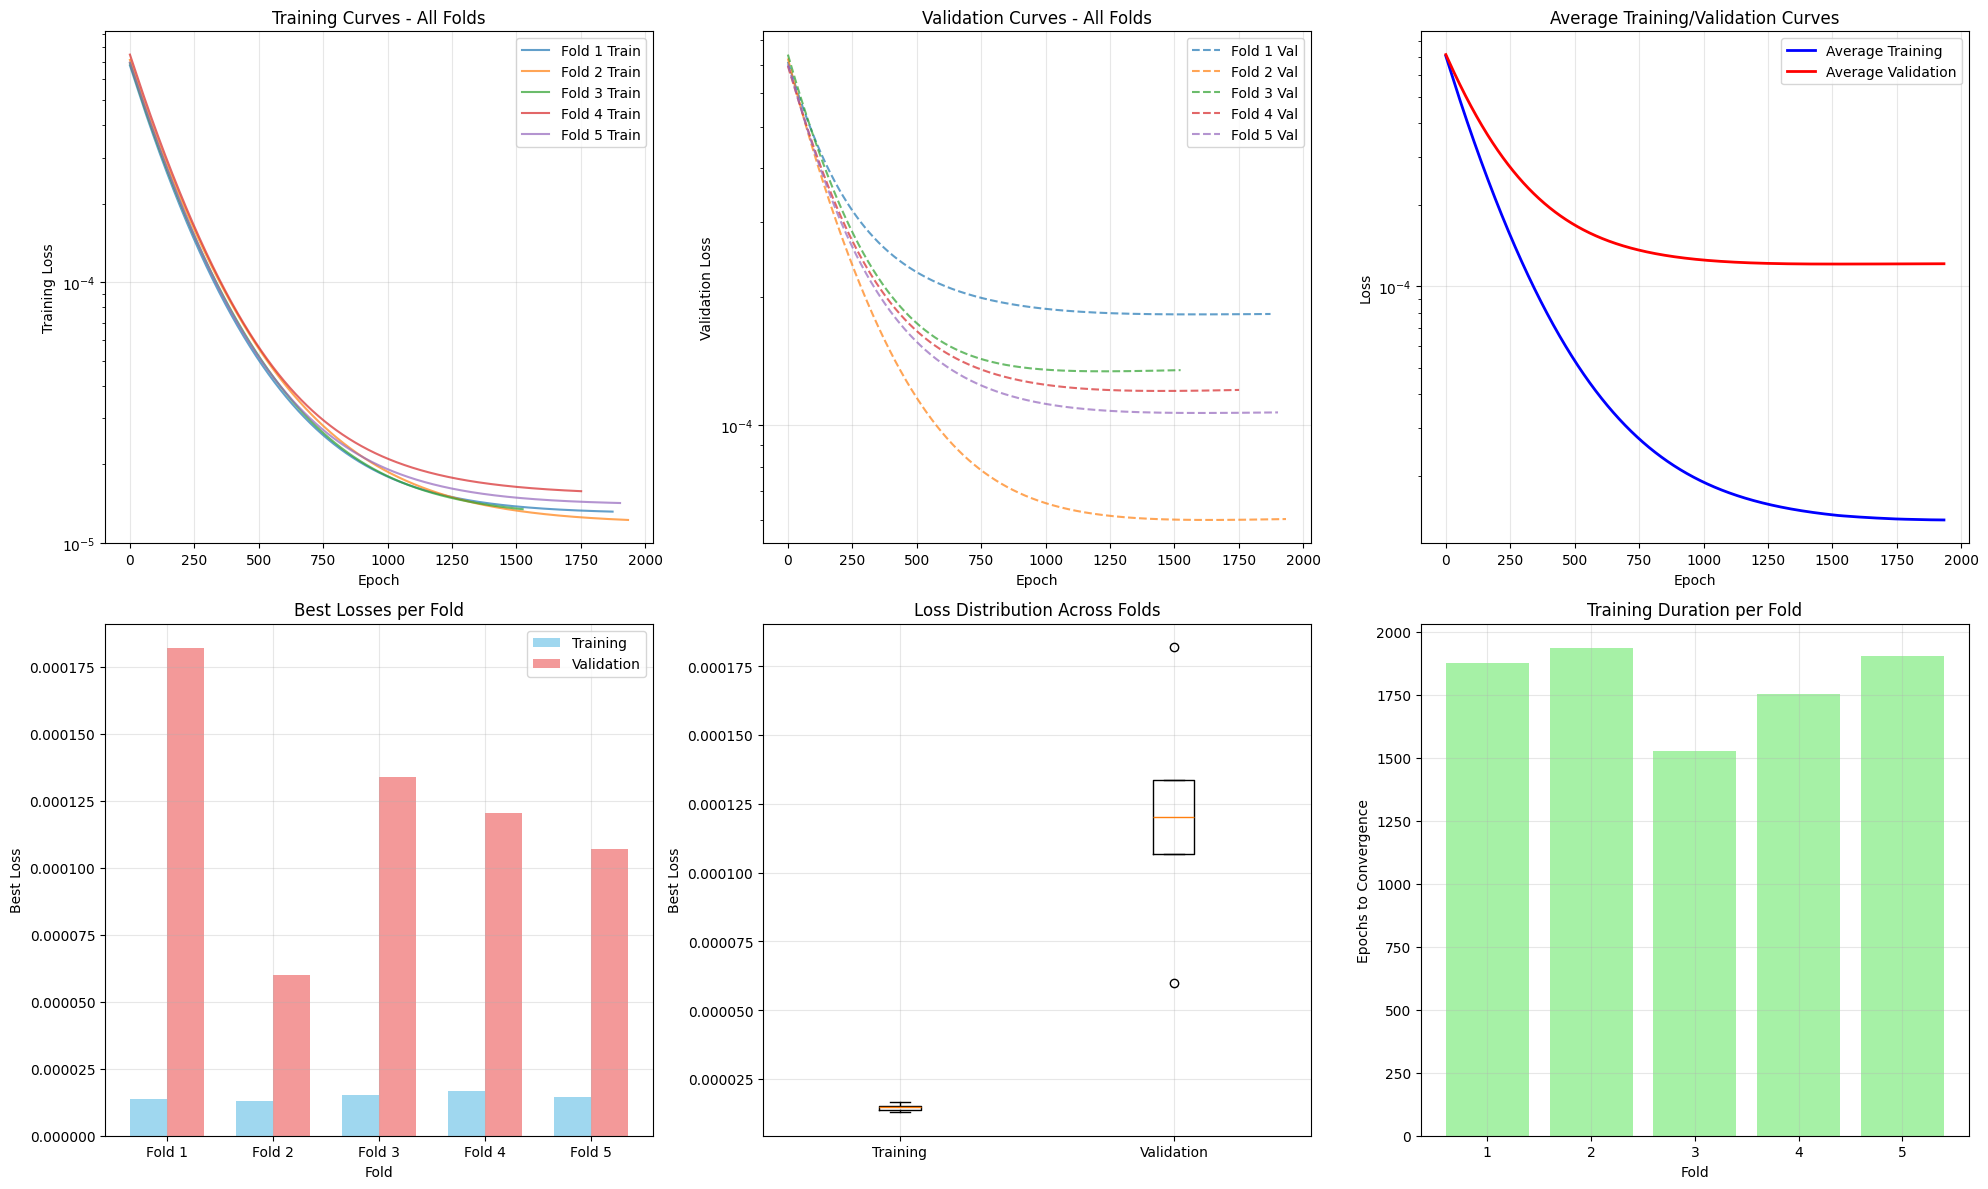


Creating Unified Model via Parameter Concatenation...
--------------------------------------------------
Unified model rank: 25 (from 5 folds × 5 rank each)
Parameter concatenation complete:
  v1_modes shape: torch.Size([25, 120])
  v2_modes shape: torch.Size([25, 120])
  v3_modes shape: torch.Size([25, 120])
  harmonic_matrix shape: torch.Size([120, 120])
  Total parameters: 23400

Unified model ready! Single forward pass captures all 5 fold insights.

K-Fold Cross-Validation Training Complete!


In [82]:
# ====================================================================================
# K-FOLD CROSS-VALIDATION TRAINING WITH PARAMETER CONCATENATION
# ====================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

print("Starting K-Fold Cross-Validation Training...")
print("=" * 60)

# K-fold configuration
k_folds = 5
random_state = 42
kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

# Training hyperparameters
rank = 5
learning_rate = 2e-5
max_epochs = 2000
patience = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Storage for results
fold_models = []
fold_train_losses = []
fold_val_losses = []
fold_best_train_losses = []
fold_best_val_losses = []
fold_final_epochs = []

print(f"Configuration:")
print(f"  K-folds: {k_folds}")
print(f"  Rank per fold: {rank}")
print(f"  Learning rate: {learning_rate}")
print(f"  Max epochs: {max_epochs}")
print(f"  Early stopping patience: {patience}")
print(f"  Device: {device}")
print()

# K-fold training loop
for fold, (train_idx, val_idx) in enumerate(kf.split(displacements)):
    print(f"Training Fold {fold + 1}/{k_folds}")
    print("-" * 40)

    # Split data for this fold
    X_train_fold = displacements[train_idx].to(device)
    y_train_fold = forces[train_idx].to(device)
    X_val_fold = displacements[val_idx].to(device)
    y_val_fold = forces[val_idx].to(device)

    print(f"  Training samples: {len(X_train_fold)}")
    print(f"  Validation samples: {len(X_val_fold)}")

    # Initialize model for this fold
    model = ForceBasedLoRAModel(num_atoms=40, rank=rank).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_train_loss = None
    patience_counter = 0

    # Training loop for this fold
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        preds = model(X_train_fold)
        loss = criterion(preds, y_train_fold)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_fold)
            val_loss = criterion(val_preds, y_val_fold).item()
            val_losses.append(val_loss)

        # early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_train_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        # Print progress
        if epoch % 200 == 0 or epoch == max_epochs - 1:
            print(f"    Epoch {epoch:04d}: Train Loss = {loss.item():.6f}, Val Loss = {val_loss:.6f}")

        # early stopping condition
        if patience_counter >= patience:
            print(f"    Early stopping at epoch {epoch + 1}")
            break

    # Store results for this fold
    fold_models.append(model.cpu())  # Move to CPU to save memory
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_best_train_losses.append(best_train_loss)
    fold_best_val_losses.append(best_val_loss)
    fold_final_epochs.append(len(train_losses))

    print(f"    Best Train Loss: {best_train_loss:.6f}")
    print(f"    Best Val Loss: {best_val_loss:.6f}")
    print(f"    Final epoch: {len(train_losses)}")
    print()

# ====================================================================================
# RESULTS ANALYSIS AND PLOTTING
# ====================================================================================

print("K-Fold Training Results Summary:")
print("=" * 60)

# Calculate ensemble statistics
mean_best_train = np.mean(fold_best_train_losses)
std_best_train = np.std(fold_best_train_losses)
mean_best_val = np.mean(fold_best_val_losses)
std_best_val = np.std(fold_best_val_losses)

print(f"Best Training Loss   - Mean: {mean_best_train:.6f} ± {std_best_train:.6f}")
print(f"Best Validation Loss - Mean: {mean_best_val:.6f} ± {std_best_val:.6f}")
print()

for i in range(k_folds):
    print(f"Fold {i+1}: Train = {fold_best_train_losses[i]:.6f}, "
          f"Val = {fold_best_val_losses[i]:.6f}, "
          f"Epochs = {fold_final_epochs[i]}")

# ====================================================================================
# PLOTTING RESULTS
# ====================================================================================

# Create comprehensive plot
fig = plt.figure(figsize=(20, 12))

# Plot 1: Individual fold training curves
plt.subplot(2, 3, 1)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in range(k_folds):
    plt.plot(fold_train_losses[i], label=f'Fold {i+1} Train',
             color=colors[i], alpha=0.7, linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Curves - All Folds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 2: Individual fold validation curves
plt.subplot(2, 3, 2)
for i in range(k_folds):
    plt.plot(fold_val_losses[i], label=f'Fold {i+1} Val',
             color=colors[i], alpha=0.7, linewidth=1.5, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Curves - All Folds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 3: Average training and validation curves
plt.subplot(2, 3, 3)
# Calculate average curves (pad shorter sequences with last values)
max_epochs_reached = max(fold_final_epochs)
avg_train_curve = np.zeros(max_epochs_reached)
avg_val_curve = np.zeros(max_epochs_reached)

for epoch in range(max_epochs_reached):
    train_values = []
    val_values = []
    for i in range(k_folds):
        if epoch < len(fold_train_losses[i]):
            train_values.append(fold_train_losses[i][epoch])
            val_values.append(fold_val_losses[i][epoch])
        else:
            # Pad with last value
            train_values.append(fold_train_losses[i][-1])
            val_values.append(fold_val_losses[i][-1])

    avg_train_curve[epoch] = np.mean(train_values)
    avg_val_curve[epoch] = np.mean(val_values)

plt.plot(avg_train_curve, label='Average Training', color='blue', linewidth=2)
plt.plot(avg_val_curve, label='Average Validation', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training/Validation Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 4: Best losses per fold (bar plot)
plt.subplot(2, 3, 4)
x_pos = np.arange(k_folds)
width = 0.35
plt.bar(x_pos - width/2, fold_best_train_losses, width,
        label='Training', alpha=0.8, color='skyblue')
plt.bar(x_pos + width/2, fold_best_val_losses, width,
        label='Validation', alpha=0.8, color='lightcoral')
plt.xlabel('Fold')
plt.ylabel('Best Loss')
plt.title('Best Losses per Fold')
plt.xticks(x_pos, [f'Fold {i+1}' for i in range(k_folds)])
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Loss distribution (violin plot)
plt.subplot(2, 3, 5)
plt.boxplot([fold_best_train_losses, fold_best_val_losses],
            labels=['Training', 'Validation'])
plt.ylabel('Best Loss')
plt.title('Loss Distribution Across Folds')
plt.grid(True, alpha=0.3)

# Plot 6: Convergence epochs
plt.subplot(2, 3, 6)
plt.bar(range(1, k_folds + 1), fold_final_epochs,
        alpha=0.8, color='lightgreen')
plt.xlabel('Fold')
plt.ylabel('Epochs to Convergence')
plt.title('Training Duration per Fold')
plt.xticks(range(1, k_folds + 1))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ====================================================================================
# UNIFIED MODEL CREATION VIA PARAMETER CONCATENATION
# ====================================================================================

print("\nCreating Unified Model via Parameter Concatenation...")
print("-" * 50)

# Move all models to device and extract parameters
for i, model in enumerate(fold_models):
    fold_models[i] = model.to(device)

# Create unified model with concatenated rank (5 folds × 5 rank = 25)
unified_rank = k_folds * rank
unified_model = ForceBasedLoRAModel(num_atoms=40, rank=unified_rank).to(device)

print(f"Unified model rank: {unified_rank} (from {k_folds} folds × {rank} rank each)")

# Concatenate parameters from all fold models
with torch.no_grad():
    # Concatenate v1_modes, v2_modes, v3_modes along the rank dimension
    v1_concat = torch.cat([model.v1_modes.data for model in fold_models], dim=0)
    v2_concat = torch.cat([model.v2_modes.data for model in fold_models], dim=0)
    v3_concat = torch.cat([model.v3_modes.data for model in fold_models], dim=0)

    # Average the harmonic matrices (they should be similar across folds)
    harmonic_avg = torch.mean(torch.stack([model.harmonic_matrix.data for model in fold_models]), dim=0)

    # Set unified model parameters
    unified_model.v1_modes.data = v1_concat
    unified_model.v2_modes.data = v2_concat
    unified_model.v3_modes.data = v3_concat
    unified_model.harmonic_matrix.data = harmonic_avg

print(f"Parameter concatenation complete:")
print(f"  v1_modes shape: {unified_model.v1_modes.shape}")
print(f"  v2_modes shape: {unified_model.v2_modes.shape}")
print(f"  v3_modes shape: {unified_model.v3_modes.shape}")
print(f"  harmonic_matrix shape: {unified_model.harmonic_matrix.shape}")
print(f"  Total parameters: {sum(p.numel() for p in unified_model.parameters())}")

# Unified model is now ready for predictions with rank 25
print(f"\nUnified model ready! Single forward pass captures all {k_folds} fold insights.")

print("\nK-Fold Cross-Validation Training Complete!")
print("=" * 60)